# AIML Assignment 2: Time Series Analysis on Pollutant Gases
## Problem Statement
![Air Pollution](https://assets.nrdc.org/sites/default/files/styles/header_background/public/health4_26_airpollguide_istock_2796602_900x600px.jpg?itok=vCwn8tgz)

Air pollution is a problem that affects major cities around the world. There are many different types of air pollutants, which usually come in the form of gases like carbon monoxide, carbon dioxide, sulfur dioxide, nitrogen oxides, CFCss, and other chemicals. 

Bad air quality in cities can lead to health problems for residents living there, including respiratory diseases and even death. In fact, according to the World Health Organisation, air pollution accounts for 4.2 million deaths every year [[1]](https://www.who.int/health-topics/air-pollution#tab=tab_1). To keep track of air pollution, governments invest heavily in sensors, which are used to measure the level of air pollution of different pollutants. However, good quality sensors are expensive, and thus governments rely on cheap sensors which have low accuracy. [[2]](https://ink.library.smu.edu.sg/cgi/viewcontent.cgi?article=5536&context=sis_research)

Our task is to create a time series model that is capable of forecasting air pollution levels. If our model can forecast air pollution data with a reasonable accuracy, it would be a valuable tool (more accurate than low quality sensors) for health authorities to guage the impact of air pollution, and warn the public of any health threats. 

To be more concrete, our task is to predict the average sensor response of Carbon Monoxide, Non Metanic HydroCarbons, Nitrogen Oxides, and Ozone. (Note that sensor response is not the same as the concentration.)

## Data Understanding
The dataset appears to be sourced from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality), but with data downsampled from an hourly frequency to a daily frequency, and several features omitted. The description and date range of the data appears to match up, the scales of the data are the same,and even the method of marking missing values is the same. 

If we make an assumption that the data set is the same, we can say that the data was collected from chemical sensor data collected over the course of March 2004 to February 2005. [[4]](https://www.sciencedirect.com/science/article/abs/pii/S0925400507007691?via%3Dihub)

![Operation of a MOS Type Gas Sensor](https://www.figaro.co.jp/en/img/development/handoutai/shikumi.gif)

The sensors used are metal oxide sensors, which use a sensing layer, where gases are either absorbed or desorbed. This reaction causes a change in the conductivity of the material. [[4]](https://www.sciencedirect.com/science/article/abs/pii/S0925400507007691?via%3Dihub). The sensor device then uses this reading to estimate the concentration of that particular gas in the surroundings.

Our dataset contains the following attributes:

| Attribute | Description |
|---|---|
| Date | Day/Month/Year Format, which is different from default Pandas format |
| T | Temperature in Degree Celcius |
| RH | Relative Humidity (%) |
| Gas | Type of Gas Measured: CO (Carbon Monoxide), NMHC (Non Metanic HydroCarbons), NOx (Nitrogen Oxides), O3 (Ozone) |
| Value | Daily Averaged Estimated Concentration of Pollutants. Note that the concentration for Carbon Monoxide would be in a different unit |

Our target attribute would be the `Value` attribute.
## References
- AIML Module Notes
- Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. OTexts.com/fpp3. 
- Statsmodels Documentation
- Pandas documentation
- Scikit Learn documentation
- Wiley Data Analyst Time Series and Forecasting Notes
- [World Health Organisation](https://www.who.int/health-topics/air-pollution#tab=tab_1)
- MAAH, Balz; ZHOU, Zimu; and THIELE, Lothar. A survey on sensor calibration in air pollution monitoring 
deployments. (2018). IEEE Internet of Things. 5, (6), 4857-4870. Research Collection School Of 
Information Systems. 
- [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality)
- [S. De Vito, E. Massera, M. Piga, L. Martinotto, G. Di Francia,
On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scenario](https://www.researchgate.net/publication/235641830_On_field_calibration_of_an_electronic_nose_for_benzene_estimation_in_an_urban_pollution_monitoring_scenario)
- [Climate of Italy](https://en.wikipedia.org/wiki/Climate_of_Italy)
- [Nitrogen Oxide Emission Trends for Italy](https://www.statista.com/statistics/809161/nitrogen-oxides-nox-emission-trend-in-italy/)
- [NOx Emissions - European Environment Agency](https://www.eea.europa.eu/data-and-maps/indicators/eea-32-nitrogen-oxides-nox-emissions-1/assessment.2010-08-19.0140149032-3#:~:text=The%20sectors%20responsible%20for%20the,distribution%27%20(contributing%2027%25).)
- [Effect of Environmental Temperature and Humidity
on Different Metal Oxide Gas Sensors at Various
Gas Concentration Levels, Abdulnasser Nabil Abdullah et al 2020 IOP Conf. Ser.: Mater. Sci. Eng. 864
012152](https://iopscience.iop.org/article/10.1088/1757-899X/864/1/012152/pdf)
- [Choosing the order of an ARIMA model](https://arauto.readthedocs.io/en/latest/how_to_choose_terms.html#the-acf-and-pacf-function)
- [Using Pearson Correlation Correctly With Time Series](https://stats.stackexchange.com/questions/133155/how-to-use-pearson-correlation-correctly-with-time-series)

## Library Imports

In [1]:
# Utility
from os import path
from os.path import exists # We use this to check if a file exists
from tqdm import tqdm # Use this to track how much time each iter of a for loop takes
import warnings # Statsmodels likes to throw out warnings. Some of them are important, some are not
from statsmodels.tools.sm_exceptions import *
from collections import defaultdict 
from statsmodels.api import load # load serialized models
from joblib import Parallel, delayed # Parallelise our grid search
# Statistical Analysis
## General
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

## Time Series
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt

## Model Validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


# Graphical Plots
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set()
plt.rcParams['figure.figsize'] = (13, 8)

## Data Ingestion
We will start out by loading in our data. We must take note here that the date formatting of the data does not follow the standard Pandas convention. As such, we must specify the date formatting to convert the date attribute to a datetime.

Since many Pandas time series methods only work if the index of our data is a time series, we will set the date attribute as the index.

Also, we will set all -200 values as missing values, as specified in the dataset source.

In [2]:
df = pd.read_csv("train.csv", na_values=[-200])
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df.set_index("Date", inplace=True)
df.head()

T         RH Gas        Value
Date                                             
2004-03-10  12.020833  54.883334  CO  1316.500000
2004-03-11   9.833333  64.069791  CO  1244.062500
2004-03-12  11.292708  51.107292  CO  1281.562500
2004-03-13  12.866319  51.530903  CO  1330.555556
2004-03-14  16.016667  48.843750  CO  1360.927083

### Pivoting from Long to Wide Format
The form of our data is in a long format. For easier analysis later, we will pivot the data to a wide format, with a column for each row.

In [3]:
df_pivot = pd.pivot(df, values="Value", columns="Gas")
df_pivot[["T", "RH"]] = df[["T", "RH"]].groupby(df.index).mean()

## Exploratory Data Analysis

We then perform an exploratory data analysis of our data. 

### What do we want to find out?
#### General Dataset Information
- How many rows of data are there?
- What is the frequency of the time series data?
- How many features are there, and what do they mean?
- What are the data types of each attribute, and are they correctly represented?

#### Missing Values
- How many missing values are there?
- Why are there missing values?
- What should be done about the missing values?

#### Distribution of Data
- What does the distribution of our data look like, and what does it say about the data?

#### Outlier Analysis
- How many outliers are there in the data?
- Where are the outliers in the data?
- What should be done about outliers?
#### Correlation
- What are the relationships between the various variables?

#### Time Series

- What can be said about the trend and seasonality of the data?
- Is the data stationary?

### General Dataset Information

#### How many rows of data are there?

In [4]:
rows, cols = df.shape
print(f"There are {rows} rows and {cols} attributes in the dataset.")

There are 1312 rows and 4 attributes in the dataset.


In [5]:
rows, cols = df_pivot.shape
print(f"There are {rows} rows and {cols} attributes in the pivoted dataset.")

There are 328 rows and 6 attributes in the pivoted dataset.


#### What is the frequency of the time series data?

In [6]:
df_pivot.index

DatetimeIndex(['2004-03-10', '2004-03-11', '2004-03-12', '2004-03-13',
               '2004-03-14', '2004-03-15', '2004-03-16', '2004-03-17',
               '2004-03-18', '2004-03-19',
               ...
               '2005-01-22', '2005-01-23', '2005-01-24', '2005-01-25',
               '2005-01-26', '2005-01-27', '2005-01-28', '2005-01-29',
               '2005-01-30', '2005-01-31'],
              dtype='datetime64[ns]', name='Date', length=328, freq=None)

There is not explicitly stated frequency. However, we suspect it is daily. We will need to verify this.

In [7]:
len(df_pivot) - len(df_pivot.asfreq("D"))

0

Since `.asfreq("D")` did not make any extra rows in the data, this confirms our hypothesis of a daily frequency.

In [8]:
df_pivot = df_pivot.asfreq("D") # explicitly state a daily frequency

#### How many features are there and what do they mean?

Our dataset contains the following attributes:

| Attribute | Description |
|---|---|
| Date | Day/Month/Year Format, which is different from default Pandas format |
| T | Temperature in Degree Celcius |
| RH | Relative Humidity (%) |
| Gas | Type of Gas Measured: CO (Carbon Monoxide), NMHC (Non Metanic HydroCarbons), NOx (Nitrogen Oxides), O3 (Ozone) |
| Value | Daily Averaged Estimated Concentration of Pollutants in micrograms/milligrams per cubic meter. Note that the concentration for Carbon Monoxide would be in a different unit (milligrams) |

#### What are the data types of each attribute, and are they correctly represented?

In [9]:
df.dtypes

T        float64
RH       float64
Gas       object
Value    float64
dtype: object

We observe no irregularities with regards to the data type.

### Missing Values

#### How many missing values are there?

In [10]:
df.isna().sum()

T        24
RH       24
Gas       0
Value    24
dtype: int64

In [11]:
df_pivot.isna().sum()

Gas
CO      6
NMHC    6
NOx     6
O3      6
T       6
RH      6
dtype: int64

In [12]:
df_pivot.isna().all(axis=1).sum()

6

It appears that there are exactly six days, where all the attributes are missing.

In [13]:
(df_pivot.isna().all(axis=1).sum() / len(df_pivot)) * 100

1.8292682926829267

This constitutes a very small percentage of our data.

#### Why are there missing values?

In [14]:
df_pivot[df_pivot.isna().any(axis=1)]

Gas         CO  NMHC  NOx  O3   T  RH
Date                                 
2004-06-20 NaN   NaN  NaN NaN NaN NaN
2004-08-27 NaN   NaN  NaN NaN NaN NaN
2004-12-15 NaN   NaN  NaN NaN NaN NaN
2004-12-16 NaN   NaN  NaN NaN NaN NaN
2005-01-03 NaN   NaN  NaN NaN NaN NaN
2005-01-04 NaN   NaN  NaN NaN NaN NaN

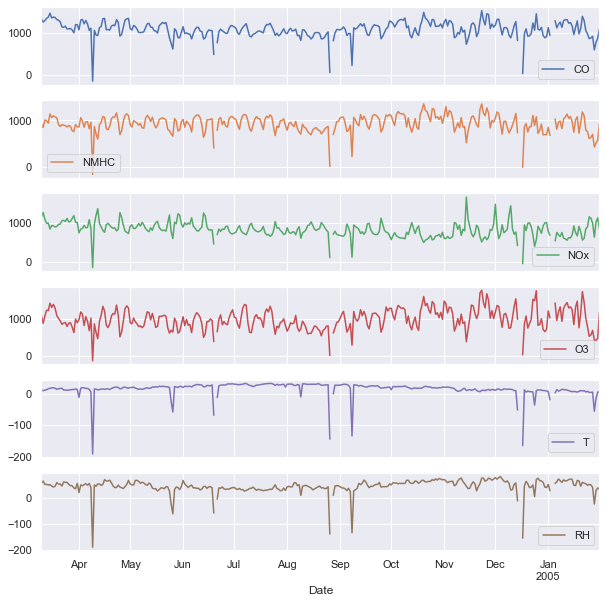

In [15]:
df_pivot.plot(subplots=True, figsize=(10, 10))
plt.show()

We note that days where the missing values do not appear to be related. For some of the days with missing values, we note that the days before and after them have some extreme values, such as extreme spikes.

One possible hypothesis is that the spikes indicate some problem with the sensor used, and thus, the sensors had to be sent for repairs, causing data to be unavailable in the meantime. This would indicate why all the sensors had missing datas on those days.

#### What should be done about missing values?

Based on our hypothesis, if the missing values are due to problems with the sensors that were detected, it may not be a good idea to immediately fill the missing values with the previous value, as it may be an outlier value.

Possible methods:
- Front fill, but mark and deal with outliers first

### Distribution of Data

#### What does the distribution of our data look like, and what does it say about the data?

In [16]:
df_pivot.describe()

Gas             CO         NMHC          NOx           O3           T  \
count   322.000000   322.000000   322.000000   322.000000  322.000000   
mean   1074.034862   932.706457   831.478477   997.677396   15.578425   
std     192.346012   184.942814   200.428180   287.769529   23.412864   
min    -142.666667  -153.458333  -155.583333  -143.697917 -191.164583   
25%     981.338542   839.421875   712.370660   809.098958   12.627083   
50%    1084.482639   948.649306   826.208333  1005.692708   18.993750   
75%    1188.539062  1061.109375   944.387153  1183.658854   25.714149   
max    1513.208333  1355.104167  1678.687500  1795.291667   32.997917   

Gas            RH  
count  322.000000  
mean    44.343425  
std     28.487081  
min   -188.839583  
25%     37.101042  
50%     46.452083  
75%     58.028386  
max     81.104167

- The mean temperature recorded is 15.57 Degrees Celcius, but the min temperature -191.164 degrees celcius. This appears to be an extreme outlier.
- The median temperature is higher than the mean temperature, suggesting a negatively skewed distribution.
- The temperatures seen are mostly consistent with the [climate of Italy](https://en.wikipedia.org/wiki/Climate_of_Italy). This suggests that the temperatures with extreme negative values are actually outliers (possibly sensor miscalibrations), and not the result of extreme cooling in the sensor device.
- The mean relative humidity is 44.34%, which is lower than the median relative humidity. This might suggest a negatively skewed distribution of the data.
- If relative humidity is in percentage, having a negative percentage relative humidity does not make sense. Consider that relative humidity is the **ratio of how much water vapour is in the air and how much water vapor the air could possibly contain at a given temperature**; How is it possible then that it is negative? Logically this must be an error (again, possibly a result of faulty sensors), and any negative values for Relative Humidity should be removed.
- Furthermore, according to the researchers who collected the data, the sensors used are only rated for a temperature of -20 to 50 degrees celcius, and a relative humidity of 10% to 90%. Hence, it is safe to consider any values out of this range as being inaccurate anyways.

![sensor specifications](sensor_specifications.png)

- In our data, we see that there are negative values for each gas as their min estimated concentration
- Recall that for the metal oxide sensors used to collect this data, we get these readings by measuring the change in resistance of the metal oxide material due to a chemical reaction between the metal oxide and the gas and using it to estimate the concentration of pollutants. Thus the "value" attribute in our data is supposed to be an estimated concentration in $\mu/m^3$ (for Nitrogen Oxides and Ozone), or $mg/m^3$ (for Carbon Monoxide)
- As such, a negative concentration does not make any sense. Given that the sensor is only giving a rough estimate of the concentration, it is highly possible that these negative values came about due to sensor errors. 
- The mean values are similar to their median, suggesting that the distribution is not highly skewed; The only outliers come from the negative values.

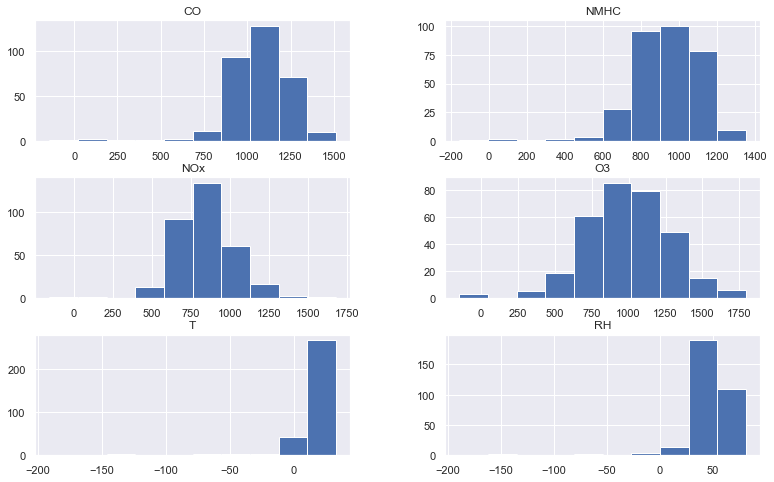

In [17]:
df_pivot.hist()
plt.show()

- We observe that the distribution of Temperature and Relative Humidity is negatively skewed, due to the outlier values
- The distribution of NOx and O3 appear to be more symmetrical
- Distribution of CO and NMHC is more negatively skewed, due to there being some outlier values.

### Outlier Analysis

From our previous analysis, we noted the presense of outliers in all numerical features. We had already come to a few conclusions based on our background research:
- These values are unnatural, and are impossible occurances in real life:
    - The freezing outlier temps are too cold for Italy's, and even too cold for the Artic
    - It is impossible for relative humidity to be negative
    - The sensors used to collect the data, are not rated for these extreme outlier temperatures/humdity
    - A negative concentration (which is what the sensors are trying to estimate), is also ridiculous. 
- Thus, we hypothesise that these come as a result of sensor calibration errors, resulting in a wrong sensor reading.

To test this hypothesis, we want to answer a few questions:
1. How many of these extreme outliers are there?
2. When do these outliers happen? Do they happen indepedently, or is there some pattern to the outlier data?

For this, we will use Tukey's Fences to denote any outliers. Recall that by this criterion, an outlier is any data that founds outside the range $[Q_1 - k(Q_3 - Q_1), Q_3 + k(Q_3 - Q_1)]$. We use Tukey's Fences, as this method is applicable to skewed data since it makes no distributional assumptions and it does not depend on a mean or standard 
deviation. In this case, we will look at the extreme outliers, setting $k=3$. We will also mark negative RH and Value as outliers, since in the context here, they are definitely wrong.

We also need to take note that for time series data, we cannot use future information to detect past outliers. Hence, we will detect outliers on a rolling basis.

In [18]:
df_outliers = df_pivot.copy(deep=True)

In [19]:
def mark_outliers(df, col, k=1.5, window=7):
    df_col = df[col].rolling(window)
    upper_quartile = df_col.quantile(.75)
    lower_quartile = df_col.quantile(.25)
    interquartille_range = upper_quartile - lower_quartile
    upper_fence = upper_quartile + (k * interquartille_range)
    lower_fence = lower_quartile - (k * interquartille_range)
    outliers = ~(df[col].between(lower_fence, upper_fence))
    return outliers

Our current outlier detection method also may miss out certain anomalies.

We want to ensure that any 'impossible' values are marked as outliers. These are values which could not possibly be 0, or are actually out of the operating range for the sensor, and thus the result may not be reliable.

In [20]:
additional_outlier_rules = {
        col : df_outliers[col] < 0 for col in ('CO', 'NMHC', 'NOx', 'O3')
} | {
    "T" : (df_outliers['T'] < -20) | (df_outliers['T'] > 50),
    "RH" : (df_outliers['RH'] < 10) | (df_outliers['RH'] > 90)
}

In [21]:
for col in df_outliers.columns:
    outliers = mark_outliers(df_outliers, col, k=3, window=7) # 1 Week Window
    df_outliers[f'Outlier ({col})'] = (outliers) | (additional_outlier_rules[col])
    

In [22]:
df_outliers[filter(lambda x : x.startswith('Outlier'),df_outliers.columns)].any(axis=1).sum()

72

In [23]:
df_outliers[filter(lambda x : x.startswith('Outlier'),df_outliers.columns)].sum()

Gas
Outlier (CO)      43
Outlier (NMHC)    42
Outlier (NOx)     49
Outlier (O3)      41
Outlier (T)       57
Outlier (RH)      51
dtype: int64

There are 72 rows with at least one outlier in total. Since there are at least >40 outliers for each column, it suggests that most days with outliers have more than one attribute with an outlier.

#### Where are the outliers in the data?

In [24]:
def plot_outlier(df, col_name, ax):
    outliers = df_outliers[df_outliers[f'Outlier ({col_name})'] == True]
    print(f"Number of Outliers for {col}:", len(outliers))
    df_outliers.plot(y=col_name, title=f"Outlier Plot of {col_name}", ax = ax)
    ax.scatter(x=outliers.index, y=outliers[col_name], color='r')

Number of Outliers for CO: 43
Number of Outliers for NMHC: 42
Number of Outliers for NOx: 49
Number of Outliers for O3: 41
Number of Outliers for T: 57
Number of Outliers for RH: 51


C:\Users\tienc\AppData\Local\Temp/ipykernel_22164/3075534334.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


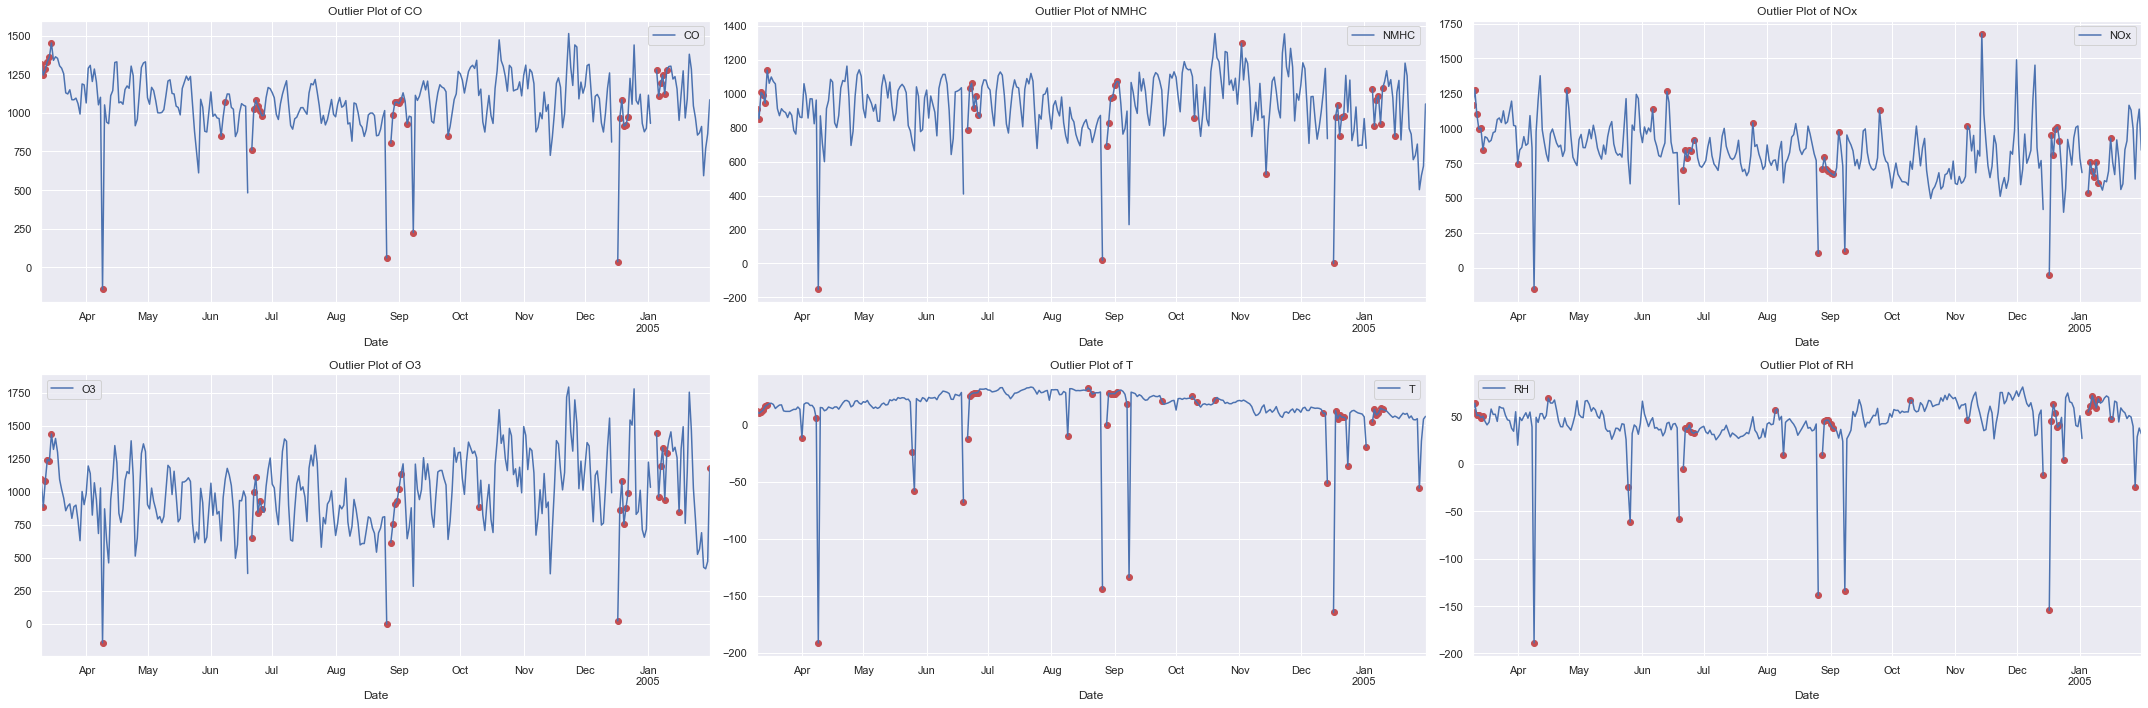

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(30, 10), tight_layout=True)

for ax, col in zip(axes.ravel(), df_pivot.columns):
    plot_outlier(df_outliers, col, ax)

fig.show()

- We note that the detected outliers appear to happen at similar points in time to outliers in other features

#### What should be done about outliers?

According to [research](https://iopscience.iop.org/article/10.1088/1757-899X/864/1/012152/pdf), when there are changes in the temperature and relative humidity, it causes a change in the resistance of the sensor, thus causing the readings to drift. This suggest that outside of the operating range of the sensors used (-20 to 50 degrees in Temp, and 10-90% relative humidity), the readings of the sensor would be less accurate. 

There are a few approaches we can take here:
- Ignore the outliers. But this is likely a bad idea, as at the very least, the outlier temperature and relative humidity are definitely wrong.
- Mark the outlier value, and  
    - Impute with the previous value
    - Impute with a rolling mean

For a start, we choose to ignore the extreme outliers, only cleaning the 'impossible' outliers first. 

In [26]:
df_outliers.sum(axis=0)

Gas
CO                345839.225691
NMHC              300331.479173
NOx               267736.069443
O3                321252.121517
T                   5016.252777
RH                 14278.582988
Outlier (CO)          43.000000
Outlier (NMHC)        42.000000
Outlier (NOx)         49.000000
Outlier (O3)          41.000000
Outlier (T)           57.000000
Outlier (RH)          51.000000
dtype: float64

In [27]:
df_basic_clean = df_pivot.copy(deep=True)
for col in df_basic_clean.columns:
    outliers = additional_outlier_rules[col]
    df_basic_clean.loc[outliers, col] = np.nan
print("Before:", df_basic_clean.isna().sum())
df_basic_clean = df_basic_clean.ffill().bfill()
print("After:", df_basic_clean.isna().sum())


Before: Gas
CO       7
NMHC     8
NOx      8
O3       8
T       16
RH      19
dtype: int64
After: Gas
CO      0
NMHC    0
NOx     0
O3      0
T       0
RH      0
dtype: int64


### Correlation
#### What are the relationships between the various variables?

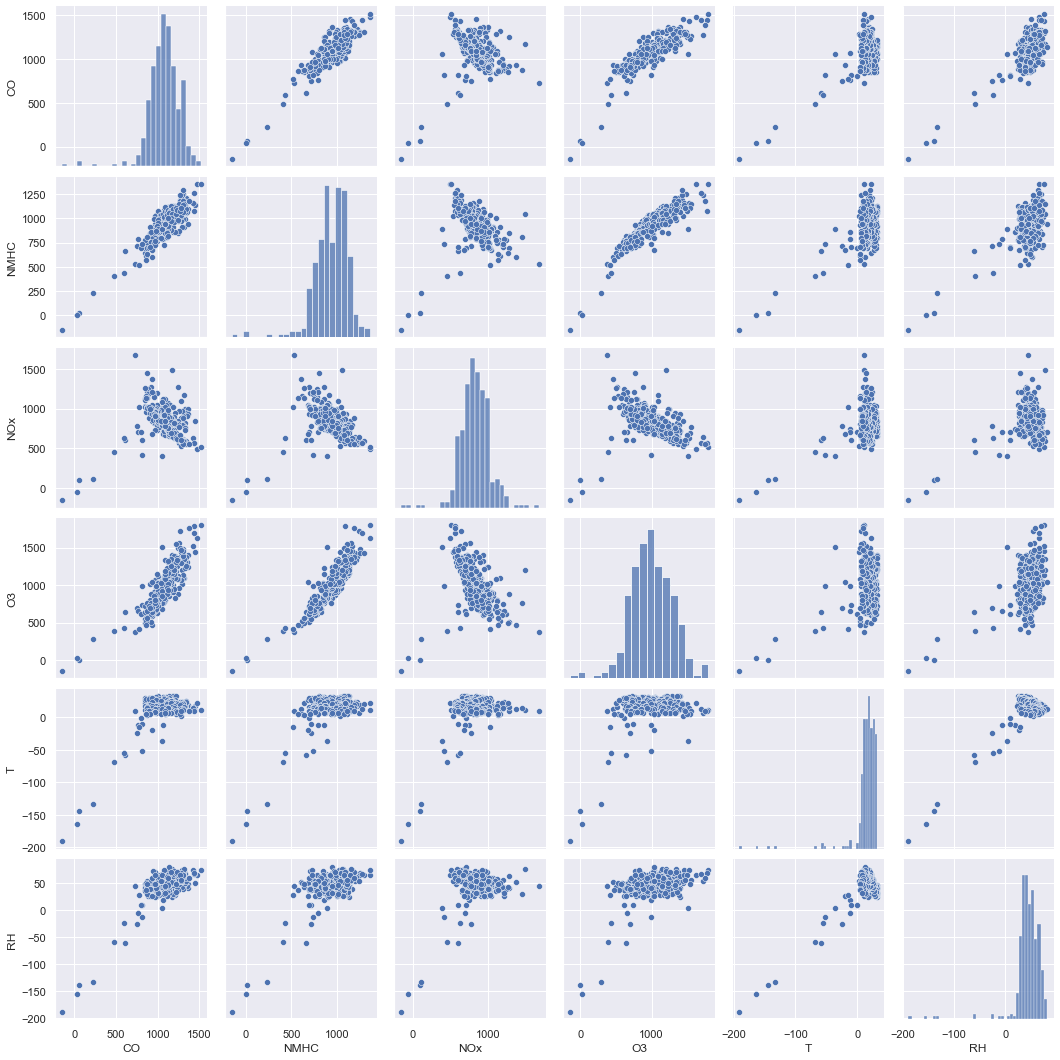

In [28]:
sns.pairplot(df_pivot)

We see that before we cleaned the data, there were many outliers, which do not follow the trend of the data.

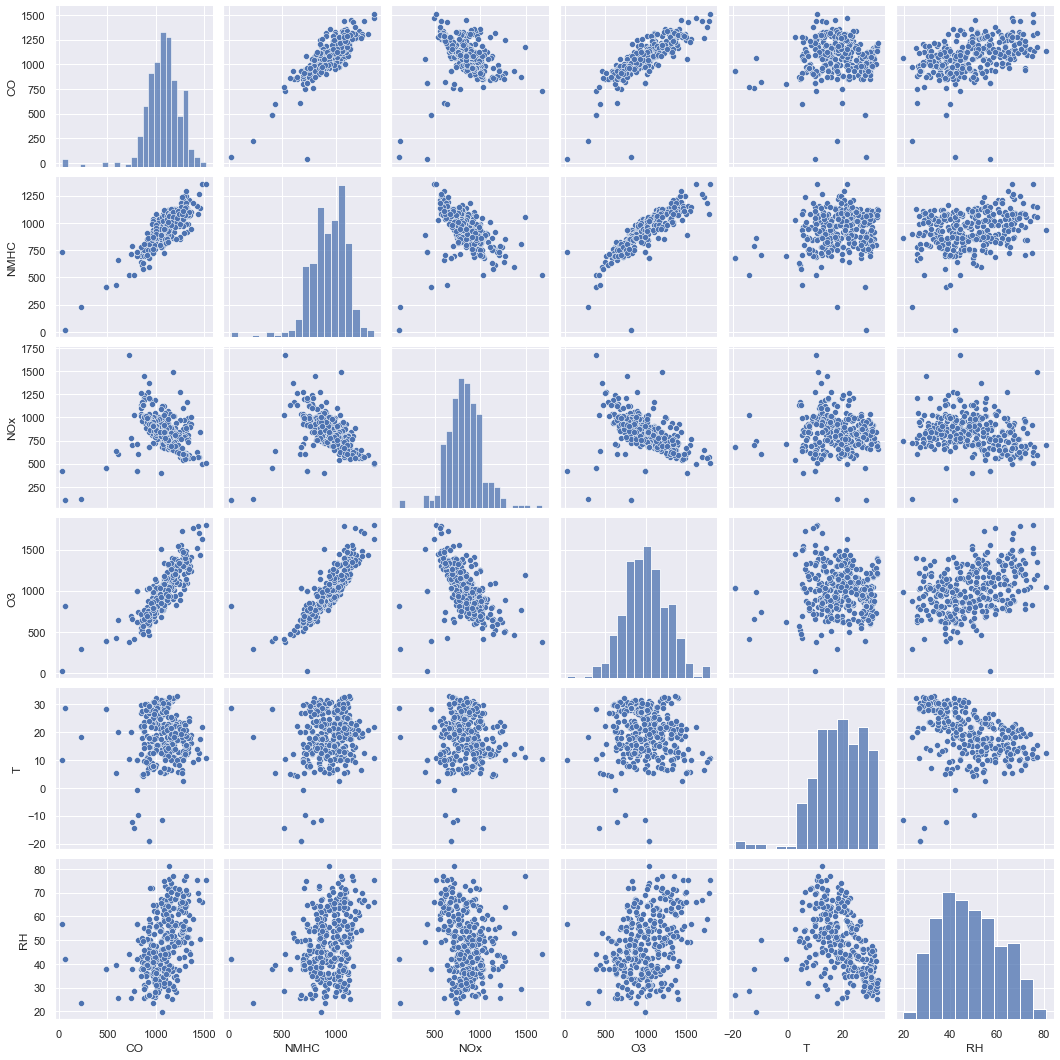

In [29]:
sns.pairplot(df_basic_clean)

To avoid recording spurious correlation (false correlation due to within-series dependence), we will instead calculate correlation based off the percentage change (the differenced data).

To calculate correlation, we use Pearson's correlation coefficient.

<AxesSubplot:xlabel='Gas', ylabel='Gas'>

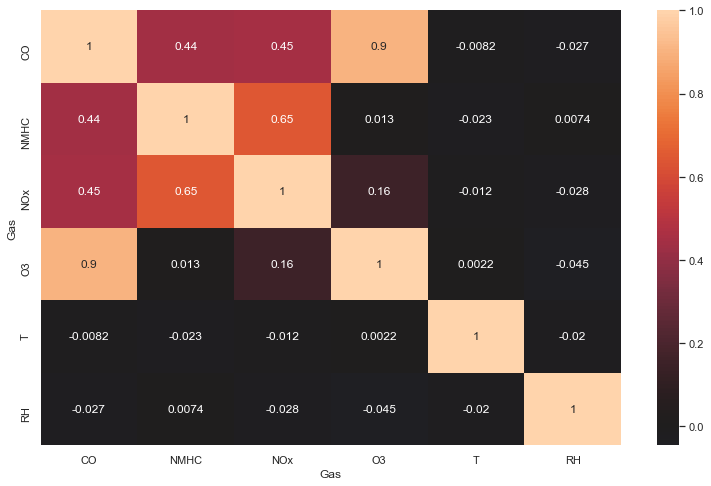

In [30]:
sns.heatmap(df_basic_clean.pct_change().corr(), annot=True, center=0)

- We observe that the change in CO levels is highly correlated with the change in Ozone (r=0.9) and NMHC (r=0.44) levels 

### Time Series

#### What can be said about the trend and seasonality of the data?

To have a clearer understanding of our data, we want to decompose the time series into it's components, which are: the Seasonal Component ($S_t$), the Trend-Cycle component ($T_t$), and the remainder components ($R_t$)

There are two ways which we can decompose our data, additively ($y_t = S_t + T_t + R_t$), or multiplicatively ($y_t = S_t \times T_t \times R_t$). Given that for most our our time series data (except that of Relative Humidity), the variance does not change as the mean changes, an additive model for decomposition makes the most sense. 

To decompose the data, we will use STL decomposition, due to it's advantages over classical decomposition methods. (it allows for the seasonal component to change over time, and is robust to outliers, which is important given that we showed earlier that unusual observations exist in the data). 

##### Temperature (T)

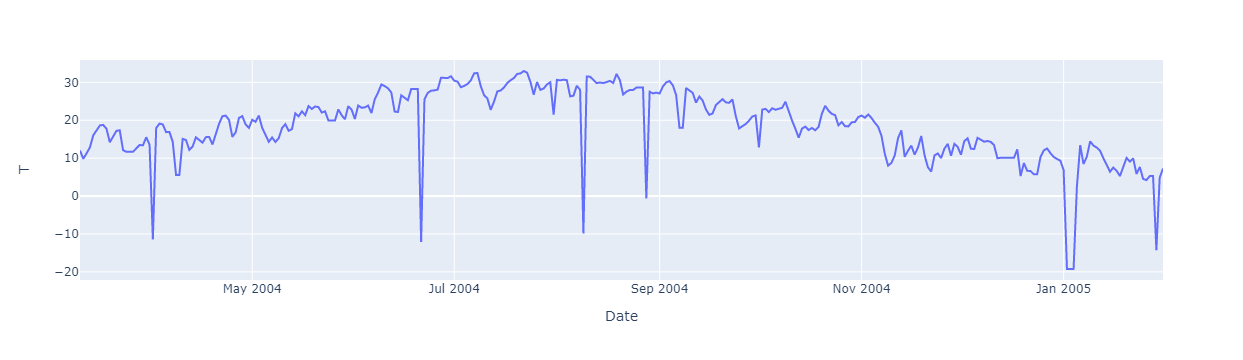

In [31]:
px.line(data_frame=df_basic_clean, y='T')

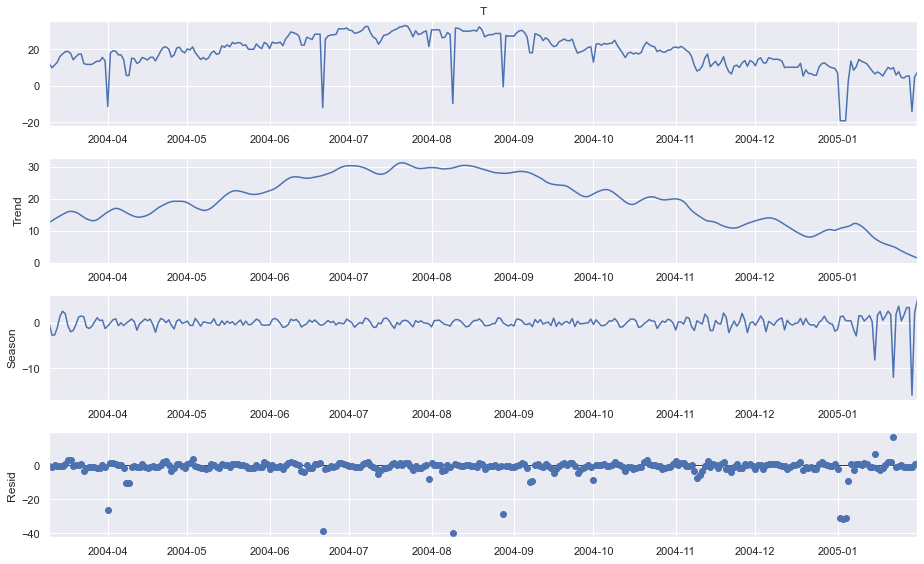

In [32]:
res = STL(df_basic_clean['T'], robust=True).fit()
res.plot()
plt.show()

- There is a upward non-linear trend in temperature from April to August, before the trend changes direction to become downwards. 
- The seasonality in the data does not appear to be very strong, and seems inconsistent.
- The temperature peaked between the months of June and September, where temperature was between 20 to 30 degrees celcius. The peak temperatures occured in July, where some days were above 30 degrees.
- The temperature is the lowest during the start of the year and near the end of the year, which are during the Winter season.
- The mean temperature does not remain constant through the year, but the variance appears to remain constant through the year.

##### Relative Humidity (RH)

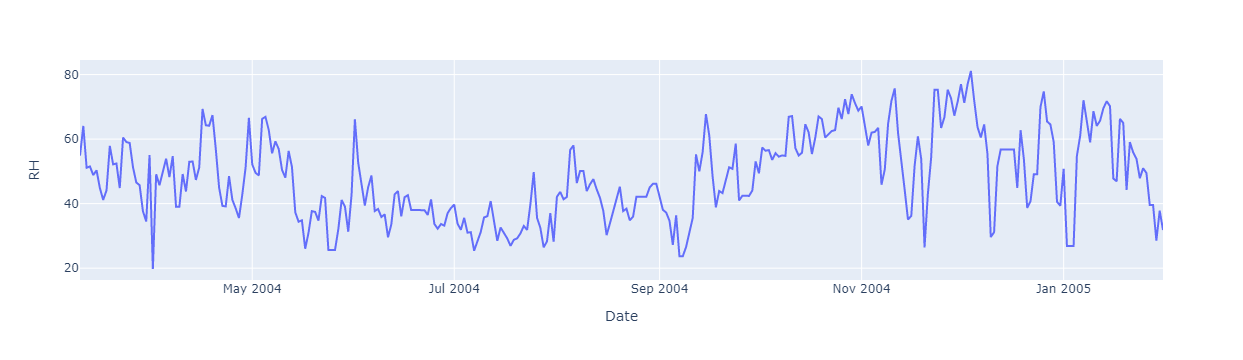

In [33]:
px.line(data_frame=df_basic_clean, y='RH')

We note that the variance of the relative humidity appears to increase when the relative humidity increases. This suggests a multiplicative decomposition of the data is appropriate. Since STL decomposition is only additive, we will use classical decomposition methods for this feature.

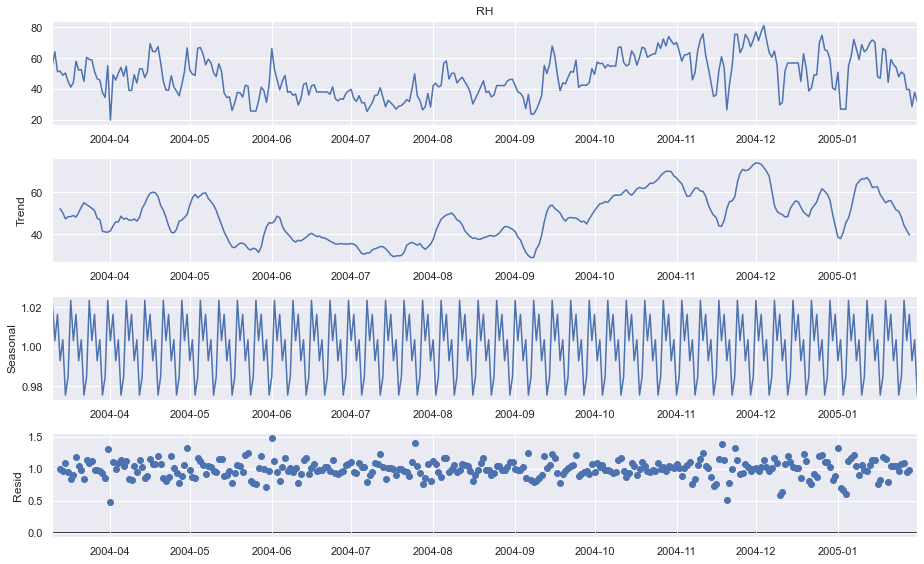

In [34]:
res = seasonal_decompose(df_basic_clean['RH'], 'multiplicative')
res.plot()
plt.show()

- There is a downward trend in relative humidity from April to August, before the trend changes direction to become downwards. The trend appears to be non-linear.
- It is clear that there is strong seasonality in the data, as even the trend appears to follow the seasonality after it is decomposed.
- The mean and variance of the relative humidity do not appear to be constant throughout the year, as the mean and variance of relative humidity appears to be lower during the months of June to September.
- This period of low humidity corresponds to a period of the highest temperatures of the year. This makes sense as **relative humidity is inversely proportional to temperature**
- Thus, the peak period of high relative humidity is also during the coldest parts of the year, during the end and the start of the year.

##### Carbon Monoxide (CO)

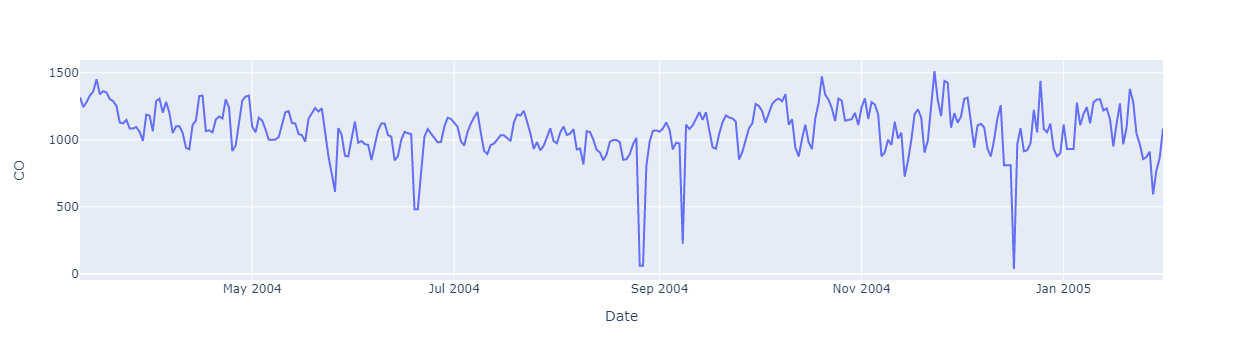

In [35]:
px.line(data_frame=df_basic_clean, y='CO')

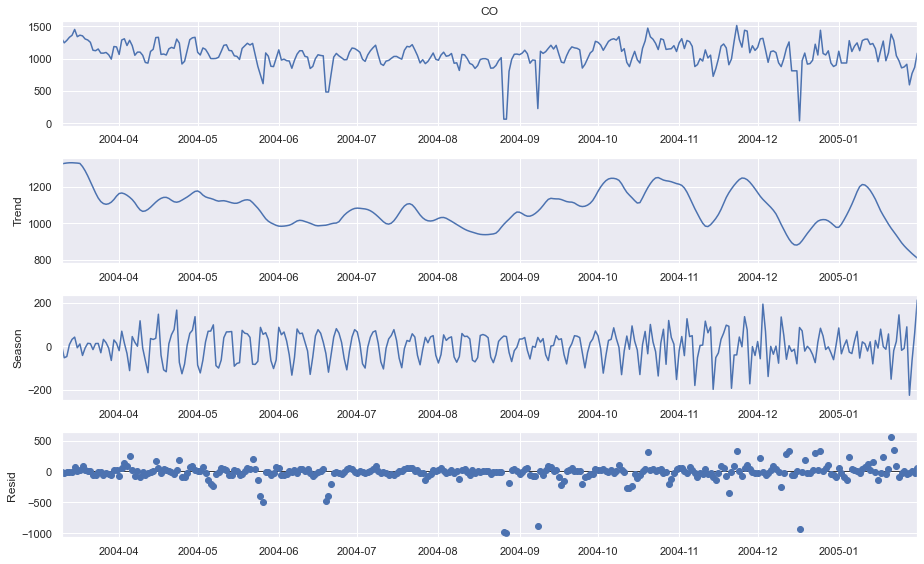

In [36]:
res = STL(df_basic_clean['CO'], robust=True).fit()
res.plot()
plt.show()

- The concentration of CO has a downward non-linear trend from April 2004 to August 2004, before changing direction to a upward trend from September 2004 to January 2005 (but the trend becomes weaker nearing the end of the year)
- There is a seasonality in the data, that appears to repeat every week, where the concentration rises and falls. This could correspond to increased edmissions during the weekdays compared to weekends.
- The concentration of Carbon Monoxide appears to have a constant mean and variance, suggesting that it is stationary.
- On Weekends, it seems that CO concentration is lower, but this requires further statistical testing to verify. This could potentially be due to human sources of CO like vehicle emissions being lower when people are not working, and thus commuting less. 

##### Non-methane Hydrocarbons (NMHC)

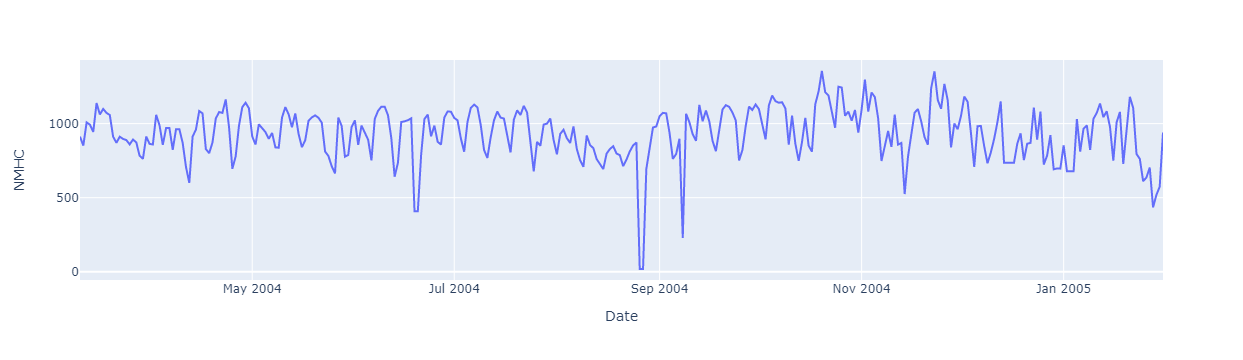

In [37]:
px.line(data_frame=df_basic_clean, y='NMHC')

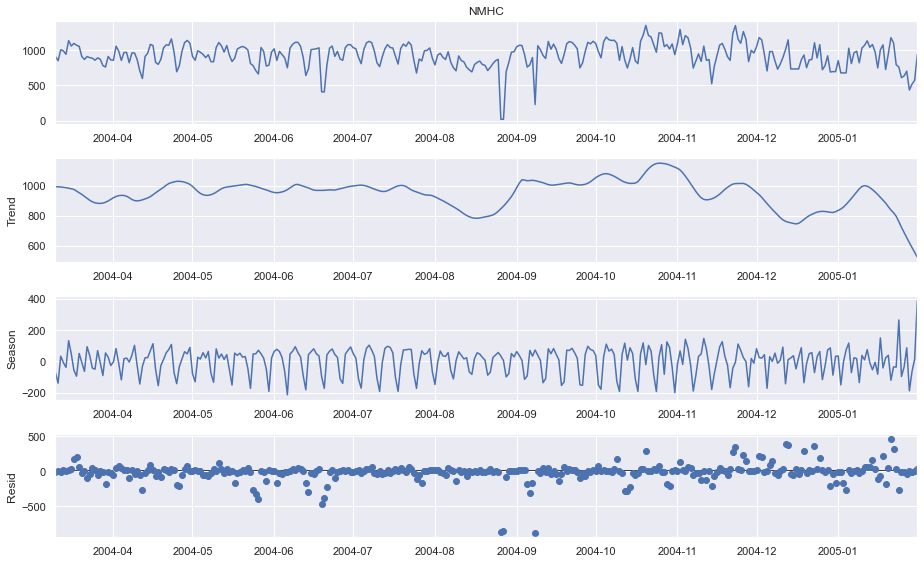

In [38]:
res = STL(df_basic_clean['NMHC'], robust=True).fit()
res.plot()
plt.show()

- The trend for NMHC is very weak, and does not appear to change significantly
- The seasonality is much stronger, with there being a cycle that seemingly corresponds to each week.
- Similarily to that for CO, emissions of NMHC appear to be much lower during the weekends.
- One reason for this is that NMHC is also emitted via human sources like vehicle exhaust, chemical manufacturing and energy production, which might decrease during the weekend, when there is less human activity.

##### Nitrogen Oxides

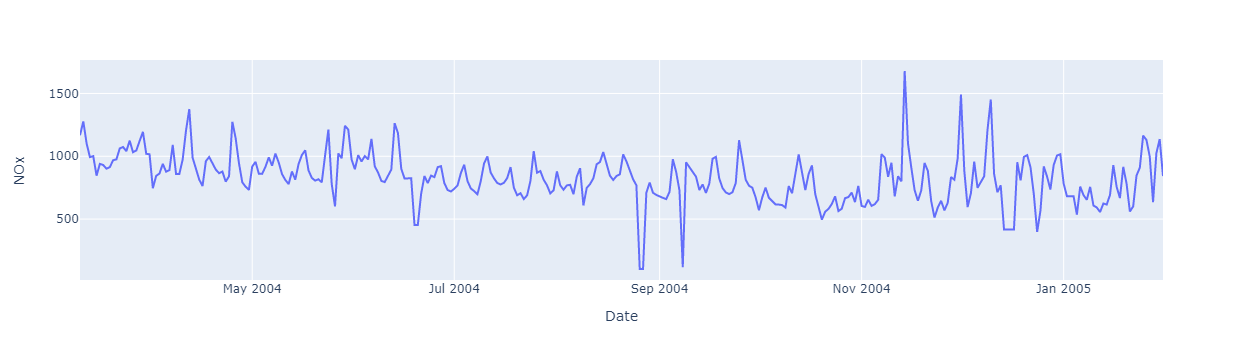

In [39]:
px.line(data_frame=df_basic_clean, y='NOx')

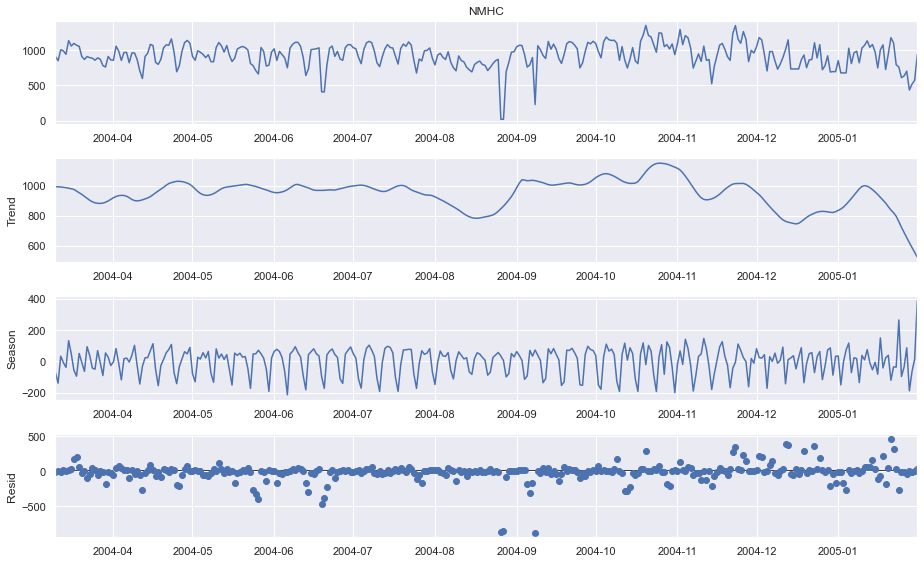

In [40]:
res = STL(df_basic_clean['NMHC'], robust=True).fit()
res.plot()
plt.show()

- For NOx concentrations, the time series does not appear to be stationary, as the mean and variance vary slightly
- There appears to be a small downward trend in the data
- There is a non-linear downward trend between April 2004 to November 2004, before changing directions to an upward trend from December 2004 to January 2001. This suggests that emissions of Nitrogen Oxides have been decreasing over time.
- This is corroborated by referencing the emission trend of Nitrogen oxides in Italy, where there has been a sharp decrease in NOx emissions fromm 2000 to 2018. [Source](https://www.statista.com/statistics/809161/nitrogen-oxides-nox-emission-trend-in-italy/)
- According to the European Environment Agency, this is due to the installation of catalysts to vehicles during this period as per new EU standards, resulting in lower NOx emissions from vehicles. (47% of the reduction in NOx emissions from 1990 and 2011 come from vehicle emissions)  [Source](https://www.eea.europa.eu/data-and-maps/indicators/eea-32-nitrogen-oxides-nox-emissions-1/assessment.2010-08-19.0140149032-3#:~:text=The%20sectors%20responsible%20for%20the,distribution%27%20(contributing%2027%25).)

##### Ozone (O3)

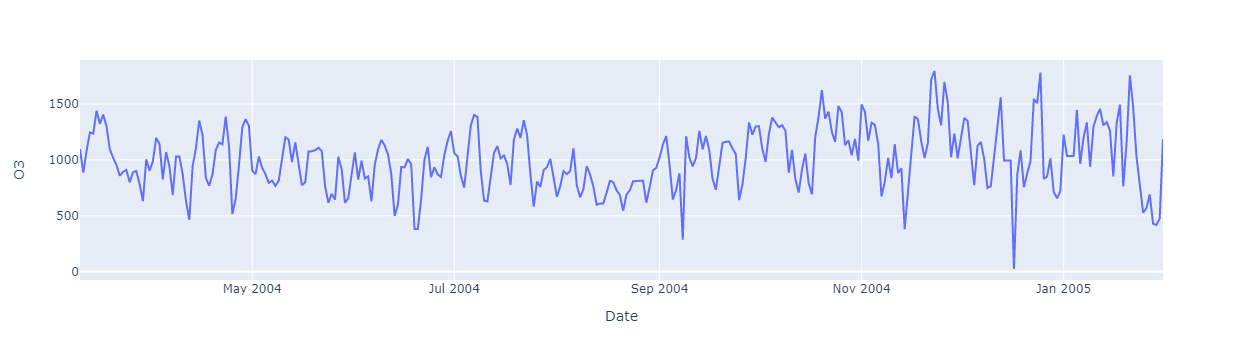

In [41]:
px.line(data_frame=df_basic_clean, y='O3')

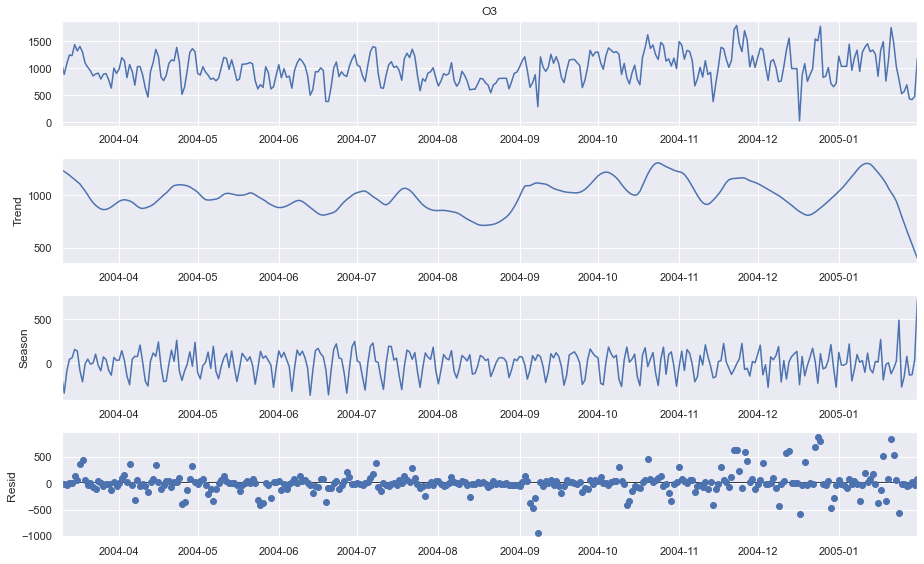

In [42]:
res = STL(df_basic_clean['O3'], robust=True).fit()
res.plot()
plt.show()

- The concentration of Ozone has a downward non-linear trend from April 2004 to August 2004, before changing direction to a upward trend from September 2004 to January 2005.
- The time series appears to have a constant mean, but there is some variation in the variance, such as during the start of the year.
- According to the US Environmental Protection Agency,ground level ozone, is not emitted directly into the air, but is created by chemical reactions between oxides of nitrogen (NOx) and volatile organic compounds (VOC). This happens when pollutants emitted by cars, power plants, industrial boilers, refineries, chemical plants, and other sources chemically react in the presence of sunlight.
- This may explain why the highest levels of Ozone are also the periods of time in which NOx levels are the highest (November to January)
- Strangely, this period is also very cold, and low temperatures should cause levels of Ozone to become lower. Hence it is likely that the increase in Ozone is due to the higher levels of NOx

##### Strength of Trend and Seasonality
It is useful for us to know how strong trend and seasonality are in our time series data, for later model selection and improvement.

[For strongly trended data, the seasonally adjusted data should have much more variation than the remainder component.](https://otexts.com/fpp2/seasonal-strength.html) Therefore $Var(R_t)/Var(T_t+R_t)$ should be relatively small. But for data with little or no trend, the two variances should be approximately the same. So the strength of trend is defined as
$$
F_t = \max (0, 1 - \frac{Var(R_t)}{Var(T_t + R_t)})
$$

Similarily, we define the strength of seasonality as
$$
F_s = \max (0, 1 - \frac{Var(R_t)}{Var(S_t + R_t)})
$$

In [43]:
trends, seasonality, residuals = [], [], []
for feature in df_basic_clean.columns:
    decomposition = STL(df_basic_clean[feature], robust=True).fit()
    trends.append(decomposition.trend)
    seasonality.append(decomposition.seasonal)
    residuals.append(decomposition.resid)

decompose_df = pd.DataFrame({
    "Var_Trend" : [trend.var() for trend in trends],
    "Var_Seasonality + Residual" : [(season + resid).var() for season, resid in zip(seasonality, residuals)],
    "Var_Trend + Residual" : [(trend + resid).var() for trend, resid in zip(trends, residuals)],
    "Var_Residuals":  [resid.var() for resid in residuals],
}, index = df_basic_clean.columns)
decompose_df['Trend Strength'] = decompose_df.apply(lambda feature : max(0, 1 - (feature['Var_Residuals'] / feature['Var_Trend + Residual'])), axis = 1)
decompose_df['Seasonal Strength'] = decompose_df.apply(lambda feature : max(0, 1 - (feature['Var_Residuals'] / feature['Var_Seasonality + Residual'])), axis = 1)

decompose_df

Var_Trend  Var_Seasonality + Residual  Var_Trend + Residual  \
Gas                                                                    
CO    10102.413936                23584.996228          35158.044584   
NMHC   9388.893215                23747.347272          26748.766489   
NOx   11085.555527                27198.962947          34876.283974   
O3    22094.398174                52172.255083          65342.591996   
T        56.985568                   27.794144             82.386004   
RH      118.949552                   66.441728            174.260273   

      Var_Residuals  Trend Strength  Seasonal Strength  
Gas                                                     
CO     21936.446830        0.376062           0.069898  
NMHC   18336.321271        0.314498           0.227858  
NOx    24251.980823        0.304628           0.108349  
O3     39294.674300        0.398636           0.246828  
T         27.205173        0.669784           0.021190  
RH        63.499944        0.635603           0.044276

- We see that out of all of the gases, Ozone has the strongest trend and Seasonality, whilst Carbon Monoxide has a strong trend but weak seasonality
- **No seasonal differencing** is recommended, as the strength of seasonality < 0.64 [Source: Forecasting Principles and Practices](https://otexts.com/fpp3/stationarity.html#unit-root-tests)

## Data Pre-processing
Now, we will proceed to process our data. This will involve transforming our data, and dealing with missing values and outliers.

In [44]:
def DataPreprocess(dataset, train = True, impute=True, remove_outliers=True, advanced_outlier_removal = False):
    dataset = dataset.copy(deep=True)
    missing_days = pd.isnull(dataset).any(axis=1)
    basic_outlier_rules = {
    "T" : (dataset['T'] < -20) | (dataset['T'] > 50),
    "RH" : (dataset['RH'] < 10) | (dataset['RH'] > 90)
}
    if remove_outliers:
        dataset.loc[basic_outlier_rules['T'], 'T'] = np.nan
        dataset.loc[basic_outlier_rules['RH'], 'RH'] = np.nan
        if train:
            additional_outlier_rules = {
            col : (dataset[col] < 0) for col in ('CO', 'NMHC', 'NOx', 'O3')
    } 
            for col in dataset.columns:
                if advanced_outlier_removal:
                    outliers = mark_outliers(dataset, col, k=3, window=7)
                    is_outlier = outliers
                    dataset.loc[is_outlier, col] = np.nan
                    print("No of Outliers (Advanced Rules) for", col, np.sum(is_outlier))
                else:
                    if col in additional_outlier_rules:
                        is_outlier = additional_outlier_rules[col]
                        dataset.loc[is_outlier, col] = np.nan
                        print("No of Outliers (Basic Filtering) for", col, np.sum(is_outlier))
                        dataset.loc[is_outlier, col] = np.nan
    if impute:
        dataset = dataset.interpolate(method='time', limit_direction='forward')
    if not train:
        return dataset, missing_days
    else:
        return dataset

            


In [45]:
df = pd.read_csv("train.csv", na_values=[-200])
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df.set_index("Date", inplace=True)
df_pivot = pd.pivot(df, values="Value", columns="Gas")
df_pivot[["T", "RH"]] = df[["T", "RH"]].groupby(df.index).mean()
df_pivot = df_pivot.asfreq("D")
train = DataPreprocess(df_pivot, train=True, remove_outliers=True, impute=True)
train

No of Outliers (Basic Filtering) for CO 1
No of Outliers (Basic Filtering) for NMHC 2
No of Outliers (Basic Filtering) for NOx 2
No of Outliers (Basic Filtering) for O3 2


Gas                  CO         NMHC          NOx           O3          T  \
Date                                                                        
2004-03-10  1316.500000   912.250000  1167.250000  1096.041667  12.020833   
2004-03-11  1244.062500   851.802083  1277.187500   885.031250   9.833333   
2004-03-12  1281.562500  1008.229167  1101.718750  1084.218750  11.292708   
2004-03-13  1330.555556   992.822917   993.159722  1245.781250  12.866319   
2004-03-14  1360.927083   943.854167  1001.104167  1234.177083  16.016667   
...                 ...          ...          ...          ...        ...   
2005-01-27   911.777778   703.312500   997.059028   691.475694   5.267708   
2005-01-28   592.864583   434.350694   635.225694   429.375000  -4.502604   
2005-01-29   769.625000   518.093750  1024.666667   418.072917 -14.272917   
2005-01-30   864.642361   573.684028  1136.718750   474.392361   4.848611   
2005-01-31  1084.500000   939.791667   842.177083  1184.166667   7.273958   

Gas                RH  
Date                   
2004-03-10  54.883334  
2004-03-11  64.069791  
2004-03-12  51.107292  
2004-03-13  51.530903  
2004-03-14  48.843750  
...               ...  
2005-01-27  39.614930  
2005-01-28  34.089236  
2005-01-29  28.563542  
2005-01-30  37.832986  
2005-01-31  31.809375  

[328 rows x 6 columns]

## Modelling

### Evaluation Methodology
To evaluate our models fairly, we will do a cross validated scoring of our models. This has to be done using the Time Series Splitter, as traditional k-fold cross validation will give a biased result, due to the time dependency in our data.

### Utility Functions

In [46]:
gases = ['CO', 'NMHC', 'NOx', 'O3']

In [47]:
def adf_test(series, significance_level = 0.05):
    print(f"Test for Stationarity\nSignificance Level: {significance_level}\nH0: There is a unit root (non-stationary time series)\nH1: There is no unit root (stationary time series)")
    test_statistic, pvalue, usedlag, *_ = adfuller(series)
    print(f"P-value: {pvalue:.3f}")
    print(f"Used Lag: {usedlag}")
    if pvalue < significance_level:
        print("Reject H0. There is evidence that the time series is stationary.")
    else:
        print("Fail to reject H0. There is insufficient evidence that the time series is stationary.")
    return test_statistic, pvalue, usedlag

In [48]:
def kpss_test(series, significance_level = 0.05):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        print(f"Test for Stationarity\nSignificance Level: {significance_level}\nH0: Process is trend stationary\nH1: There is a unit root (non-stationary)")
        test_statistic, pvalue, usedlag, *_ = kpss(series, regression="c", nlags="auto")
        print(f"P-value: {pvalue:.3f}")
        print(f"Used Lag: {usedlag}")
        if pvalue < significance_level:
            print("Reject H0. There is evidence that the time series is not stationary.")
        else:
            print("Fail to reject H0. There is insufficient evidence that the time series is not stationary.")
        return test_statistic, pvalue, usedlag

In [49]:
def multi_step_predict(model, existing_data, start, end, model_params = {}, test_exog = None):
    """
    Does multi-step time series prediction, where the model is refitted for every new prediction.
    """
    forecasts = []
    data = existing_data
    for date in pd.date_range(start, end):
        cur_model = model(data, **model_params).fit()
        try:
            if test_exog is not None:
                current_exog = test_exog.loc[:date]
                forecast = cur_model.predict(start=date, exog=current_exog).values[0]
            else:
                forecast = cur_model.predict(start=date).values[0]
        except:
            forecast = cur_model.get_prediction(start=date).predicted_mean.values[0]
        # forecast = cur_model.forecast(steps=1)
        forecasts.append(forecast)
        data.append(pd.Series(forecast))
    return forecasts, cur_model

In [396]:
def eval_model(model, dataset, model_params = {}, cv = TimeSeriesSplit(4), refit=False):
    """
    Function to evaluate a given model. It makes an assumption that the dataset that is passed to it is already pre-processed, or that the model will process it.
    It will return:
    - the model used
    - cross-validated metrics
    """
    if 'order' in model_params:
        order = model_params['order']
    else:
        order = (0, 0, 0)
    if 'exog' in model_params:
        exog = model_params['exog']
    # Cross validate
    cv_metrics = defaultdict(list)
    for train_idx, test_idx in cv.split(dataset):
        if 'exog' in model_params:
            train_exog = exog.iloc[train_idx]
            test_exog = exog.iloc[test_idx]
            model_params['exog'] = train_exog
        else:
            train_exog = None
            test_exog = None
        train_fold = dataset.iloc[train_idx]
        test_fold = dataset.iloc[test_idx]
        try:
            res = model(train_fold, **model_params).fit()
        except:
            res = model(train_fold,  initialization='approximate_diffuse',**model_params).fit()
        try:
            cv_metrics['Corrected AIC'].append(res.aicc)
        except Exception as Error:
            print(Error)
        try:
            if train_exog is not None:
                train_preds = res.predict(start=train_fold.index[0 + order[1]], end=train_fold.index[-1], exog=train_exog)
            else:
                train_preds= res.predict(start=train_fold.index[0 + order[1]], end=train_fold.index[-1])
        except:
            train_preds = res.get_prediction(start=train_fold.index[0 + order[1]], end=train_fold.index[-1], exog=train_exog).predicted_mean
        # train_preds = res.forecast(len(train_idx - order[1]))
        rmse_train = np.sqrt(mean_squared_error(train_fold[0 + order[1]:], train_preds))
        cv_metrics['Train RMSE'].append(rmse_train)
        if refit:
            test_preds, _ = multi_step_predict(model, train_fold, test_fold.index[0], test_fold.index[-1], model_params=model_params, test_exog=test_exog)
        else:
            try:
                if test_exog is not None:
                    test_preds = res.predict(start=test_fold.index[0], end=test_fold.index[-1], exog=test_exog)
                else:
                    test_preds = res.predict(start=test_fold.index[0], end=test_fold.index[-1])
            except:
                if test_exog is not None:
                    test_preds = res.get_prediction(start=test_fold.index[0], end=test_fold.index[-1], exog=test_exog).predicted_mean
                else:
                    test_preds = res.get_prediction(start=test_fold.index[0], end=test_fold.index[-1]).predicted_mean
        rmse_test = np.sqrt(mean_squared_error(test_fold, test_preds))
        cv_metrics['Test RMSE'].append(rmse_test)
        cv_metrics['Difference in RMSE'].append(rmse_train - rmse_test)

    # Refit Model to Entire Training Set and Get Corrected AIC
    if 'exog' in model_params:
        model_params['exog'] = exog
    final_model = model(dataset, **model_params).fit()
    try:
        cv_metrics['Final AICc'] = [final_model.aicc] * cv.get_n_splits()
    except Exception as Error:
        print(Error)
    return final_model, cv_metrics

In [51]:
def parse_results(dataframe):
    cols = [pd.DataFrame(dataframe[col]) for col in dataframe.keys()]
    return pd.concat(cols, axis=1, keys=dataframe.keys())

In [52]:
def generate_file_name(text, extension = "pkl", location = "models", date = False):
    cur_date = pd.to_datetime("now")
    if date:
        return f"{location}/{text}_{cur_date.year}-{cur_date.month}-{cur_date.day}-{cur_date.hour}-{cur_date.minute}-{cur_date.second}.{extension}"
    else:
        return f"{location}/{text}.{extension}"

In [53]:
def record_history(model_name, cv_metrics, gas, past_history = None, save_history = True):
    if past_history is None:
        if save_history is True and path.exists("history.csv"):
            past_history = pd.read_csv("history.csv", index_col=0)
        else:
            past_history = pd.DataFrame(columns=['Model Name', 'Mean Test RMSE', 'Difference in RMSE', 'Final AICc', 'Gas'])
    cur_result = pd.Series({
        "Model Name" : model_name,
        "Mean Test RMSE" : np.mean(cv_metrics['Test RMSE']),
        'Difference in RMSE' : np.mean(cv_metrics['Difference in RMSE']),
        "Final AICc" : np.mean(cv_metrics['Final AICc']),
        "Gas" : gas
    })
    history = past_history.append(cur_result, ignore_index=True)
    if save_history:
        history.to_csv("history.csv")
    return history

In [54]:
def ts_plot(data, lags=62):
    gs = gridspec.GridSpec(2, 2)

    fig = plt.figure(figsize=(15, 8))
    time_plot = fig.add_subplot(gs[0, :])
    time_plot.plot(data)
    time_plot.set_title("Time Plot")
    acf_plot = fig.add_subplot(gs[1, 0])
    plot_acf(data, ax = acf_plot, lags=lags)
    pacf_plot = fig.add_subplot(gs[1, 1])
    plot_pacf(data, ax = pacf_plot, lags=lags)

    return fig

### Models

#### Exponential Smoothing

In [55]:
Exp_Smoothing_Results = defaultdict(list)
file_names = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning) # Silence warning about initialization of model in future versions
    for gas in tqdm(gases):
        final_model, cv_metrics = eval_model(ExponentialSmoothing, train[gas], model_params= {
            "trend" : "add",
            "seasonal" : "add",
            "seasonal_periods" : 7
        })
        Exp_Smoothing_Results[gas] = cv_metrics
        file_name = generate_file_name(f"ExpSmoothingModel-{gas}", date=False, location="models/ExpSmoothing")
        file_names.append(file_name)
        final_model.save(file_name)
        history = record_history(f"ExpSmoothingModel-{gas}", cv_metrics, gas)
results = parse_results(Exp_Smoothing_Results).describe()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


##### Model Analysis

In [56]:
results.T

count         mean         std          min  \
CO   Corrected AIC         4.0  1644.639395  864.702455   653.278999   
     Train RMSE            4.0   125.971910   25.081572    98.710673   
     Test RMSE             4.0   356.688228  259.328337   154.603616   
     Difference in RMSE    4.0  -230.716318  245.753776  -591.170733   
     Final AICc            4.0  3352.278834    0.000000  3352.278834   
NMHC Corrected AIC         4.0  1632.116300  857.407185   649.820457   
     Train RMSE            4.0   121.448407   23.587454    96.232065   
     Test RMSE             4.0   265.926375  176.992382   122.054404   
     Difference in RMSE    4.0  -144.477968  165.748430  -380.802062   
     Final AICc            4.0  3288.206989    0.000000  3288.206989   
NOx  Corrected AIC         4.0  1669.325050  845.605620   688.095414   
     Train RMSE            4.0   140.347502    9.642304   127.510170   
     Test RMSE             4.0   263.253544  172.237143   138.765835   
     Difference in RMSE    4.0  -122.906042  166.942111  -370.722043   
     Final AICc            4.0  3378.137466    0.000000  3378.137466   
O3   Corrected AIC         4.0  1770.196998  872.546342   757.340637   
     Train RMSE            4.0   198.157953    9.776976   189.393458   
     Test RMSE             4.0   609.730374  577.255674   203.177272   
     Difference in RMSE    4.0  -411.572421  584.224148 -1264.806863   
     Final AICc            4.0  3589.365663    0.000000  3589.365663   

                                 25%          50%          75%          max  
CO   Corrected AIC       1121.174562  1641.690582  2165.155416  2641.897417  
     Train RMSE           107.723204   127.956597   146.205303   149.263774  
     Test RMSE            222.808127   267.896375   401.776475   736.356546  
     Difference in RMSE  -282.434487  -137.900798   -86.182629   -55.892943  
     Final AICc          3352.278834  3352.278834  3352.278834  3352.278834  
NMHC Corrected AIC       1112.639159  1628.558696  2148.035837  2621.527350  
     Train RMSE           103.971062   123.110750   140.588095   143.340064  
     Test RMSE            162.684217   210.589131   313.831290   520.472834  
     Difference in RMSE  -199.000551   -85.643735   -31.121152   -25.822339  
     Final AICc          3288.206989  3288.206989  3288.206989  3288.206989  
NOx  Corrected AIC       1174.359220  1670.133724  2165.099554  2648.937337  
     Train RMSE           135.665428   142.762935   147.445010   148.353967  
     Test RMSE            175.701401   198.192138   285.744281   517.864067  
     Difference in RMSE  -145.170890   -54.823231   -32.558383   -11.255665  
     Final AICc          3378.137466  3378.137466  3378.137466  3378.137466  
O3   Corrected AIC       1260.417305  1770.866348  2280.646041  2781.714660  
     Train RMSE           193.836528   195.537960   199.859384   212.162434  
     Test RMSE            259.399435   390.771951   741.102890  1454.200321  
     Difference in RMSE  -547.266362  -195.233992   -59.540051     8.985163  
     Final AICc          3589.365663  3589.365663  3589.365663  3589.365663

In [57]:
history

Model Name  Mean Test RMSE  Difference in RMSE   Final AICc  \
0    ExpSmoothingModel-CO      356.688228         -230.716318  3352.278834   
1  ExpSmoothingModel-NMHC      265.926375         -144.477968  3288.206989   
2   ExpSmoothingModel-NOx      263.253544         -122.906042  3378.137466   
3    ExpSmoothingModel-O3      609.730374         -411.572421  3589.365663   

    Gas  
0    CO  
1  NMHC  
2   NOx  
3    O3

- The Exponential Smoothing model for Ozone appears to perform the worse, with a cross-validated RMSE of 328

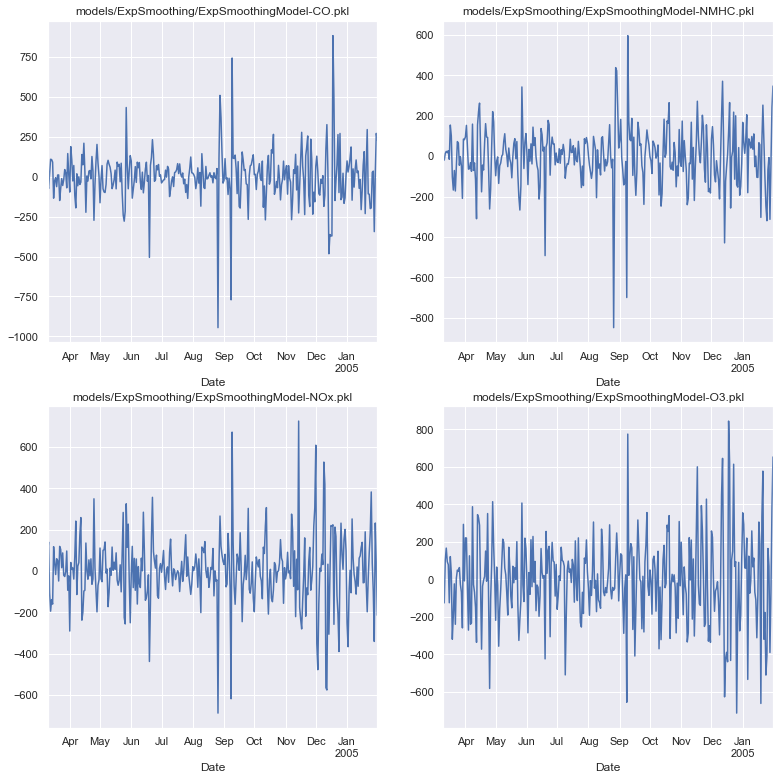

In [58]:
# Plot Residuals for Each Model
fig, ax = plt.subplots(2, 2, figsize=(13, 13))
models = [(load(file), file) for file in file_names]
for model, subplot in zip(models, ax.ravel()):
    model[0].resid.plot(ax=subplot)
    subplot.set_title(model[1])

For the most part, the residuals appear to be homoskedastic.

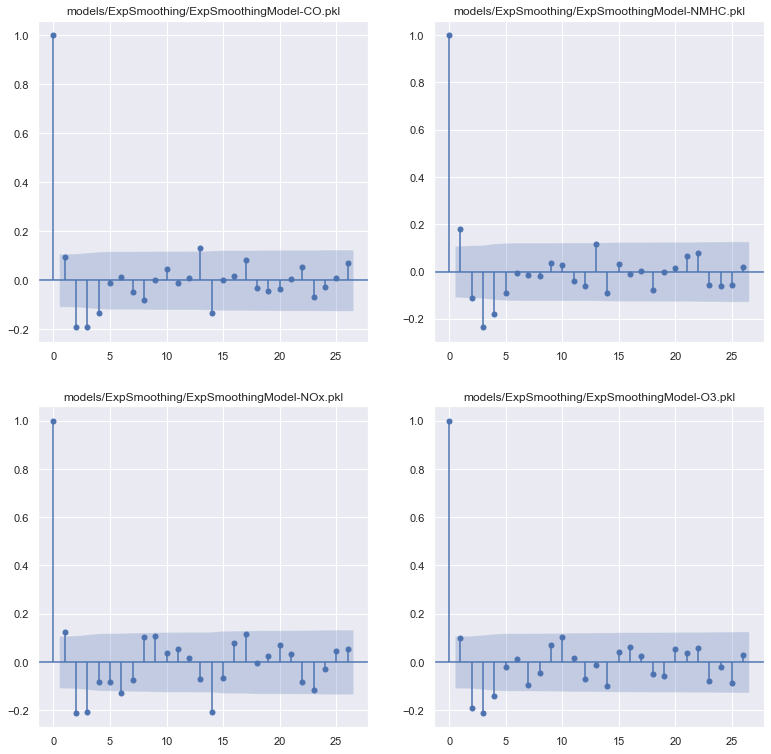

In [59]:
# Plot Autocorrelation of Residuals
fig, ax = plt.subplots(2, 2, figsize=(13, 13))
for model, subplot in zip(models, ax.ravel()):
    plot_acf(model[0].resid, ax=subplot)
    subplot.set_title(model[1])

An ACF plot of the residuals suggests that our forecasts can be improved as the model still does not account for some information, which is left over in the residuals

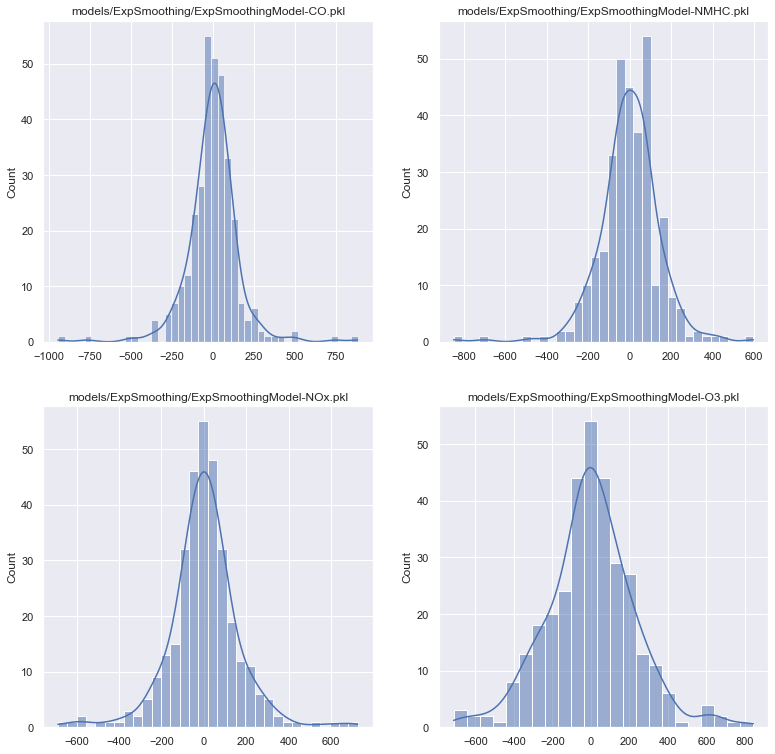

In [60]:
fig, ax = plt.subplots(2, 2, figsize=(13, 13))
for model, subplot in zip(models, ax.ravel()):
    sns.histplot(model[0].resid, ax=subplot, kde=True)
    subplot.set_title(model[1])

The residuals appear to be normally distributed. While not essential, it is preferable for this to be the case.

#### ARIMA

##### Is the Data Stationary?

Before we can engage in modelling, we need to check if our data satisfies certain statistical assumptions that may be made by our models (ARIMA models). This will inform us if further pre-processing is needed. (e.g Differencing is required for our data).

A stationary time series is one whose statistical properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. 

In general, a stationary time series will have no predictable patterns in the long-term. Time plots will show the series to be roughly horizontal (although some cyclic behaviour is possible), with constant variance.

[Source](https://otexts.com/fpp3/stationarity.html)

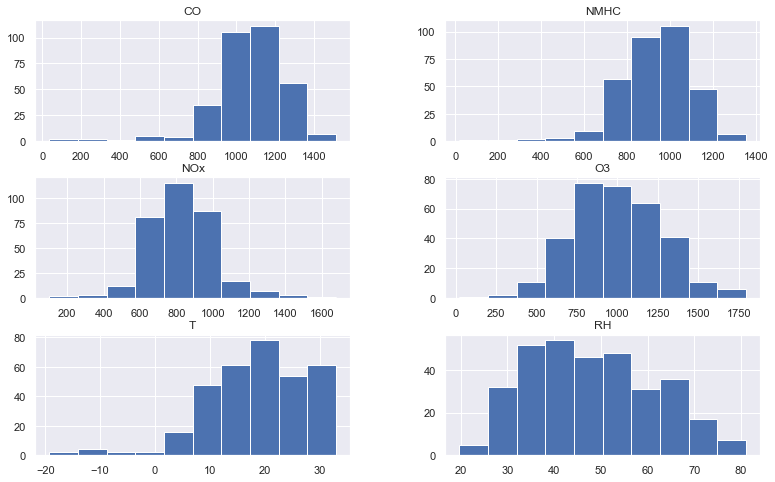

In [61]:
train.hist()
plt.show()

- On a first inspection, it appears that NOx is stationary. It is less clear if the rest are.

In [62]:
grp1 = train[:len(train) // 2]
grp2 = train[len(train) // 2:]

pd.concat([grp1.describe(), grp2.describe()], axis = 1, keys=["Grp1", "Grp2"]).T

count         mean         std         min         25%  \
     Gas                                                            
Grp1 CO    164.0  1071.233539  148.502711  481.753472  988.820313   
     NMHC  164.0   928.003525  131.248222  408.704861  845.799479   
     NOx   164.0   895.090024  147.592614  453.715278  796.906250   
     O3    164.0   938.729495  219.240231  382.131944  797.713542   
     T     164.0    21.844535    8.104707  -12.148958   16.668750   
     RH    164.0    42.783075   10.430817   19.742014   34.805469   
Grp2 CO    164.0  1070.028053  225.701653   36.281250  965.234375   
     NMHC  164.0   940.685086  201.612159   18.552083  819.289062   
     NOx   164.0   770.251524  203.675233  102.520833  644.192708   
     O3    164.0  1060.009527  316.176454   23.541667  829.388021   
     T     164.0    15.317867    8.511509  -19.247917   10.094531   
     RH    164.0    53.891071   13.337186   23.669792   43.834679   

                   50%          75%          max  
     Gas                                          
Grp1 CO    1059.015625  1158.091146  1452.010417  
     NMHC   930.397569  1034.760417  1163.041667  
     NOx    877.734375   975.135417  1376.031250  
     O3     931.322917  1087.466146  1439.041667  
     T       22.237847    28.783594    32.997917  
     RH      41.577952    49.856597    69.340625  
Grp2 CO    1110.880208  1205.656250  1513.208333  
     NMHC   963.611111  1084.477431  1355.104167  
     NOx    741.501736   884.520833  1678.687500  
     O3    1070.848958  1298.953993  1795.291667  
     T       14.696354    21.689323    30.365625  
     RH      54.857639    64.554427    81.104167

- The mean values for Grp 1 and 2 are similar for CO, NMHC, suggesting they are stationary

To tell more concretely if our data is stationary, we will conduct two tests, an Augmented Dickey Fuller Test, and a KPSS test.

###### ADF Test
ADF test is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not. The null and alternate hypothesis of this test are:

Null Hypothesis: The series has a unit root.

Alternate Hypothesis: The series has no unit root.

If the null hypothesis failed to be rejected, this test may provide evidence that the series is non-stationary.

[Reference: Statsmodels](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)


In [63]:
for feature in train.columns:
    print(feature)
    adf_test(train[feature])

CO
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.000
Used Lag: 1
Reject H0. There is evidence that the time series is stationary.
NMHC
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.032
Used Lag: 12
Reject H0. There is evidence that the time series is stationary.
NOx
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.000
Used Lag: 6
Reject H0. There is evidence that the time series is stationary.
O3
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.000
Used Lag: 8
Reject H0. There is evidence that the time series is stationary.
T
Test f

- According to the ADF test, all of the gas time series are stationary
- We observe that temperature does not appear to be stationary, but relative humidity is

##### Selecting the Order of the ARIMA Model

When using an ARIMA model, it is necessary to specify the order of the model -> p, d, q 

p = order of the Auto Regressive part of the model
d = degree of differencing
q = order of the Moving Average part

It is usually not possible to tell, simply from a time plot, what values of p and q are appropriate for the data. However, it is sometimes possible to use the ACF plot, and the closely related PACF plot, to determine appropriate values for p and q.

If the data are from an ARIMA(p, d,0) or ARIMA(0, d, q) model, then the ACF and PACF plots can be helpful in determining the value of p or q. If p and q are both positive, then the plots do not help in finding suitable values of p and q.

The data may follow an ARIMA(p, d,0) model if the ACF and PACF plots of the differenced data show the following patterns:

- the ACF is exponentially decaying or sinusoidal;
- there is a significant spike at lag p in the PACF, but none beyond lag p.

The data may follow an ARIMA(0,d,q) model if the ACF and PACF plots of the differenced data show the following patterns:

- the PACF is exponentially decaying or sinusoidal;
- there is a significant spike at lag q in the ACF, but none beyond lag q.

[Source](https://otexts.com/fpp3/non-seasonal-arima.html)

Hence, we will use the ACF and PACF plot to estimate the models for each gas, to use as a baseline. We will then fit the identified model, and check that the model residuals are white noise.

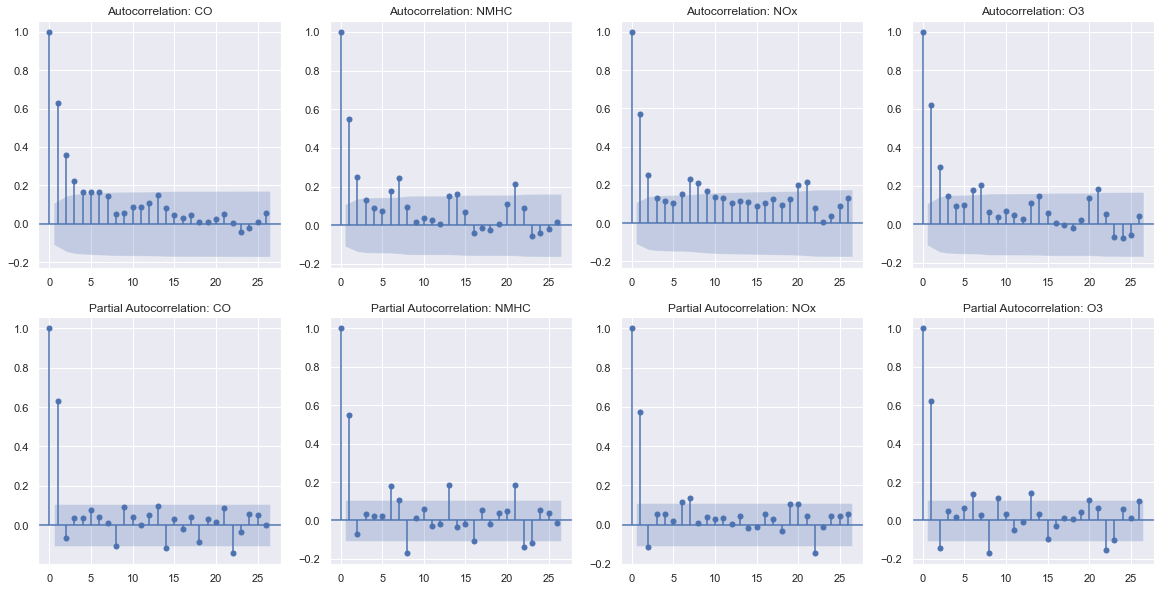

In [87]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))

for i, plot in enumerate([plot_acf, plot_pacf],0):
    for j, gas in enumerate(gases, 0):
        
        plot(train[gas], ax=ax[i,j])
        ax[i,j].set_title(ax[i,j].title._text + ': ' + gas)
    

| Gas | Order |
|-----|-------|
| CO  | 1,0,0 | 
| NMHC| 1,0,1 |
| NOx | 1,0,0 | 
| O3  | 1,0,2 |

In [179]:
ARIMA_Results = defaultdict(list)
file_names = []
orders = {
    "CO" : (1, 0, 0),
    "NMHC" : (1, 0, 1),
    "NOx" : (1, 0, 0),
    "O3" : (1, 0, 2)
}
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    for gas in tqdm(gases):
        order = orders[gas]
        final_model, cv_metrics = eval_model(ARIMA, train[gas], model_params = {'order' : order})
        ARIMA_Results[gas] = cv_metrics
        file_name = generate_file_name(f"ARIMA-{order}-{gas}", date=False, location="models/ARIMA")
        file_names.append(file_name)
        final_model.save(file_name)
        history = record_history(f"ARIMA-{order}-{gas}", cv_metrics, gas, past_history=history)
results = parse_results(ARIMA_Results).describe()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.62it/s]


##### Model Analysis

In [180]:
results.T

count         mean          std          min  \
CO   Corrected AIC         4.0  2075.660024  1092.792557   814.890360   
     Train RMSE            4.0   119.189853    22.365871    92.857931   
     Test RMSE             4.0   214.235618    19.711560   190.362954   
     Difference in RMSE    4.0   -95.045765    29.737202  -115.419028   
     Final AICc            4.0  4213.796890     0.000000  4213.796890   
NMHC Corrected AIC         4.0  2078.660197  1096.966043   814.198123   
     Train RMSE            4.0   118.493549    23.590489    90.109353   
     Test RMSE             4.0   183.656451    27.326491   145.660521   
     Difference in RMSE    4.0   -65.162901    23.410467   -97.669737   
     Final AICc            4.0  4188.780296     0.000000  4188.780296   
NOx  Corrected AIC         4.0  2095.759799  1090.393686   839.296022   
     Train RMSE            4.0   128.684558    15.338534   111.118106   
     Test RMSE             4.0   208.188353    20.769079   179.138046   
     Difference in RMSE    4.0   -79.503795    11.074087   -89.991348   
     Final AICc            4.0  4240.520784     0.000000  4240.520784   
O3   Corrected AIC         4.0  2198.507126  1126.337450   900.821762   
     Train RMSE            4.0   176.048159    10.735700   167.580074   
     Test RMSE             4.0   291.138357    76.119865   224.240609   
     Difference in RMSE    4.0  -115.090198    68.382075  -184.590985   
     Final AICc            4.0  4465.495576     0.000000  4465.495576   

                                 25%          50%          75%          max  
CO   Corrected AIC       1425.153286  2074.515663  2725.022401  3338.718409  
     Train RMSE           104.515261   122.581498   137.256091   138.738484  
     Test RMSE            203.798457   214.918182   225.355342   236.743154  
     Difference in RMSE  -113.723533  -106.569781   -87.892013   -51.624470  
     Final AICc          4213.796890  4213.796890  4213.796890  4213.796890  
NMHC Corrected AIC       1427.418881  2074.737335  2725.978651  3350.967993  
     Train RMSE           103.592060   122.358131   137.259620   139.148582  
     Test RMSE            172.968337   191.604624   202.292738   205.756033  
     Difference in RMSE   -72.798689   -60.029754   -52.393966   -42.922361  
     Final AICc          4188.780296  4188.780296  4188.780296  4188.780296  
NOx  Corrected AIC       1453.807239  2087.583188  2729.535747  3368.576799  
     Train RMSE           118.689548   129.338514   139.333524   144.943098  
     Test RMSE            201.638109   213.080176   219.630421   227.455015  
     Difference in RMSE   -88.441412   -80.001946   -71.064329   -68.019940  
     Final AICc          4240.520784  4240.520784  4240.520784  4240.520784  
O3   Corrected AIC       1541.101207  2186.072763  2843.478682  3521.061216  
     Train RMSE           169.498939   172.568086   179.117306   191.476390  
     Test RMSE            225.747573   290.362111   355.752894   359.588596  
     Difference in RMSE  -168.396199  -110.833879   -57.527878   -54.102048  
     Final AICc          4465.495576  4465.495576  4465.495576  4465.495576

In [181]:
history.sort_values(["Gas", "Mean Test RMSE"])

Model Name  Mean Test RMSE  Difference in RMSE   Final AICc  \
4      ARIMA-(1, 0, 0)-CO      214.235618          -95.045765  4213.796890   
0    ExpSmoothingModel-CO      356.688228         -230.716318  3352.278834   
5    ARIMA-(1, 0, 1)-NMHC      183.656451          -65.162901  4188.780296   
1  ExpSmoothingModel-NMHC      265.926375         -144.477968  3288.206989   
6     ARIMA-(1, 0, 0)-NOx      208.188353          -79.503795  4240.520784   
2   ExpSmoothingModel-NOx      263.253544         -122.906042  3378.137466   
7      ARIMA-(1, 0, 2)-O3      291.138357         -115.090198  4465.495576   
3    ExpSmoothingModel-O3      609.730374         -411.572421  3589.365663   

    Gas  
4    CO  
0    CO  
5  NMHC  
1  NMHC  
6   NOx  
2   NOx  
7    O3  
3    O3

In terms of RMSE, the ARIMA models all outperform the Exponential Smoothing Models.

In [182]:
%%capture 
# ^suppress output
models = [load(file) for file in file_names]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    diagnostics = [model.plot_diagnostics() for model in models]


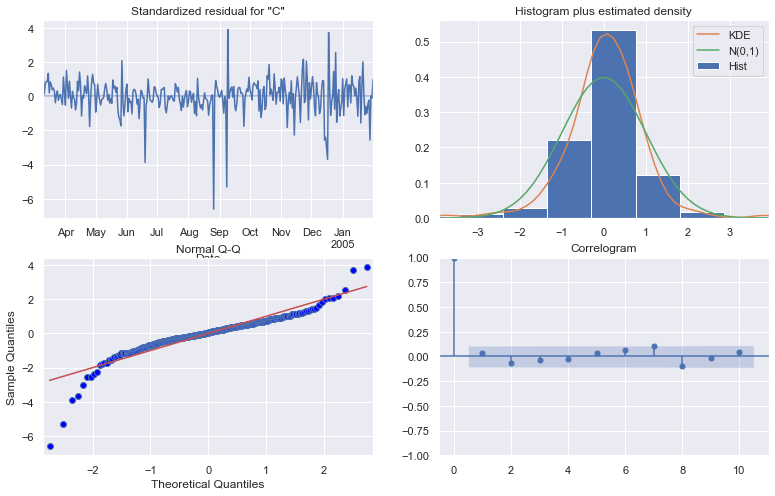

In [183]:
diagnostics[0]

- We observe from the Q-Q plot that the residuals are not normally distributed
- The correlogram does not show any significant correlation, except perhaps at Lag 7

In [184]:
models[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     CO   No. Observations:                  328
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2103.861
Date:                Fri, 13 Aug 2021   AIC                           4213.723
Time:                        12:47:48   BIC                           4225.102
Sample:                    03-10-2004   HQIC                          4218.263
                         - 01-31-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1070.6310     26.874     39.838      0.000    1017.958    1123.304
ar.L1          0.6317      0.025     25.173      0.000       0.582       0.681
sigma2      2.174e+04    807.941     26.909      0.000    2.02e+04    2.33e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):              1316.51
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               2.12   Skew:                            -1.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- We observe that all the coefficients in the ARIMA model for CO are significant.
- We note that the p-value obtained for the Ljung-Box test is 0.51, hence we would fail to reject the Null hypothesis of independently distributed residuals. Hence the residuals of this ARIMA model likely have no autocorrelation.

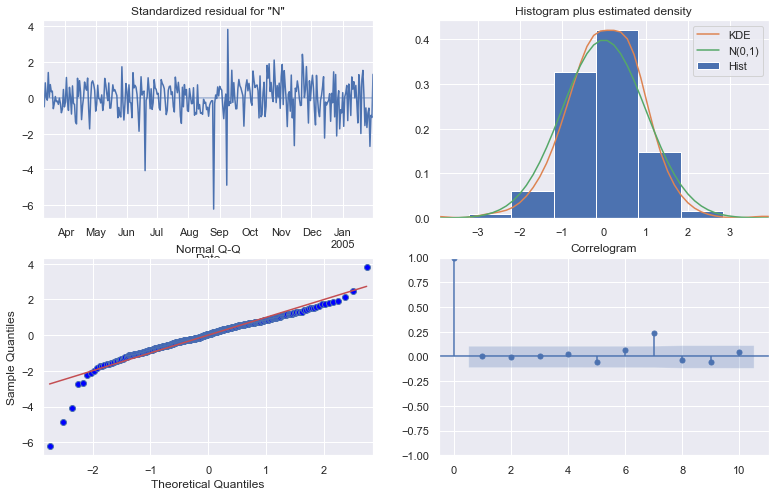

In [185]:
diagnostics[1]

- We observe that for NMHC:
    - Residuals are not normally distributed
    - There is significant correlation at Lag 7. This suggests that the ARIMA model fails to capture some sort of correlation that happens every week (i.e a seasonal pattern)

In [186]:
models[1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   NMHC   No. Observations:                  328
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2090.328
Date:                Fri, 13 Aug 2021   AIC                           4188.656
Time:                        12:47:57   BIC                           4203.829
Sample:                    03-10-2004   HQIC                          4194.710
                         - 01-31-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        934.3443     18.771     49.777      0.000     897.554     971.134
ar.L1          0.4456      0.111      4.007      0.000       0.228       0.664
ma.L1          0.1428      0.122      1.170      0.242      -0.096       0.382
sigma2      2.025e+04    918.167     22.058      0.000    1.85e+04    2.21e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               661.49
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.76   Skew:                            -1.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- The coefficient of the MA parameter does not appear to be significant.
- The significant p-value for the Ljung Box test confirms that our model produces residuals with significant autocorrelation

In [187]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    final_model, cv_metrics = eval_model(ARIMA, train['NMHC'], model_params = {'order' : (1, 0, 0)})
    history = record_history(f"ARIMA-(1 ,0, 0)-NMHC", cv_metrics, 'NMHC', past_history=history)
    print("Mean Test RMSE", np.mean(cv_metrics['Test RMSE']))
    display(final_model.summary())

Mean Test RMSE 183.695231346218


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   NMHC   No. Observations:                  328
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2091.259
Date:                Fri, 13 Aug 2021   AIC                           4188.517
Time:                        12:48:00   BIC                           4199.896
Sample:                    03-10-2004   HQIC                          4193.057
                         - 01-31-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        934.3443     19.717     47.388      0.000     895.700     972.988
ar.L1          0.5454      0.041     13.165      0.000       0.464       0.627
sigma2      2.024e+04    885.197     22.869      0.000    1.85e+04     2.2e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):               598.49
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               1.67   Skew:                            -1.20
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [188]:
history[history['Gas'] == 'NMHC']

Model Name  Mean Test RMSE  Difference in RMSE   Final AICc  \
1  ExpSmoothingModel-NMHC      265.926375         -144.477968  3288.206989   
5    ARIMA-(1, 0, 1)-NMHC      183.656451          -65.162901  4188.780296   
8    ARIMA-(1 ,0, 0)-NMHC      183.695231          -61.109540  4188.591376   

    Gas  
1  NMHC  
5  NMHC  
8  NMHC

We see that removing the MA term makes our model more robust, reducing its variance.

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



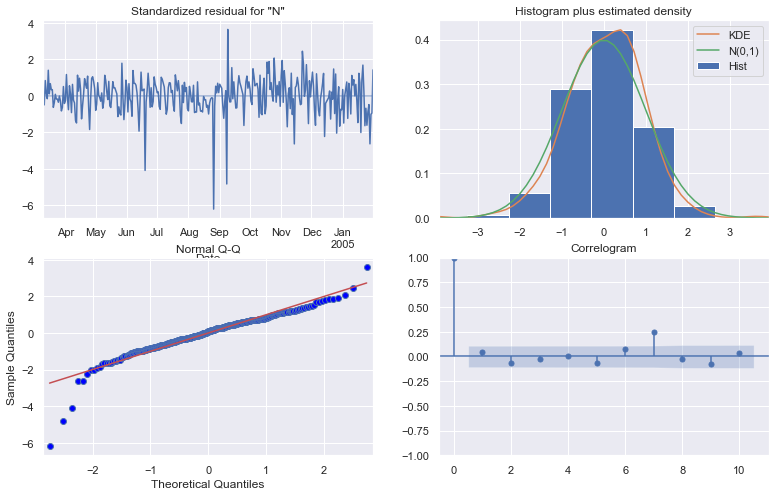

In [189]:
fig = final_model.plot_diagnostics()

We find that removing the MA term helps our model out. Although there is still a significant spike at Lag 7 of the residuals, we see that we fail to reject the null hypothesis for the Ljung-Box test

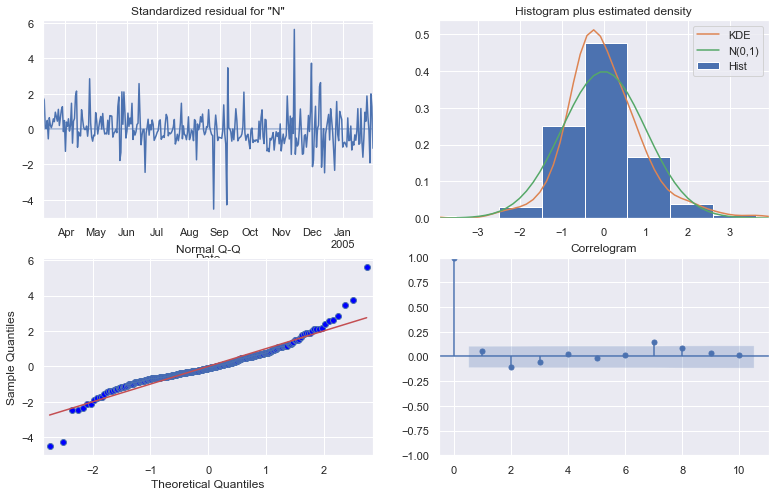

In [104]:
diagnostics[2]

- The residuals for NOx are certainly not normally distributed
- The correlogram shows a spike at Lag 7, suggesting that there is some seasonality in our data at weekly intervals.

In [107]:
models[2].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    NOx   No. Observations:                  328
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2117.223
Date:                Fri, 13 Aug 2021   AIC                           4240.447
Time:                        11:52:58   BIC                           4251.826
Sample:                    03-10-2004   HQIC                          4244.987
                         - 01-31-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        832.6708     20.041     41.548      0.000     793.391     871.951
ar.L1          0.5763      0.035     16.285      0.000       0.507       0.646
sigma2      2.348e+04    970.359     24.202      0.000    2.16e+04    2.54e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.15   Jarque-Bera (JB):               407.50
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):               1.88   Skew:                             0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- We observe that all the coefficients in the ARIMA model for NOx are significant.
- We note that the p-value obtained for the Ljung-Box test is 0.28, hence we would fail to reject the null hypothesis of no autocorrelation in the residuals if we had a significance level of 0.05.

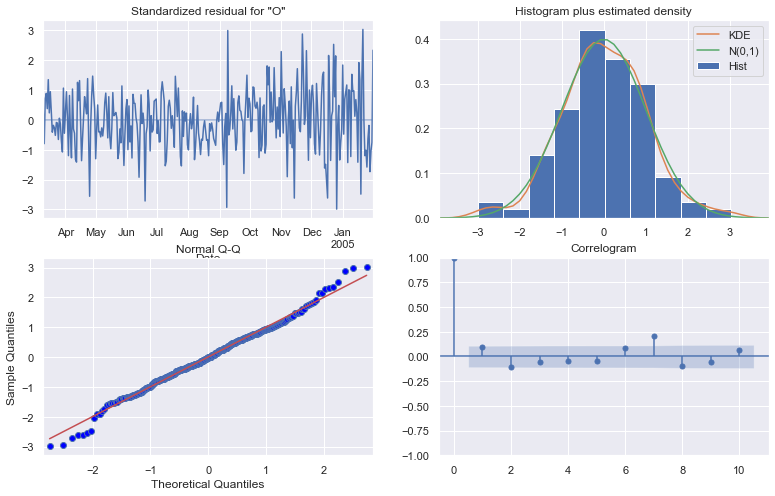

In [79]:
diagnostics[3]

- We observe that the residuals are mostly normally distributed
- There is one significant correlation at Lag 7, suggesting the ARIMA model does not account for seasonality that occurs on a weekly basis
- There is also a smaller correlation at Lag 2

In [80]:
models[3].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     O3   No. Observations:                  328
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2231.769
Date:                Fri, 13 Aug 2021   AIC                           4469.537
Time:                        00:11:05   BIC                           4480.916
Sample:                    03-10-2004   HQIC                          4474.077
                         - 01-31-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        999.3695     31.654     31.572      0.000     937.329    1061.410
ar.L1          0.6189      0.036     17.044      0.000       0.548       0.690
sigma2      4.765e+04   3364.119     14.165      0.000    4.11e+04    5.42e+04
===================================================================================
Ljung-Box (L1) (Q):                   2.93   Jarque-Bera (JB):                 3.95
Prob(Q):                              0.09   Prob(JB):                         0.14
Heteroskedasticity (H):               2.39   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- We observe that all the coefficients in the ARIMA model for O3 are significant.
- We note that the p-value obtained for the Ljung-Box test is 0.09, hence we would fail to reject the null hypothesis of no autocorrelation in the residuals if we had a significance level of 0.05.

#### SARIMA

##### Identifying Seasonal Orders

The seasonal part of the model consists of terms that are similar to the non-seasonal components of the model, but involve backshifts of the seasonal period.

The seasonal part of an AR or MA model will be seen in the seasonal lags of the PACF and ACF. For example, an ARIMA(0,0,0)(0,0,1,12) model will show:

- a spike at lag 12 in the ACF but no other significant spikes;
- exponential decay in the seasonal lags of the PACF (i.e., at lags 12, 24, 36, …).

Similarly, an ARIMA(0,0,0)(1,0,0,12) model will show:

- exponential decay in the seasonal lags of the ACF;
- a single significant spike at lag 12 in the PACF.

In considering the appropriate seasonal orders for a seasonal ARIMA model, restrict attention to the seasonal lags.

From our EDA, we discovered that we should not seasonally difference our data, as our data does not have strong seasonality ($F_s < 0.64$)

From our seasonal decomposition and analysis of the ADF and PACF, we know that the seasonal period is 7

In [115]:
seasonal_lags = [i*7 for i in range(15)]

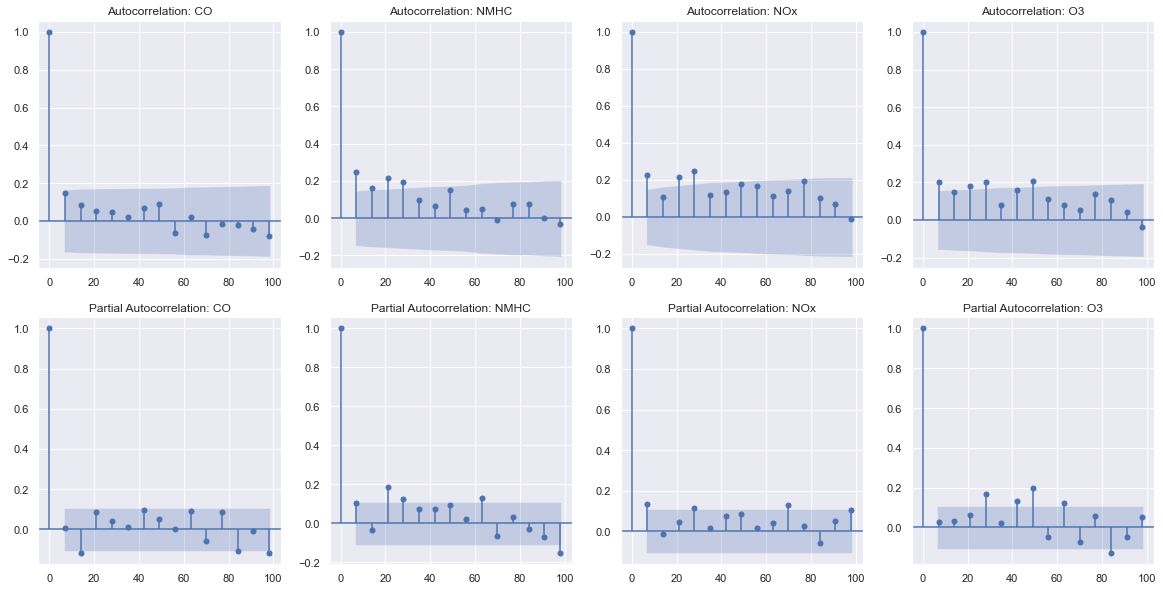

In [116]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))

for i, plot in enumerate([plot_acf, plot_pacf],0):
    for j, gas in enumerate(gases, 0):
        
        plot(train[gas], ax=ax[i,j], lags=seasonal_lags)
        ax[i,j].set_title(ax[i,j].title._text + ': ' + gas)

In [110]:
history

Model Name  Mean Test RMSE  Difference in RMSE   Final AICc  \
0    ExpSmoothingModel-CO      356.688228         -230.716318  3352.278834   
1  ExpSmoothingModel-NMHC      265.926375         -144.477968  3288.206989   
2   ExpSmoothingModel-NOx      263.253544         -122.906042  3378.137466   
3    ExpSmoothingModel-O3      609.730374         -411.572421  3589.365663   
4      ARIMA-(1, 0, 0)-CO      214.235618          -95.045765  4213.796890   
5    ARIMA-(1, 0, 1)-NMHC      183.656451          -65.162901  4188.780296   
6     ARIMA-(1, 0, 0)-NOx      208.188353          -79.503795  4240.520784   
7      ARIMA-(1, 0, 2)-O3      291.138357         -115.090198  4465.495576   
8    ARIMA-(1 ,0, 0)-NMHC      183.695231          -61.109540  4188.591376   

    Gas  
0    CO  
1  NMHC  
2   NOx  
3    O3  
4    CO  
5  NMHC  
6   NOx  
7    O3  
8  NMHC

| Gas | Order | Seasonal Order |
|-----|-------|----------------|
| CO  | 1,0,0 | 2,0,0,7        |
| NMHC| 1,0,0 | 3,0,0,7        |
| NOx | 1,0,0 | 1,0,4,7        |
| O3  | 1,0,2 | 7,0,7,7        |

In [190]:
seasonal_orders = {
    "CO" : (2, 0, 0, 7),
    "NMHC" :  (3, 0, 0, 7),
    "NOx" :  (1, 0, 4, 7),
    "O3" :  (7, 0, 7, 7)
}
orders = {
    "CO" : (1, 0, 0),
    "NMHC" : (1, 0, 0),
    "NOx" : (1, 0, 0),
    "O3" : (1, 0, 2)
}
SARIMA_Results = defaultdict(list)
file_names = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for gas in tqdm(gases):
        order = orders[gas]
        seasonal_order = seasonal_orders[gas] if gas in seasonal_orders else None
        final_model, cv_metrics = eval_model(SARIMAX, train[gas], model_params = {'order' : order, 'seasonal_order' : seasonal_order })
        SARIMA_Results[gas] = cv_metrics
        file_name = generate_file_name(f"SARIMA-{order}-{seasonal_order}-{gas}", date=False, location="models/SARIMA")
        file_names.append(file_name)
        final_model.save(file_name)
        history = record_history(f"SARIMA-{order}-{seasonal_order}-{gas}", cv_metrics, gas, past_history=history)
results = parse_results(SARIMA_Results).describe()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.55s/it]


##### Model Analysis

In [191]:
results.T

count         mean          std          min  \
CO   Corrected AIC         4.0  2109.146785  1109.994319   830.698119   
     Train RMSE            4.0   173.900955    11.270065   160.836301   
     Test RMSE             4.0   271.477149    49.885185   222.931685   
     Difference in RMSE    4.0   -97.576194    51.448146  -150.171479   
     Final AICc            4.0  4279.856174     0.000000  4279.856174   
NMHC Corrected AIC         4.0  2098.352647  1100.718523   831.433099   
     Train RMSE            4.0   152.969096     9.433801   144.220738   
     Test RMSE             4.0   265.825781   118.226093   189.137136   
     Difference in RMSE    4.0  -112.856685   122.512878  -295.322442   
     Final AICc            4.0  4232.652146     0.000000  4232.652146   
NOx  Corrected AIC         4.0  2109.543442  1081.548649   859.480056   
     Train RMSE            4.0   166.309323    10.682799   158.072946   
     Test RMSE             4.0   187.794621    29.481269   163.948400   
     Difference in RMSE    4.0   -21.485298    36.407897   -70.186093   
     Final AICc            4.0  4246.902803     0.000000  4246.902803   
O3   Corrected AIC         4.0  2215.388685  1107.171333   943.406491   
     Train RMSE            4.0   190.029034    14.710500   178.997720   
     Test RMSE             4.0   341.078500   157.580894   228.148098   
     Difference in RMSE    4.0  -151.049466   163.666900  -379.415063   
     Final AICc            4.0  4464.191830     0.000000  4464.191830   

                                 25%          50%          75%          max  
CO   Corrected AIC       1445.227401  2107.355043  2771.274427  3391.178935  
     Train RMSE           167.299549   173.897439   180.498845   186.972640  
     Test RMSE            233.533234   267.232260   305.176175   328.512392  
     Difference in RMSE  -133.500473  -102.087127   -66.162848   -35.959045  
     Final AICc          4279.856174  4279.856174  4279.856174  4279.856174  
NMHC Corrected AIC       1438.969826  2096.169466  2755.552287  3369.638559  
     Train RMSE           146.138671   151.357510   158.187935   164.940625  
     Test RMSE            206.958377   216.032782   274.900187   442.100424  
     Difference in RMSE  -125.339149   -61.452101   -48.969637   -33.200098  
     Final AICc          4232.652146  4232.652146  4232.652146  4232.652146  
NOx  Corrected AIC       1475.146919  2104.862790  2739.259313  3368.968132  
     Train RMSE           160.012559   162.681156   168.977920   181.802031  
     Test RMSE            174.091028   178.192446   191.896039   230.845190  
     Difference in RMSE   -32.095742   -16.804365    -6.193921    17.853632  
     Final AICc          4246.902803  4246.902803  4246.902803  4246.902803  
O3   Corrected AIC       1564.811578  2201.287051  2851.864158  3515.574147  
     Train RMSE           182.368440   184.725607   192.386201   211.667202  
     Test RMSE            232.722919   285.395819   393.751400   565.374263  
     Difference in RMSE  -213.013310  -104.150953   -42.187108   -16.480896  
     Final AICc          4464.191830  4464.191830  4464.191830  4464.191830

In [192]:
history.sort_values(["Gas", "Mean Test RMSE", "Difference in RMSE"])

Model Name  Mean Test RMSE  Difference in RMSE  \
4                   ARIMA-(1, 0, 0)-CO      214.235618          -95.045765   
9     SARIMA-(1, 0, 0)-(2, 0, 0, 7)-CO      271.477149          -97.576194   
0                 ExpSmoothingModel-CO      356.688228         -230.716318   
5                 ARIMA-(1, 0, 1)-NMHC      183.656451          -65.162901   
8                 ARIMA-(1 ,0, 0)-NMHC      183.695231          -61.109540   
10  SARIMA-(1, 0, 0)-(3, 0, 0, 7)-NMHC      265.825781         -112.856685   
1               ExpSmoothingModel-NMHC      265.926375         -144.477968   
11   SARIMA-(1, 0, 0)-(1, 0, 4, 7)-NOx      187.794621          -21.485298   
6                  ARIMA-(1, 0, 0)-NOx      208.188353          -79.503795   
2                ExpSmoothingModel-NOx      263.253544         -122.906042   
7                   ARIMA-(1, 0, 2)-O3      291.138357         -115.090198   
12    SARIMA-(1, 0, 2)-(7, 0, 7, 7)-O3      341.078500         -151.049466   
3                 ExpSmoothingModel-O3      609.730374         -411.572421   

     Final AICc   Gas  
4   4213.796890    CO  
9   4279.856174    CO  
0   3352.278834    CO  
5   4188.780296  NMHC  
8   4188.591376  NMHC  
10  4232.652146  NMHC  
1   3288.206989  NMHC  
11  4246.902803   NOx  
6   4240.520784   NOx  
2   3378.137466   NOx  
7   4465.495576    O3  
12  4464.191830    O3  
3   3589.365663    O3

From our initial guess, it seems that only the NOx SARIMA model has improved over the ARIMA model. We will analyse the models further, to see if our order estimation can be improved manually.

In [193]:
%%capture 
# ^suppress output
models = [load(file) for file in file_names]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    diagnostics = [model.plot_diagnostics() for model in models]


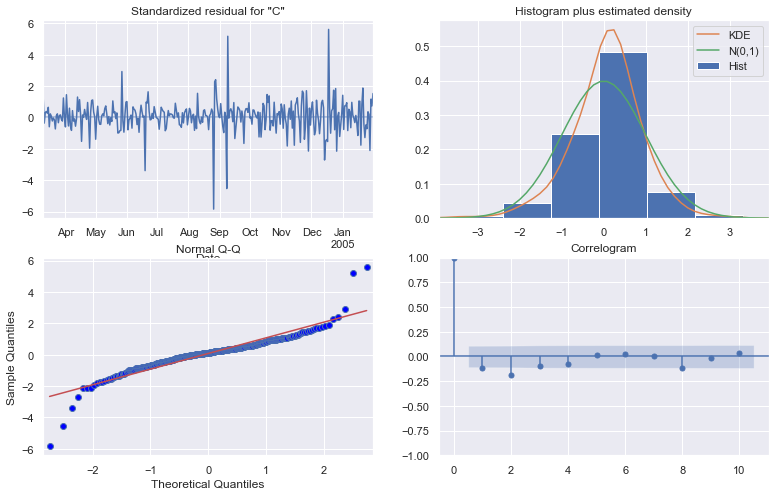

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                CO   No. Observations:                  328
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2135.866
Date:                           Fri, 13 Aug 2021   AIC                           4279.732
Time:                                   12:49:03   BIC                           4294.904
Sample:                               03-10-2004   HQIC                          4285.786
                                    - 01-31-2005                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9879      0.011     89.059      0.000       0.966       1.010
ar.S.L7        0.1125      0.055      2.036      0.042       0.004       0.221
ar.S.L14      -0.0522      0.035     -1.513      0.130      -0.120       0.015
sigma2       2.62e+04   1098.660     23.847      0.000     2.4e+04    2.84e+04
===================================================================================
Ljung-Box (L1) (Q):                   4.67   Jarque-Bera (JB):              1144.13
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               2.21   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [194]:
display(diagnostics[0])
display(models[0].summary())

We observe that the SMA(2) term is not significant, and should be removed

In [195]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    final_model, cv_metrics = eval_model(SARIMAX, train['CO'], model_params = {'order' : (1, 0, 0), 'seasonal_order' : (1,0,0,7)})
    history = record_history(f"SARIMA-(1 ,0, 0)-(1,0,0,7)-CO", cv_metrics, 'CO', past_history=history)
    print("Mean Test RMSE", np.mean(cv_metrics['Test RMSE']))
    display(final_model.summary())

Mean Test RMSE 275.9631446169298


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                CO   No. Observations:                  328
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 7)   Log Likelihood               -2136.290
Date:                           Fri, 13 Aug 2021   AIC                           4278.580
Time:                                   12:49:03   BIC                           4289.959
Sample:                               03-10-2004   HQIC                          4283.120
                                    - 01-31-2005                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9866      0.011     86.249      0.000       0.964       1.009
ar.S.L7        0.1072      0.056      1.928      0.054      -0.002       0.216
sigma2      2.627e+04    926.497     28.359      0.000    2.45e+04    2.81e+04
===================================================================================
Ljung-Box (L1) (Q):                   5.17   Jarque-Bera (JB):              1282.59
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               2.21   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [196]:
history[history['Gas'] == 'CO']

Model Name  Mean Test RMSE  Difference in RMSE  \
0               ExpSmoothingModel-CO      356.688228         -230.716318   
4                 ARIMA-(1, 0, 0)-CO      214.235618          -95.045765   
9   SARIMA-(1, 0, 0)-(2, 0, 0, 7)-CO      271.477149          -97.576194   
13     SARIMA-(1 ,0, 0)-(1,0,0,7)-CO      275.963145         -101.380550   

     Final AICc Gas  
0   3352.278834  CO  
4   4213.796890  CO  
9   4279.856174  CO  
13  4278.654147  CO

However, we see that despite that, the model has not improved.

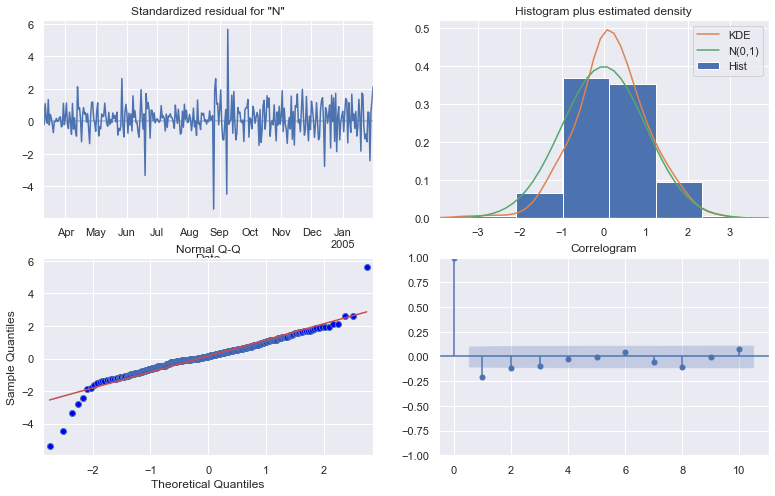

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              NMHC   No. Observations:                  328
Model:             SARIMAX(1, 0, 0)x(3, 0, 0, 7)   Log Likelihood               -2111.233
Date:                           Fri, 13 Aug 2021   AIC                           4232.466
Time:                                   12:49:04   BIC                           4251.431
Sample:                               03-10-2004   HQIC                          4240.032
                                    - 01-31-2005                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9411      0.024     38.814      0.000       0.894       0.989
ar.S.L7        0.2664      0.050      5.292      0.000       0.168       0.365
ar.S.L14       0.0218      0.037      0.592      0.554      -0.050       0.094
ar.S.L21       0.2827      0.063      4.520      0.000       0.160       0.405
sigma2      2.244e+04   1108.304     20.250      0.000    2.03e+04    2.46e+04
===================================================================================
Ljung-Box (L1) (Q):                  13.61   Jarque-Bera (JB):               618.53
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                            -0.44
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [197]:
display(diagnostics[1])
display(models[1].summary())

We observe that for NMHC, the SMA term at Lag 14 is not significant, and should be removed.

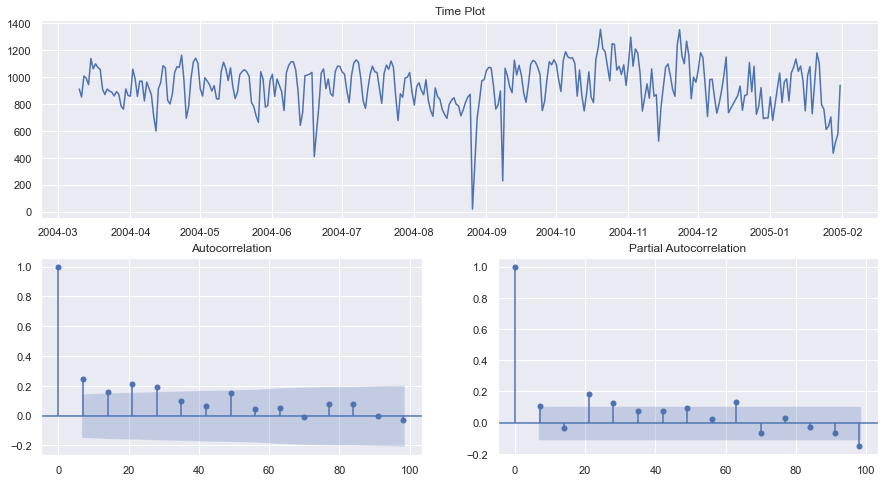

In [141]:
fig = ts_plot(train['NMHC'], seasonal_lags)

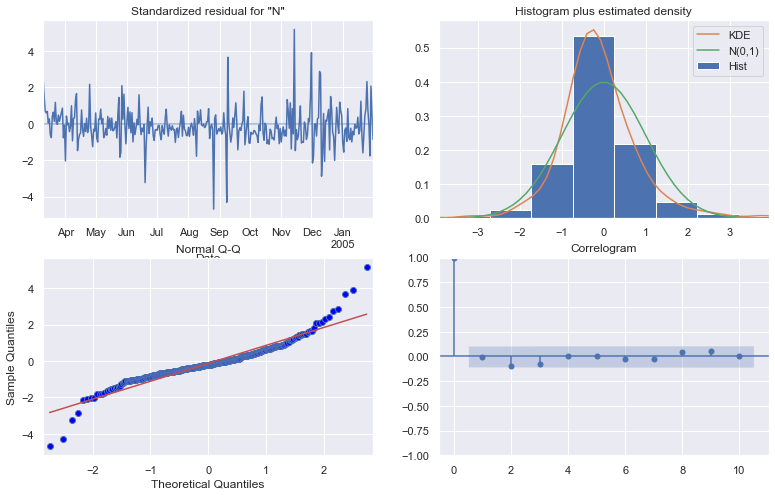

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          SARIMAX Results                                           
====================================================================================================
Dep. Variable:                                          NOx   No. Observations:                  328
Model:             SARIMAX(1, 0, 0)x(1, 0, [1, 2, 3, 4], 7)   Log Likelihood               -2116.276
Date:                                      Fri, 13 Aug 2021   AIC                           4246.553
Time:                                              12:21:32   BIC                           4273.104
Sample:                                          03-10-2004   HQIC                          4257.146
                                               - 01-31-2005                                         
Covariance Type:                                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6245      0.034     18.157      0.000       0.557       0.692
ar.S.L7        0.9999      0.000   5886.982      0.000       1.000       1.000
ma.S.L7       -0.9446      0.068    -13.875      0.000      -1.078      -0.811
ma.S.L14      -0.0963      0.085     -1.136      0.256      -0.262       0.070
ma.S.L21       0.1546      0.073      2.122      0.034       0.012       0.297
ma.S.L28      -0.0895      0.072     -1.250      0.211      -0.230       0.051
sigma2      2.156e+04    1.1e-06   1.96e+10      0.000    2.16e+04    2.16e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               479.44
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.92   Skew:                             0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.28e+25. Standard errors may be unstable.
"""

In [153]:
display(diagnostics[2])
display(models[2].summary())

In [158]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    final_model, cv_metrics = eval_model(SARIMAX, train['NOx'], model_params = {'order' : (1, 0, 0), 'seasonal_order' : (1,0,(1,3),7)})
    history = record_history(f"SARIMA-(1 ,0, 0)-(1,0,(1,3),7)-NOx", cv_metrics, 'NOx', past_history=history)
    print("Mean Test RMSE", np.mean(cv_metrics['Test RMSE']))
    display(final_model.summary())

Mean Test RMSE 185.14233720425284


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                    NOx   No. Observations:                  328
Model:             SARIMAX(1, 0, 0)x(1, 0, [1, 3], 7)   Log Likelihood               -2116.200
Date:                                Fri, 13 Aug 2021   AIC                           4242.400
Time:                                        12:23:57   BIC                           4261.365
Sample:                                    03-10-2004   HQIC                          4249.967
                                         - 01-31-2005                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5911      0.033     18.079      0.000       0.527       0.655
ar.S.L7        0.9992      0.001   1770.429      0.000       0.998       1.000
ma.S.L7       -0.9677      0.038    -25.653      0.000      -1.042      -0.894
ma.S.L21       0.0678      0.038      1.806      0.071      -0.006       0.141
sigma2      2.176e+04    894.429     24.324      0.000       2e+04    2.35e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):               569.38
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                             0.67
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [159]:
history[history['Gas'] == 'NOx']

Model Name  Mean Test RMSE  Difference in RMSE  \
2                ExpSmoothingModel-NOx      263.253544         -122.906042   
6                  ARIMA-(1, 0, 0)-NOx      208.188353          -79.503795   
11   SARIMA-(1, 0, 0)-(1, 0, 4, 7)-NOx      187.794621          -21.485298   
14  SARIMA-(1 ,0, 0)-(1,0,(1,3),7)-NOx      185.142337          -18.681534   

     Final AICc  Gas  
2   3378.137466  NOx  
6   4240.520784  NOx  
11  4246.902803  NOx  
14  4242.586655  NOx

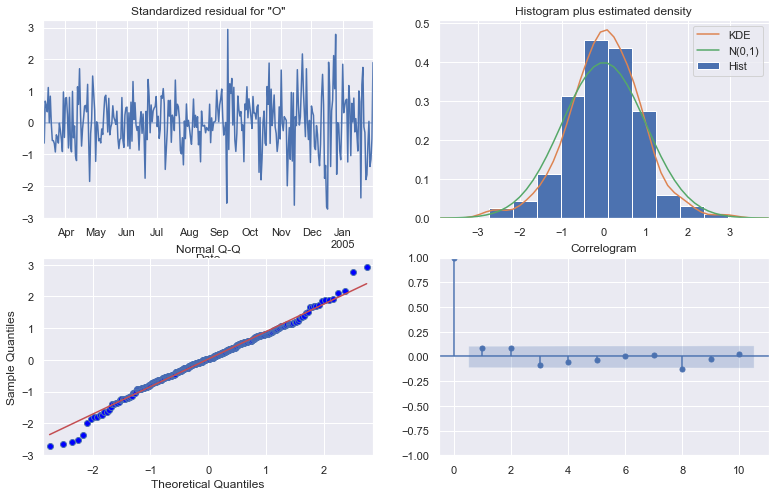

<class 'statsmodels.iolib.summary.Summary'>
"""
                                               SARIMAX Results                                               
=============================================================================================================
Dep. Variable:                                                    O3   No. Observations:                  328
Model:             SARIMAX(1, 0, 2)x(7, 0, [1, 2, 3, 4, 5, 6, 7], 7)   Log Likelihood               -2212.989
Date:                                               Fri, 13 Aug 2021   AIC                           4461.978
Time:                                                       12:24:08   BIC                           4530.252
Sample:                                                   03-10-2004   HQIC                          4489.218
                                                        - 01-31-2005                                         
Covariance Type:                                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9919      0.016     63.221      0.000       0.961       1.023
ma.L1         -0.3100      0.059     -5.300      0.000      -0.425      -0.195
ma.L2         -0.4108      0.067     -6.119      0.000      -0.542      -0.279
ar.S.L7        0.3180      0.290      1.095      0.273      -0.251       0.887
ar.S.L14       0.1771      0.312      0.568      0.570      -0.434       0.788
ar.S.L21      -0.5044      0.335     -1.506      0.132      -1.161       0.152
ar.S.L28       0.4753      0.332      1.430      0.153      -0.176       1.127
ar.S.L35      -0.0733      0.332     -0.220      0.825      -0.725       0.578
ar.S.L42      -0.3341      0.331     -1.008      0.313      -0.983       0.315
ar.S.L49       0.7841      0.259      3.025      0.002       0.276       1.292
ma.S.L7       -0.3198      0.344     -0.930      0.352      -0.994       0.354
ma.S.L14      -0.1558      0.380     -0.410      0.682      -0.901       0.589
ma.S.L21       0.5939      0.379      1.567      0.117      -0.149       1.337
ma.S.L28      -0.4503      0.393     -1.145      0.252      -1.221       0.320
ma.S.L35       0.0674      0.381      0.177      0.860      -0.679       0.814
ma.S.L42       0.4628      0.377      1.227      0.220      -0.277       1.202
ma.S.L49      -0.5866      0.304     -1.931      0.054      -1.182       0.009
sigma2      5.182e+04   5610.451      9.236      0.000    4.08e+04    6.28e+04
===================================================================================
Ljung-Box (L1) (Q):                   2.19   Jarque-Bera (JB):                11.14
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               2.59   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [160]:
display(diagnostics[3])
display(models[3].summary())

In [168]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    final_model, cv_metrics = eval_model(SARIMAX, train['O3'], model_params = {'order' : (1, 0, 2), 'seasonal_order' : (0,0,1,49)})
#     history = record_history(f"SARIMA-(1 ,0, 2)-(0,0,1,49)-O3", cv_metrics, 'O3', past_history=history)
    print("Mean Test RMSE", np.mean(cv_metrics['Test RMSE']))
    display(final_model.summary())

Mean Test RMSE 294.21119688253367


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                   O3   No. Observations:                  328
Model:             SARIMAX(1, 0, 2)x(0, 0, [1], 49)   Log Likelihood               -2212.535
Date:                              Fri, 13 Aug 2021   AIC                           4437.069
Time:                                      12:43:29   BIC                           4459.827
Sample:                                  03-10-2004   HQIC                          4446.149
                                       - 01-31-2005                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    387.1437    123.711      3.129      0.002     144.674     629.614
ar.L1          0.6124      0.122      5.007      0.000       0.373       0.852
ma.L1          0.1163      0.140      0.830      0.407      -0.158       0.391
ma.L2         -0.0969      0.097     -1.002      0.317      -0.287       0.093
ma.S.L49       0.3398      0.063      5.416      0.000       0.217       0.463
sigma2      4.148e+04   2904.793     14.282      0.000    3.58e+04    4.72e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 7.33
Prob(Q):                              0.90   Prob(JB):                         0.03
Heteroskedasticity (H):               2.56   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [166]:
history[history['Gas'] == 'O3']

Model Name  Mean Test RMSE  Difference in RMSE  \
3               ExpSmoothingModel-O3      609.730374         -411.572421   
7                 ARIMA-(1, 0, 2)-O3      291.138357         -115.090198   
12  SARIMA-(1, 0, 2)-(7, 0, 7, 7)-O3      341.078500         -151.049466   
15    SARIMA-(1 ,0, 2)-(0,0,1,49)-O3      307.435461         -106.785677   

     Final AICc Gas  
3   3589.365663  O3  
7   4465.495576  O3  
12  4464.191830  O3  
15  4456.410657  O3

### VARMA

In [201]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    final_model, cv_metrics = eval_model(VARMAX, train[gases], model_params = {'order' : (1, 0)})
    history = record_history(f"VARMA-All-(1,0)", cv_metrics, 'All', past_history=history)
    print("Mean Test RMSE", np.mean(cv_metrics['Test RMSE']))
    display(final_model.summary())

Mean Test RMSE 229.9702917252983


<class 'statsmodels.iolib.summary.Summary'>
"""
                                Statespace Model Results                               
=======================================================================================
Dep. Variable:     ['CO', 'NMHC', 'NOx', 'O3']   No. Observations:                  328
Model:                                  VAR(1)   Log Likelihood               -7985.278
                                   + intercept   AIC                          16030.556
Date:                         Fri, 13 Aug 2021   BIC                          16144.346
Time:                                 12:53:26   HQIC                         16075.955
Sample:                             03-10-2004                                         
                                  - 01-31-2005                                         
Covariance Type:                           opg                                         
=======================================================================================================
Ljung-Box (L1) (Q):     0.38, 0.52, 1.70, 0.03   Jarque-Bera (JB):   1243.35, 1880.67, 1236.25, 3172.97
Prob(Q):                0.54, 0.47, 0.19, 0.87   Prob(JB):                       0.00, 0.00, 0.00, 0.00
Heteroskedasticity (H): 2.17, 2.50, 1.80, 3.66   Skew:                        -1.42, -0.62, -0.27, 2.21
Prob(H) (two-sided):    0.00, 0.00, 0.00, 0.00   Kurtosis:                   12.10, 14.67, 12.50, 17.58
                           Results for equation CO                            
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    365.4887     92.497      3.951      0.000     184.199     546.779
L1.CO          0.4642      0.149      3.116      0.002       0.172       0.756
L1.NMHC       -0.1065      0.138     -0.774      0.439      -0.376       0.163
L1.NOx         0.1100      0.088      1.257      0.209      -0.062       0.282
L1.O3          0.2171      0.096      2.272      0.023       0.030       0.404
                          Results for equation NMHC                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    410.9018     91.405      4.495      0.000     231.752     590.052
L1.CO         -0.2163      0.147     -1.469      0.142      -0.505       0.072
L1.NMHC        0.5505      0.130      4.243      0.000       0.296       0.805
L1.NOx         0.0918      0.075      1.222      0.222      -0.055       0.239
L1.O3          0.1647      0.084      1.953      0.051      -0.001       0.330
                           Results for equation NOx                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    534.1676    114.419      4.669      0.000     309.911     758.424
L1.CO          0.2715      0.145      1.873      0.061      -0.013       0.556
L1.NMHC       -0.1503      0.151     -0.996      0.319      -0.446       0.146
L1.NOx         0.4194      0.077      5.472      0.000       0.269       0.570
L1.O3         -0.2005      0.104     -1.934      0.053      -0.404       0.003
                           Results for equation O3                            
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    292.9182    160.905      1.820      0.069     -22.450     608.287
L1.CO         -0.3234   

From the summary, we see the coefficients for the other gases are not that significant, suggesting including data from other gases does not significantly affect the model. 

In [202]:
history

Model Name  Mean Test RMSE  Difference in RMSE  \
0                 ExpSmoothingModel-CO      356.688228         -230.716318   
1               ExpSmoothingModel-NMHC      265.926375         -144.477968   
2                ExpSmoothingModel-NOx      263.253544         -122.906042   
3                 ExpSmoothingModel-O3      609.730374         -411.572421   
4                   ARIMA-(1, 0, 0)-CO      214.235618          -95.045765   
5                 ARIMA-(1, 0, 1)-NMHC      183.656451          -65.162901   
6                  ARIMA-(1, 0, 0)-NOx      208.188353          -79.503795   
7                   ARIMA-(1, 0, 2)-O3      291.138357         -115.090198   
8                 ARIMA-(1 ,0, 0)-NMHC      183.695231          -61.109540   
9     SARIMA-(1, 0, 0)-(2, 0, 0, 7)-CO      271.477149          -97.576194   
10  SARIMA-(1, 0, 0)-(3, 0, 0, 7)-NMHC      265.825781         -112.856685   
11   SARIMA-(1, 0, 0)-(1, 0, 4, 7)-NOx      187.794621          -21.485298   
12    SARIMA-(1, 0, 2)-(7, 0, 7, 7)-O3      341.078500         -151.049466   
13       SARIMA-(1 ,0, 0)-(1,0,0,7)-CO      275.963145         -101.380550   
14                     VARMA-All-(1,0)      229.970292          -91.868616   

      Final AICc   Gas  
0    3352.278834    CO  
1    3288.206989  NMHC  
2    3378.137466   NOx  
3    3589.365663    O3  
4    4213.796890    CO  
5    4188.780296  NMHC  
6    4240.520784   NOx  
7    4465.495576    O3  
8    4188.591376  NMHC  
9    4279.856174    CO  
10   4232.652146  NMHC  
11   4246.902803   NOx  
12   4464.191830    O3  
13   4278.654147    CO  
14  16036.818497   All

In [216]:
cv_metrics = defaultdict(list)
for train_idx, test_idx in TimeSeriesSplit(4).split(train):
    train_set = train[gases].iloc[train_idx]
    test_set = train[gases].iloc[test_idx]
    
    model = VARMAX(train_set, order= (1, 0)).fit()
    test_preds = model.predict(start=test_set.index[0], end=test_set.index[-1])
    for gas in gases:
        cv_metrics[gas].append(np.sqrt(mean_squared_error(test_set[gas], test_preds[gas])))

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



In [219]:
pd.DataFrame(cv_metrics).mean()

CO      215.246104
NMHC    184.015962
NOx     209.652040
O3      291.129584
dtype: float64

We observe there is not much of an improvement over existing ARIMA models in terms of score.

In [222]:
history.sort_values(["Gas", "Mean Test RMSE"])

Model Name  Mean Test RMSE  Difference in RMSE  \
14                     VARMA-All-(1,0)      229.970292          -91.868616   
4                   ARIMA-(1, 0, 0)-CO      214.235618          -95.045765   
9     SARIMA-(1, 0, 0)-(2, 0, 0, 7)-CO      271.477149          -97.576194   
13       SARIMA-(1 ,0, 0)-(1,0,0,7)-CO      275.963145         -101.380550   
0                 ExpSmoothingModel-CO      356.688228         -230.716318   
5                 ARIMA-(1, 0, 1)-NMHC      183.656451          -65.162901   
8                 ARIMA-(1 ,0, 0)-NMHC      183.695231          -61.109540   
10  SARIMA-(1, 0, 0)-(3, 0, 0, 7)-NMHC      265.825781         -112.856685   
1               ExpSmoothingModel-NMHC      265.926375         -144.477968   
11   SARIMA-(1, 0, 0)-(1, 0, 4, 7)-NOx      187.794621          -21.485298   
6                  ARIMA-(1, 0, 0)-NOx      208.188353          -79.503795   
2                ExpSmoothingModel-NOx      263.253544         -122.906042   
7                   ARIMA-(1, 0, 2)-O3      291.138357         -115.090198   
12    SARIMA-(1, 0, 2)-(7, 0, 7, 7)-O3      341.078500         -151.049466   
3                 ExpSmoothingModel-O3      609.730374         -411.572421   

      Final AICc   Gas  
14  16036.818497   All  
4    4213.796890    CO  
9    4279.856174    CO  
13   4278.654147    CO  
0    3352.278834    CO  
5    4188.780296  NMHC  
8    4188.591376  NMHC  
10   4232.652146  NMHC  
1    3288.206989  NMHC  
11   4246.902803   NOx  
6    4240.520784   NOx  
2    3378.137466   NOx  
7    4465.495576    O3  
12   4464.191830    O3  
3    3589.365663    O3

#### Dynamic Regression Methods

In [223]:
ARIMA_Results = defaultdict(list)
file_names = []
orders = {
    "CO" : (1, 0, 0),
    "NMHC" : (1, 0, 0),
    "NOx" : (1, 0, 0),
    "O3" : (1, 0, 2)
}
exog = train[['T', 'RH']]
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    for gas in tqdm(gases):
        order = orders[gas]
        final_model, cv_metrics = eval_model(ARIMA, train[gas], model_params = {'order' : order, 'exog' : exog})
        ARIMA_Results[gas] = cv_metrics
        file_name = generate_file_name(f"ARIMAX-{order}-{gas}", date=False, location="models/ARIMAX")
        file_names.append(file_name)
        final_model.save(file_name)
        history = record_history(f"ARIMAX-{order}-{gas}", cv_metrics, gas, past_history=history)
results = parse_results(ARIMA_Results).describe()

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 3/4 [00:01<00:00,  1.98it/s]C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimizatio

In [224]:
history.sort_values(["Gas", "Mean Test RMSE"])

Model Name  Mean Test RMSE  Difference in RMSE  \
14                     VARMA-All-(1,0)      229.970292          -91.868616   
15                 ARIMAX-(1, 0, 0)-CO      203.620444          -91.371100   
4                   ARIMA-(1, 0, 0)-CO      214.235618          -95.045765   
9     SARIMA-(1, 0, 0)-(2, 0, 0, 7)-CO      271.477149          -97.576194   
13       SARIMA-(1 ,0, 0)-(1,0,0,7)-CO      275.963145         -101.380550   
0                 ExpSmoothingModel-CO      356.688228         -230.716318   
16               ARIMAX-(1, 0, 0)-NMHC      179.953135          -61.837053   
5                 ARIMA-(1, 0, 1)-NMHC      183.656451          -65.162901   
8                 ARIMA-(1 ,0, 0)-NMHC      183.695231          -61.109540   
10  SARIMA-(1, 0, 0)-(3, 0, 0, 7)-NMHC      265.825781         -112.856685   
1               ExpSmoothingModel-NMHC      265.926375         -144.477968   
11   SARIMA-(1, 0, 0)-(1, 0, 4, 7)-NOx      187.794621          -21.485298   
6                  ARIMA-(1, 0, 0)-NOx      208.188353          -79.503795   
17                ARIMAX-(1, 0, 0)-NOx      209.496452          -81.956373   
2                ExpSmoothingModel-NOx      263.253544         -122.906042   
18                 ARIMAX-(1, 0, 2)-O3      291.120566         -116.935820   
7                   ARIMA-(1, 0, 2)-O3      291.138357         -115.090198   
12    SARIMA-(1, 0, 2)-(7, 0, 7, 7)-O3      341.078500         -151.049466   
3                 ExpSmoothingModel-O3      609.730374         -411.572421   

      Final AICc   Gas  
14  16036.818497   All  
15   4173.575743    CO  
4    4213.796890    CO  
9    4279.856174    CO  
13   4278.654147    CO  
0    3352.278834    CO  
16   4165.727418  NMHC  
5    4188.780296  NMHC  
8    4188.591376  NMHC  
10   4232.652146  NMHC  
1    3288.206989  NMHC  
11   4246.902803   NOx  
6    4240.520784   NOx  
17   4237.772200   NOx  
2    3378.137466   NOx  
18   4456.207105    O3  
7    4465.495576    O3  
12   4464.191830    O3  
3    3589.365663    O3

We observe that adding exogenous variables tends to help our models.

In [226]:
seasonal_orders = {
    "CO" : (2, 0, 0, 7),
    "NMHC" :  (3, 0, 0, 7),
    "NOx" :  (1, 0, 4, 7),
    "O3" :  (7, 0, 7, 7)
}
orders = {
    "CO" : (1, 0, 0),
    "NMHC" : (1, 0, 0),
    "NOx" : (1, 0, 0),
    "O3" : (1, 0, 2)
}
SARIMA_Results = defaultdict(list)
file_names = []
exog = train[['T', 'RH']]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for gas in tqdm(gases):
        order = orders[gas]
        seasonal_order = seasonal_orders[gas] if gas in seasonal_orders else None
        final_model, cv_metrics = eval_model(SARIMAX, train[gas], model_params = {'order' : order, 'seasonal_order' : seasonal_order, 'exog' : exog })
        SARIMA_Results[gas] = cv_metrics
        file_name = generate_file_name(f"SARIMAX-{order}-{seasonal_order}-{gas}", date=False, location="models/SARIMAX")
        file_names.append(file_name)
        final_model.save(file_name)
        history = record_history(f"SARIMAX-{order}-{seasonal_order}-{gas}", cv_metrics, gas, past_history=history)
results = parse_results(SARIMA_Results).describe()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:47<00:00, 11.98s/it]


In [227]:
history.sort_values(["Gas", "Mean Test RMSE"])

Model Name  Mean Test RMSE  Difference in RMSE  \
14                      VARMA-All-(1,0)      229.970292          -91.868616   
15                  ARIMAX-(1, 0, 0)-CO      203.620444          -91.371100   
4                    ARIMA-(1, 0, 0)-CO      214.235618          -95.045765   
9      SARIMA-(1, 0, 0)-(2, 0, 0, 7)-CO      271.477149          -97.576194   
13        SARIMA-(1 ,0, 0)-(1,0,0,7)-CO      275.963145         -101.380550   
19    SARIMAX-(1, 0, 0)-(2, 0, 0, 7)-CO      286.760835         -130.613574   
22    SARIMAX-(1, 0, 0)-(2, 0, 0, 7)-CO      286.760835         -130.613574   
0                  ExpSmoothingModel-CO      356.688228         -230.716318   
16                ARIMAX-(1, 0, 0)-NMHC      179.953135          -61.837053   
5                  ARIMA-(1, 0, 1)-NMHC      183.656451          -65.162901   
8                  ARIMA-(1 ,0, 0)-NMHC      183.695231          -61.109540   
10   SARIMA-(1, 0, 0)-(3, 0, 0, 7)-NMHC      265.825781         -112.856685   
1                ExpSmoothingModel-NMHC      265.926375         -144.477968   
20  SARIMAX-(1, 0, 0)-(3, 0, 0, 7)-NMHC      269.330596         -124.757452   
23  SARIMAX-(1, 0, 0)-(3, 0, 0, 7)-NMHC      269.330596         -124.757452   
11    SARIMA-(1, 0, 0)-(1, 0, 4, 7)-NOx      187.794621          -21.485298   
6                   ARIMA-(1, 0, 0)-NOx      208.188353          -79.503795   
17                 ARIMAX-(1, 0, 0)-NOx      209.496452          -81.956373   
21   SARIMAX-(1, 0, 0)-(1, 0, 4, 7)-NOx      237.376498          -79.770542   
24   SARIMAX-(1, 0, 0)-(1, 0, 4, 7)-NOx      237.376498          -79.770542   
2                 ExpSmoothingModel-NOx      263.253544         -122.906042   
18                  ARIMAX-(1, 0, 2)-O3      291.120566         -116.935820   
7                    ARIMA-(1, 0, 2)-O3      291.138357         -115.090198   
25    SARIMAX-(1, 0, 2)-(7, 0, 7, 7)-O3      330.791203         -138.858896   
12     SARIMA-(1, 0, 2)-(7, 0, 7, 7)-O3      341.078500         -151.049466   
3                  ExpSmoothingModel-O3      609.730374         -411.572421   

      Final AICc   Gas  
14  16036.818497   All  
15   4173.575743    CO  
4    4213.796890    CO  
9    4279.856174    CO  
13   4278.654147    CO  
19   4244.652953    CO  
22   4244.652953    CO  
0    3352.278834    CO  
16   4165.727418  NMHC  
5    4188.780296  NMHC  
8    4188.591376  NMHC  
10   4232.652146  NMHC  
1    3288.206989  NMHC  
20   4190.924191  NMHC  
23   4190.924191  NMHC  
11   4246.902803   NOx  
6    4240.520784   NOx  
17   4237.772200   NOx  
21   4245.250128   NOx  
24   4245.250128   NOx  
2    3378.137466   NOx  
18   4456.207105    O3  
7    4465.495576    O3  
25   4467.456704    O3  
12   4464.191830    O3  
3    3589.365663    O3

- We observe that for CO, NMHC and NOx, SARIMAX actually appears to make the model worse and cause it to overfit more.

##### ARIMAX

In [103]:
orders = {
    "CO" : (1, 0, 0),
    "NMHC" : (1, 0, 0),
    "NOx" : (1, 0, 0),
    "O3" : (1, 0, 0)
}
ARIMAX_Results = defaultdict(list)
arimax_file_names = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for gas in tqdm(gases):
        order = orders[gas]
        exog = train[['T', 'RH']]
        final_model, cv_metrics = eval_model(ARIMA, train[gas], model_params = {'order' : order, 'exog' : exog})
        ARIMAX_Results[gas] = cv_metrics
        file_name = generate_file_name(f"ARIMAX-{order}-{gas}", date=False, location="models/ARIMAX")
        arimax_file_names.append(file_name)
        final_model.save(file_name)
        history = record_history(f"ARIMAX-{order}-{gas}", cv_metrics, gas)
results = parse_results(ARIMAX_Results).describe()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.65it/s]


In [104]:
results.T

count         mean          std          min  \
CO   Corrected AIC         5.0  2055.787041  1088.709875   699.003773   
     Train RMSE            5.0   110.169412    17.328364    91.616824   
     Test RMSE             5.0   193.274772    42.693334   144.608963   
     Difference in RMSE    5.0   -83.105360    52.202430  -145.234466   
     Final AICc            5.0  4173.575743     0.000000  4173.575743   
NMHC Corrected AIC         5.0  2077.578971  1098.621230   705.517374   
     Train RMSE            5.0   116.607705    17.034950    96.026742   
     Test RMSE             5.0   173.383985    31.652739   149.328488   
     Difference in RMSE    5.0   -56.776280    34.624106  -107.020707   
     Final AICc            5.0  4165.727418     0.000000  4165.727418   
NOx  Corrected AIC         5.0  2102.815024  1105.561018   725.440026   
     Train RMSE            5.0   128.040354    14.553551   114.788975   
     Test RMSE             5.0   200.519266    46.381325   141.373138   
     Difference in RMSE    5.0   -72.478912    46.599994  -132.037661   
     Final AICc            5.0  4237.772200     0.000000  4237.772200   
O3   Corrected AIC         5.0  2204.252811  1137.741955   777.987577   
     Train RMSE            5.0   177.871953     7.276782   170.382029   
     Test RMSE             5.0   297.895881    63.436251   238.481818   
     Difference in RMSE    5.0  -120.023928    58.700155  -192.281981   
     Final AICc            5.0  4456.111369     0.000000  4456.111369   

                                 25%          50%          75%          max  
CO   Corrected AIC       1373.281566  1993.049902  2774.166667  3439.433300  
     Train RMSE            96.061944   106.977310   126.515701   129.675281  
     Test RMSE            152.410440   204.048147   228.455021   236.851291  
     Difference in RMSE  -107.986203  -101.939321   -45.433130   -14.933682  
     Final AICc          4173.575743  4173.575743  4173.575743  4173.575743  
NMHC Corrected AIC       1384.871223  2033.209324  2786.261875  3478.035057  
     Train RMSE           107.011437   111.650664   132.887825   135.461858  
     Test RMSE            150.180111   152.028186   201.350997   214.032144  
     Difference in RMSE   -68.463172   -56.001444   -37.677824   -14.718253  
     Final AICc          4165.727418  4165.727418  4165.727418  4165.727418  
NOx  Corrected AIC       1410.576636  2055.705187  2793.598857  3528.754416  
     Train RMSE           115.075998   125.661575   135.664228   149.010995  
     Test RMSE            166.956468   204.264998   242.888068   247.113658  
     Difference in RMSE  -107.223841   -55.254002   -52.167493   -15.711563  
     Final AICc          4237.772200  4237.772200  4237.772200  4237.772200  
O3   Corrected AIC       1483.461745  2187.086204  2910.978029  3661.750501  
     Train RMSE           173.565293   176.526311   179.493815   189.392316  
     Test RMSE            251.419857   266.567247   364.202191   368.808291  
     Difference in RMSE  -174.809875   -87.073433   -77.854564   -68.099789  
     Final AICc          4456.111369  4456.111369  4456.111369  4456.111369

In [105]:
history.sort_values(["Gas", "Mean Test RMSE", "Difference in RMSE"])

Model Name  Mean Test RMSE  Difference in RMSE  \
12                 ARIMAX-(1, 0, 0)-CO      193.274772          -83.105360   
4                   ARIMA-(1, 0, 0)-CO      203.280773          -85.847372   
8             SARIMA-(1, 0, 0)-None-CO      270.268912          -96.529081   
0                 ExpSmoothingModel-CO      306.844247         -183.545691   
13               ARIMAX-(1, 0, 0)-NMHC      173.383985          -56.776280   
5                 ARIMA-(1, 0, 1)-NMHC      177.202617          -60.398933   
1               ExpSmoothingModel-NMHC      249.259504         -129.366391   
9   SARIMA-(1, 0, 0)-(0, 0, 3, 7)-NMHC      489.107475         -338.720267   
14                ARIMAX-(1, 0, 0)-NOx      200.519266          -72.478912   
6                  ARIMA-(1, 0, 0)-NOx      201.685957          -72.758676   
2                ExpSmoothingModel-NOx      291.411504         -151.645708   
10   SARIMA-(1, 0, 0)-(0, 0, 2, 7)-NOx      397.321833         -217.410089   
7                   ARIMA-(1, 0, 0)-O3      283.946615         -102.310040   
15                 ARIMAX-(1, 0, 0)-O3      297.895881         -120.023928   
3                 ExpSmoothingModel-O3      420.374863         -223.435144   
11    SARIMA-(1, 0, 0)-(0, 0, 2, 7)-O3      657.100259         -442.009835   

     Final AICc   Gas  
12  4173.575743    CO  
4   4213.796890    CO  
8   4280.269100    CO  
0   3352.278834    CO  
13  4165.727418  NMHC  
5   4188.780296  NMHC  
1   3288.206989  NMHC  
9   4244.135590  NMHC  
14  4237.772200   NOx  
6   4240.520784   NOx  
2   3378.137466   NOx  
10  4315.046525   NOx  
7   4469.611308    O3  
15  4456.111369    O3  
3   3589.365663    O3  
11  4522.475771    O3

It appears that using regression with ARIMA creates models which are actually more robust, as they overfit less. (the exception is for the Ozone model)

##### SARIMAX

In [106]:
seasonal_orders = {
    "NMHC" :  (0, 0, 3, 7),
    "NOx" :  (0, 0, (1, 3), 7),
    "O3" :  (0, 0, (1, 3), 7)
}
orders = {
    "CO" : (1, 0, 0),
    "NMHC" : (1, 0, 0),
    "NOx" : (1, 0, 0),
    "O3" : (1, 0, 0)
}
SARIMAX_Results = defaultdict(list)
sarimax_file_names = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for gas in tqdm(gases):
        order = orders[gas]
        seasonal_order = seasonal_orders[gas] if gas in seasonal_orders else None
        exog = train[['T', 'RH']]
        final_model, cv_metrics = eval_model(SARIMAX, train[gas], model_params = {'order' : order, 'seasonal_order' : seasonal_order, 'exog' : exog})
        SARIMAX_Results[gas] = cv_metrics
        file_name = generate_file_name(f"SARIMAX-{order}-{seasonal_order}-{gas}", date=False, location="models/SARIMAX")
        sarimax_file_names.append(file_name)
        final_model.save(file_name)
        history = record_history(f"SARIMAX-{order}-{seasonal_order}-{gas}", cv_metrics, gas)
    results = parse_results(SARIMAX_Results).describe()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.48s/it]


In [107]:
results.T

count         mean          std          min  \
CO   Corrected AIC         5.0  2106.689314  1133.952799   709.878977   
     Train RMSE            5.0   157.405488    17.730303   132.620733   
     Test RMSE             5.0   219.026721   124.617870    82.789339   
     Difference in RMSE    5.0   -61.621233   136.715836  -250.181671   
     Final AICc            5.0  4245.392792     0.000000  4245.392792   
NMHC Corrected AIC         5.0  2114.861578  1129.872873   712.905694   
     Train RMSE            5.0   146.784633    14.308424   122.845190   
     Test RMSE             5.0   328.315197   149.535597   183.178600   
     Difference in RMSE    5.0  -181.530564   163.669596  -437.772958   
     Final AICc            5.0  4232.495618     0.000000  4232.495618   
NOx  Corrected AIC         5.0  2137.985609  1117.929295   744.720717   
     Train RMSE            5.0   169.330600    14.090888   148.217691   
     Test RMSE             5.0   343.256611   120.468043   212.764075   
     Difference in RMSE    5.0  -173.926012   119.269265  -311.395178   
     Final AICc            5.0  4305.942688     0.000000  4305.942688   
O3   Corrected AIC         5.0  2235.092834  1144.174906   796.680672   
     Train RMSE            5.0   209.423490    23.395660   194.269383   
     Test RMSE             5.0   400.900504   175.792248   257.878335   
     Difference in RMSE    5.0  -191.477014   189.425319  -488.395518   
     Final AICc            5.0  4502.356742     0.000000  4502.356742   

                                 25%          50%          75%          max  
CO   Corrected AIC       1389.138112  2011.438797  2874.470431  3548.520252  
     Train RMSE           154.012937   155.162816   163.561641   181.669314  
     Test RMSE            156.914502   157.956326   314.671034   382.802404  
     Difference in RMSE  -159.508218     5.605315    24.754813    71.223598  
     Final AICc          4245.392792  4245.392792  4245.392792  4245.392792  
NMHC Corrected AIC       1412.358053  2026.544950  2868.083364  3554.415830  
     Train RMSE           144.671431   153.284986   154.565690   158.555867  
     Test RMSE            252.943806   256.600242   388.235189   560.618148  
     Difference in RMSE  -243.563758  -102.034552   -99.658821   -24.622733  
     Final AICc          4232.495618  4232.495618  4232.495618  4232.495618  
NOx  Corrected AIC       1440.910558  2087.813286  2835.046549  3581.436935  
     Train RMSE           164.101212   171.981958   177.086378   185.265759  
     Test RMSE            231.992183   353.492222   429.553020   488.481556  
     Difference in RMSE  -265.451809  -181.510264   -83.774491   -27.498316  
     Final AICc          4305.942688  4305.942688  4305.942688  4305.942688  
O3   Corrected AIC       1522.311194  2200.818028  2960.304099  3695.350176  
     Train RMSE           196.765536   200.787982   204.617162   250.677388  
     Test RMSE            266.549966   345.293842   452.115479   682.664901  
     Difference in RMSE  -251.327497  -148.528306   -53.261173   -15.872578  
     Final AICc          4502.356742  4502.356742  4502.356742  4502.356742

In [108]:
history.sort_values(["Gas", "Mean Test RMSE", "Difference in RMSE"])

Model Name  Mean Test RMSE  \
12                      ARIMAX-(1, 0, 0)-CO      193.274772   
4                        ARIMA-(1, 0, 0)-CO      203.280773   
16                SARIMAX-(1, 0, 0)-None-CO      219.026721   
8                  SARIMA-(1, 0, 0)-None-CO      270.268912   
0                      ExpSmoothingModel-CO      306.844247   
13                    ARIMAX-(1, 0, 0)-NMHC      173.383985   
5                      ARIMA-(1, 0, 1)-NMHC      177.202617   
1                    ExpSmoothingModel-NMHC      249.259504   
17      SARIMAX-(1, 0, 0)-(0, 0, 3, 7)-NMHC      328.315197   
9        SARIMA-(1, 0, 0)-(0, 0, 3, 7)-NMHC      489.107475   
14                     ARIMAX-(1, 0, 0)-NOx      200.519266   
6                       ARIMA-(1, 0, 0)-NOx      201.685957   
2                     ExpSmoothingModel-NOx      291.411504   
18  SARIMAX-(1, 0, 0)-(0, 0, (1, 3), 7)-NOx      343.256611   
10        SARIMA-(1, 0, 0)-(0, 0, 2, 7)-NOx      397.321833   
7                        ARIMA-(1, 0, 0)-O3      283.946615   
15                      ARIMAX-(1, 0, 0)-O3      297.895881   
19   SARIMAX-(1, 0, 0)-(0, 0, (1, 3), 7)-O3      400.900504   
3                      ExpSmoothingModel-O3      420.374863   
11         SARIMA-(1, 0, 0)-(0, 0, 2, 7)-O3      657.100259   

    Difference in RMSE   Final AICc   Gas  
12          -83.105360  4173.575743    CO  
4           -85.847372  4213.796890    CO  
16          -61.621233  4245.392792    CO  
8           -96.529081  4280.269100    CO  
0          -183.545691  3352.278834    CO  
13          -56.776280  4165.727418  NMHC  
5           -60.398933  4188.780296  NMHC  
1          -129.366391  3288.206989  NMHC  
17         -181.530564  4232.495618  NMHC  
9          -338.720267  4244.135590  NMHC  
14          -72.478912  4237.772200   NOx  
6           -72.758676  4240.520784   NOx  
2          -151.645708  3378.137466   NOx  
18         -173.926012  4305.942688   NOx  
10         -217.410089  4315.046525   NOx  
7          -102.310040  4469.611308    O3  
15         -120.023928  4456.111369    O3  
19         -191.477014  4502.356742    O3  
3          -223.435144  3589.365663    O3  
11         -442.009835  4522.475771    O3

In [109]:
%%capture 
# ^suppress output
models = [load(file) for file in sarimax_file_names]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    diagnostics = [model.plot_diagnostics() for model in models]


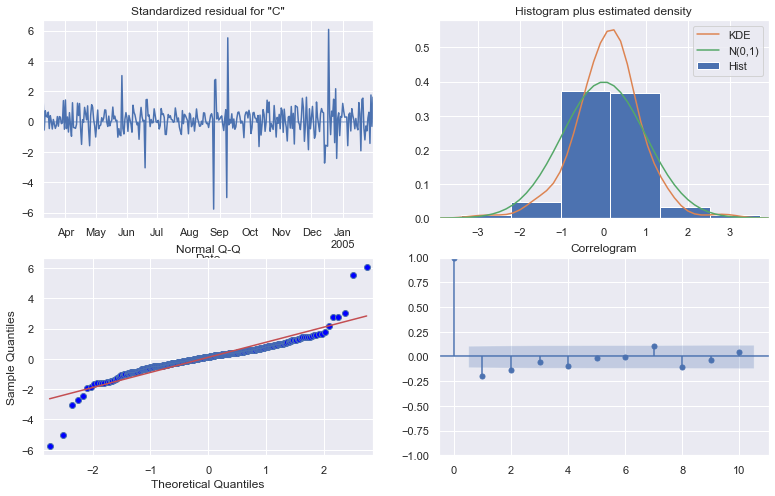

In [110]:
diagnostics[0]

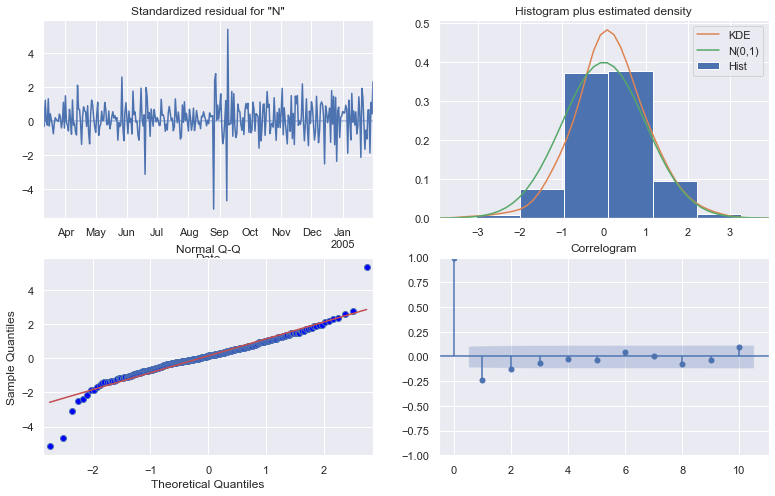

In [111]:
diagnostics[1]

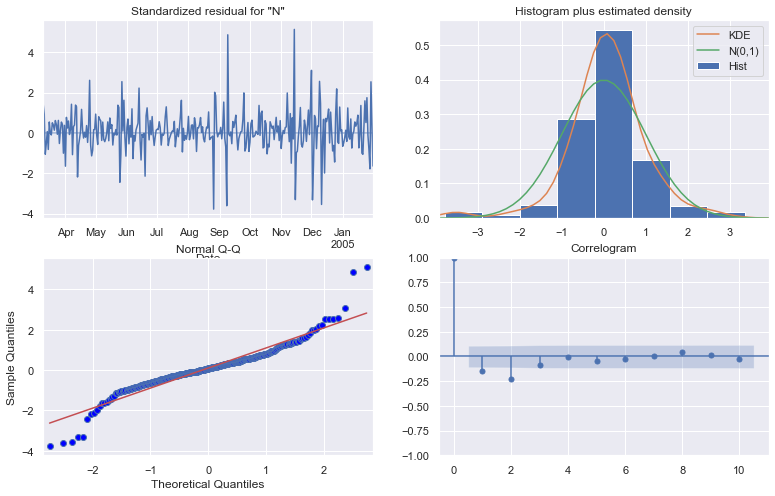

In [112]:
diagnostics[2]

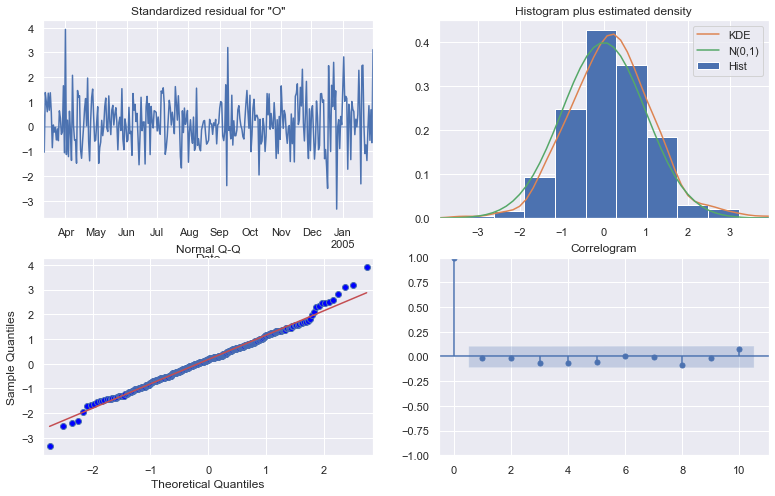

In [113]:
diagnostics[3]

### Model Improvement

#### Utility Functions

In [288]:
def score_cv(data, param, model):
    try:
        cur_model, cv_metrics = eval_model(model, data, model_params=param, refit=False)
        # cur_model.save(name)
    except Exception as error:
        try:
            cur_model, cv_metrics = eval_model(model, data, model_params=param | dict(initialization='approximate_diffuse'), refit=False)
        except:
            return np.inf, np.inf
    return np.mean(cv_metrics['Test RMSE']), np.mean(cv_metrics['Difference in RMSE'])

In [267]:


def grid_search(data, gas,param_grid,model = SARIMAX):
    """
    Performs a grid search on SARIMAX parameters
    """
    with warnings.catch_warnings():
        #warnings.simplefilter("ignore")
#         warnings.simplefilter("error", UserWarning) # throw warning for non-invertible/stationary models
#         if exog:
#             file_names = [generate_file_name(f"SARIMAX-{params['order']}-{params['seasonal_order']}-{params['trend']}-{gas}", date=False, location="models/SARIMAX") for params in param_grid]
#         else:
#             file_names = [generate_file_name(f"SARIMA-{params['order']}-{params['seasonal_order']}-{params['trend']}-{gas}", date=False, location="models/SARIMA") for params in param_grid]
        parallel_instance = Parallel(n_jobs=-1, verbose=5)
        tasks = (
            delayed(score_cv)(data, param, model) for param in param_grid
        )
        rmse, rmse_diff = tuple(zip(*parallel_instance(tasks)))
    rmse = np.array(rmse)
    rmse_diff = np.array(rmse_diff)
    param_grid = np.array(param_grid)
    best_models = np.argsort(rmse)
    return pd.DataFrame({
        "Test RMSE" : rmse,
        "Difference in RMSE" : rmse_diff,
        "Order" : [param['order'] for param in param_grid],
        "Seasonal Order" :  [param['seasonal_order'] if 'seasonal_order' in param else None for param in param_grid],
        "Trend" :  [param['trend'] if 'trend' in param else None for param in param_grid],
        "Exog?" :  [param['exog'] if 'exog' in param else None for param in param_grid]
    }).sort_values(["Test RMSE", "Difference in RMSE"])



#### Finding the Optimal Order for ARIMA
We will begin by attempting to find the optimal parameters for an ARIMA model. This will be done on a cross-validated grid search of hyperparameters.

In [276]:
param_grid = [
    {
        "order" : (p, d, q)
    } for p in range(4) for d in range(2) for q in range(4)
]
gs_results = {}

for gas in gases:
    gs_results[gas] = grid_search(train[gas], gas, param_grid = param_grid, model=ARIMA)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  32 | elapsed:    2.6s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  23 out of  32 | elapsed:    3.5s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  30 out of  32 | elapsed:    4.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  32 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  23 out of  32 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  30 out of  32 | elapsed:    2.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  32 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  23 out of  32 | elapsed:    1.3

In [278]:
for gas, result in gs_results.items():
    print(gas)
    display(result.head())

CO


Test RMSE  Difference in RMSE      Order Seasonal Order Trend Exog?
21  197.466638          -79.957156  (2, 1, 1)           None  None  None
22  205.090413          -89.907916  (2, 1, 2)           None  None  None
23  205.811044          -90.645742  (2, 1, 3)           None  None  None
31  205.830931          -91.503752  (3, 1, 3)           None  None  None
29  205.842256          -89.005073  (3, 1, 1)           None  None  None

NMHC


Test RMSE  Difference in RMSE      Order Seasonal Order Trend Exog?
26  183.304242          -69.964411  (3, 0, 2)           None  None  None
1   183.469474          -63.346658  (0, 0, 1)           None  None  None
0   183.497600          -40.435611  (0, 0, 0)           None  None  None
24  183.558974          -64.905130  (3, 0, 0)           None  None  None
2   183.600040          -64.966247  (0, 0, 2)           None  None  None

NOx


Test RMSE  Difference in RMSE      Order Seasonal Order Trend Exog?
23  182.563329          -59.618893  (2, 1, 3)           None  None  None
22  182.752495          -59.112101  (2, 1, 2)           None  None  None
30  182.881290          -59.773046  (3, 1, 2)           None  None  None
31  183.294140          -61.960510  (3, 1, 3)           None  None  None
29  184.043734          -59.644557  (3, 1, 1)           None  None  None

O3


Test RMSE  Difference in RMSE      Order Seasonal Order Trend Exog?
22  283.964479         -106.101655  (2, 1, 2)           None  None  None
18  290.509714         -116.105432  (2, 0, 2)           None  None  None
8   290.772993         -108.581935  (1, 0, 0)           None  None  None
26  290.866400         -116.704832  (3, 0, 2)           None  None  None
24  290.937888         -115.529144  (3, 0, 0)           None  None  None

| Gas | Order | Test RMSE |
|---|---|---|
|CO | 2,1,1| 197 |
|NMHC | 0,0,0 | 183 |
| NOx | 2,1,3 | 182 |
| O3 | 2,1,2 | 283 |
| Overall | - | 211.25 |

#### Finding Optimal Order for ARIMAX

In [279]:
param_grid = [
    {
        "order" : (p, d, q),
        "exog" : train[['T', 'RH']]
    } for p in range(4) for d in range(2) for q in range(4)
]
gs_results = {}

for gas in gases:
    gs_results[gas] = grid_search(train[gas], gas, param_grid = param_grid, model=ARIMA)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  32 | elapsed:    2.4s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  23 out of  32 | elapsed:    3.5s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  30 out of  32 | elapsed:    4.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  32 | elapsed:    2.2s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  23 out of  32 | elapsed:    3.5s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  30 out of  32 | elapsed:    4.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  32 | elapsed:    2.2s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  23 out of  32 | elapsed:    3.4

In [280]:
for gas, result in gs_results.items():
    print(gas)
    display(result.head())

CO


Test RMSE  Difference in RMSE      Order Seasonal Order Trend  \
31  181.300374          -75.413649  (3, 1, 3)           None  None   
22  185.517491          -78.299491  (2, 1, 2)           None  None   
23  187.744039          -80.824867  (2, 1, 3)           None  None   
1   193.839630          -75.158733  (0, 0, 1)           None  None   
19  193.939532          -84.650030  (2, 0, 3)           None  None   

                                                Exog?  
31  Gas                 T         RH
Date         ...  
22  Gas                 T         RH
Date         ...  
23  Gas                 T         RH
Date         ...  
1   Gas                 T         RH
Date         ...  
19  Gas                 T         RH
Date         ...

NMHC


Test RMSE  Difference in RMSE      Order Seasonal Order Trend  \
26  171.760487          -59.710071  (3, 0, 2)           None  None   
0   174.685603          -40.946883  (0, 0, 0)           None  None   
25  174.778569          -60.167030  (3, 0, 1)           None  None   
3   174.931555          -60.379586  (0, 0, 3)           None  None   
1   177.272029          -61.425234  (0, 0, 1)           None  None   

                                                Exog?  
26  Gas                 T         RH
Date         ...  
0   Gas                 T         RH
Date         ...  
25  Gas                 T         RH
Date         ...  
3   Gas                 T         RH
Date         ...  
1   Gas                 T         RH
Date         ...

NOx


Test RMSE  Difference in RMSE      Order Seasonal Order Trend  \
23  181.878862          -60.667435  (2, 1, 3)           None  None   
22  182.478937          -59.396130  (2, 1, 2)           None  None   
31  182.629893          -61.995953  (3, 1, 3)           None  None   
29  183.137147          -59.944200  (3, 1, 1)           None  None   
6   183.688786          -58.122364  (0, 1, 2)           None  None   

                                                Exog?  
23  Gas                 T         RH
Date         ...  
22  Gas                 T         RH
Date         ...  
31  Gas                 T         RH
Date         ...  
29  Gas                 T         RH
Date         ...  
6   Gas                 T         RH
Date         ...

O3


Test RMSE  Difference in RMSE      Order Seasonal Order Trend  \
10  290.935501         -116.745007  (1, 0, 2)           None  None   
18  291.077793         -117.743429  (2, 0, 2)           None  None   
25  292.400629         -118.576039  (3, 0, 1)           None  None   
1   292.909311         -113.874122  (0, 0, 1)           None  None   
0   294.623710          -76.032119  (0, 0, 0)           None  None   

                                                Exog?  
10  Gas                 T         RH
Date         ...  
18  Gas                 T         RH
Date         ...  
25  Gas                 T         RH
Date         ...  
1   Gas                 T         RH
Date         ...  
0   Gas                 T         RH
Date         ...

| Gas | Order | Test RMSE |
|---|---|---|
|CO| 3,1,3 | 181 |
|NMHC | 3,0,2 | 171 |
|NOx | 2,1,3 | 181 |
|O3 | 1,0,2 | 290 |
|Overall | - |205.75 |

#### Finding Optimal Order for SARIMA

In [289]:
param_grid = [
    {
        "order" : (p, d, q),
        "seasonal_order" : (P, 0, Q, 7)
    } for p in range(4) for d in range(2) for q in range(4) for P in range(4) for Q in range(4)
]
gs_results = {}

for gas in gases:
    gs_results[gas] = grid_search(train[gas], gas, param_grid = param_grid, model=SARIMAX)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:  3.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 450 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:  3.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:  1.0min
[Parall

In [290]:
for gas, result in gs_results.items():
    print(gas)
    display(result.head())

CO


Test RMSE  Difference in RMSE      Order Seasonal Order Trend Exog?
341  196.070601          -79.927683  (2, 1, 1)   (1, 0, 1, 7)  None  None
134  196.215832          -26.229206  (1, 0, 0)   (1, 0, 2, 7)  None  None
150  196.515509          -26.966246  (1, 0, 1)   (1, 0, 2, 7)  None  None
133  196.612285          -26.616296  (1, 0, 0)   (1, 0, 1, 7)  None  None
153  196.666165          -27.145107  (1, 0, 1)   (2, 0, 1, 7)  None  None

NMHC


Test RMSE  Difference in RMSE      Order Seasonal Order Trend Exog?
56   170.805101           30.768636  (0, 0, 3)   (2, 0, 0, 7)  None  None
341  172.595465          -62.308185  (2, 1, 1)   (1, 0, 1, 7)  None  None
36   172.598883           26.277306  (0, 0, 2)   (1, 0, 0, 7)  None  None
342  172.889327          -63.117081  (2, 1, 1)   (1, 0, 2, 7)  None  None
214  172.927251          -62.600933  (1, 1, 1)   (1, 0, 2, 7)  None  None

NOx


Test RMSE  Difference in RMSE      Order Seasonal Order Trend Exog?
181  174.921909          -16.812377  (1, 0, 3)   (1, 0, 1, 7)  None  None
405  175.387061          -15.954700  (3, 0, 1)   (1, 0, 1, 7)  None  None
293  175.471051          -13.958207  (2, 0, 2)   (1, 0, 1, 7)  None  None
298  175.930937          -17.850817  (2, 0, 2)   (2, 0, 2, 7)  None  None
185  176.127478          -18.793539  (1, 0, 3)   (2, 0, 1, 7)  None  None

O3


Test RMSE  Difference in RMSE      Order Seasonal Order Trend Exog?
354  275.454562          -96.672716  (2, 1, 2)   (0, 0, 2, 7)  None  None
47   275.569773          111.616927  (0, 0, 2)   (3, 0, 3, 7)  None  None
26   276.357788           13.836660  (0, 0, 1)   (2, 0, 2, 7)  None  None
173  276.807814          -81.789951  (1, 0, 2)   (3, 0, 1, 7)  None  None
165  278.345481          -83.214812  (1, 0, 2)   (1, 0, 1, 7)  None  None

| Gas | Order | Seasonal Order | Test RMSE |
|---|---|---|---|
| CO  | 1,0,0 | 1,0,2,7 | 196 |
| NMHC | 0,0,3 | 2,0,0,7 | 170 |
| NOx | 1,0,3 | 1,0,1,7 | 174 |
| O3 | 2,1,2 | 0,0,2,7 | 275 |
| Overall | - | -|203.75 |

#### Finding an Optimal Order for SARIMAX

In [293]:
param_grid = [
    {
        "order" : (p, d, q),
        "seasonal_order" : (P, 0, Q, 7),
        "exog" : train[['T', 'RH']]
    } for p in range(4) for d in range(2) for q in range(4) for P in range(4) for Q in range(4)
]
gs_results = {}

for gas in gases:
    gs_results[gas] = grid_search(train[gas], gas, param_grid = param_grid, model=SARIMAX)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:  5.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:  5.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.1min
[Parall

In [294]:
for gas, result in gs_results.items():
    print(gas)
    display(result.head())

CO


Test RMSE  Difference in RMSE      Order Seasonal Order Trend  \
503  169.939532          -66.111949  (3, 1, 3)   (1, 0, 3, 7)  None   
294  171.533576          -26.757538  (2, 0, 2)   (1, 0, 2, 7)  None   
499  172.374463          -68.228139  (3, 1, 3)   (0, 0, 3, 7)  None   
504  172.573264          -67.886487  (3, 1, 3)   (2, 0, 0, 7)  None   
508  172.675059          -68.528549  (3, 1, 3)   (3, 0, 0, 7)  None   

                                                 Exog?  
503  Gas                 T         RH
Date         ...  
294  Gas                 T         RH
Date         ...  
499  Gas                 T         RH
Date         ...  
504  Gas                 T         RH
Date         ...  
508  Gas                 T         RH
Date         ...

NMHC


Test RMSE  Difference in RMSE      Order Seasonal Order Trend  \
155  154.508834          -19.973192  (1, 0, 1)   (2, 0, 3, 7)  None   
149  154.943472          -21.290659  (1, 0, 1)   (1, 0, 1, 7)  None   
373  159.879635          -56.527357  (2, 1, 3)   (1, 0, 1, 7)  None   
497  160.756993          -52.430058  (3, 1, 3)   (0, 0, 1, 7)  None   
137  160.899795          -21.272312  (1, 0, 0)   (2, 0, 1, 7)  None   

                                                 Exog?  
155  Gas                 T         RH
Date         ...  
149  Gas                 T         RH
Date         ...  
373  Gas                 T         RH
Date         ...  
497  Gas                 T         RH
Date         ...  
137  Gas                 T         RH
Date         ...

NOx


Test RMSE  Difference in RMSE      Order Seasonal Order Trend  \
186  176.736955          -24.642463  (1, 0, 3)   (2, 0, 2, 7)  None   
341  177.215611          -57.464446  (2, 1, 1)   (1, 0, 1, 7)  None   
293  177.445261          -20.277101  (2, 0, 2)   (1, 0, 1, 7)  None   
29   177.795720           13.950465  (0, 0, 1)   (3, 0, 1, 7)  None   
343  178.033978          -60.250482  (2, 1, 1)   (1, 0, 3, 7)  None   

                                                 Exog?  
186  Gas                 T         RH
Date         ...  
341  Gas                 T         RH
Date         ...  
293  Gas                 T         RH
Date         ...  
29   Gas                 T         RH
Date         ...  
343  Gas                 T         RH
Date         ...

O3


Test RMSE  Difference in RMSE      Order Seasonal Order Trend  \
39   270.070560          -59.856827  (0, 0, 2)   (1, 0, 3, 7)  None   
167  270.338797          -78.372128  (1, 0, 2)   (1, 0, 3, 7)  None   
63   270.864150          -72.347478  (0, 0, 3)   (3, 0, 3, 7)  None   
59   272.823864          -73.338667  (0, 0, 3)   (2, 0, 3, 7)  None   
430  274.344852          -84.030182  (3, 0, 2)   (3, 0, 2, 7)  None   

                                                 Exog?  
39   Gas                 T         RH
Date         ...  
167  Gas                 T         RH
Date         ...  
63   Gas                 T         RH
Date         ...  
59   Gas                 T         RH
Date         ...  
430  Gas                 T         RH
Date         ...

#### Testing the Best Models from Tuning

After performing our hyperparameter tuning, we will use the Test RMSE to pick the best models. We will then test out the models to ensure they are stable.

| Gas | Best Model | Order | Seasonal Order | Remarks |
|---|---|---|---|---|
| CO | SARIMAX | 3,1,3 | 1,0,3,7 | |
| NMHC | SARIMAX | 1,0,1 | 1, 0, 1, 7 | Did not use best model found as it was unstable (gave a different RMSE) |
| NOx | SARIMA | 1,0,3 | 1,0,1,7 | |
| O3 | SARIMAX | 1,0,2 | 1,0,3,7 | Did not use best model found as it was unstable (gave a different RMSE)|

##### CO

In [432]:
tuned_results = {}
tuned_file_names = []
warnings.simplefilter("ignore")
gas = 'CO'
order = (3,1,3)
seasonal_order = (1, 0, 3, 7)
co_model, cv_metrics = eval_model(SARIMAX, train[gas], model_params = {'order' : order, 'seasonal_order' : seasonal_order, 'exog' : train[['T', 'RH']]} )
tuned_results['CO'] = cv_metrics
file_name = generate_file_name(f"SARIMAX-{order}-{seasonal_order}-{gas}", date=False, location="models/SARIMAX")
tuned_file_names.append(file_name)
co_model.save(file_name)
history = record_history(f"SARIMAX-Tuned-{order}-{seasonal_order}-{gas}", cv_metrics, gas, past_history=history)
parse_results(tuned_results).describe()

CO                                                        
      Corrected AIC  Train RMSE   Test RMSE Difference in RMSE   Final AICc
count      4.000000    4.000000    4.000000           4.000000     4.000000
mean    2046.351844  103.826648  169.918375         -66.091727  4164.416844
std     1075.454081   21.974341   40.671224          34.954525     0.000000
min      810.600825   79.455624  131.612372        -102.989179  4164.416844
25%     1400.112263   88.159940  143.650161         -89.492164  4164.416844
50%     2042.846674  106.208017  161.858647         -68.574954  4164.416844
75%     2689.086255  121.874725  188.126861         -45.174517  4164.416844
max     3289.113202  123.434937  224.343834         -24.227821  4164.416844

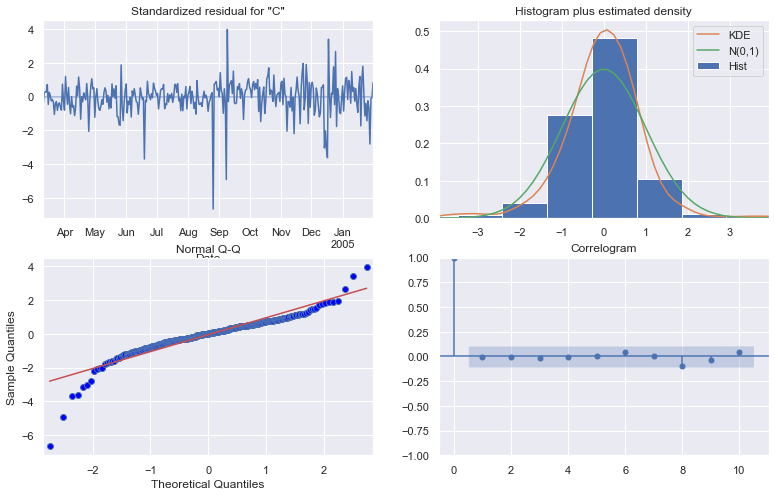

In [310]:
fig = co_model.plot_diagnostics()

We observe that the residuals appear to be normally distributed, and that there are no significant autocorrelations in the residuals.

In [387]:
co_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                CO   No. Observations:                  328
Model:             SARIMAX(3, 1, 3)x(1, 0, 3, 7)   Log Likelihood               -2068.627
Date:                           Fri, 13 Aug 2021   AIC                           4163.254
Time:                                   16:30:28   BIC                           4212.523
Sample:                               03-10-2004   HQIC                          4182.913
                                    - 01-31-2005                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T              6.3602      1.788      3.557      0.000       2.855       9.865
RH             5.3615      1.319      4.066      0.000       2.777       7.946
ar.L1         -0.0944      0.971     -0.097      0.923      -1.997       1.808
ar.L2          0.6717      0.427      1.575      0.115      -0.164       1.508
ar.L3         -0.2296      0.535     -0.429      0.668      -1.277       0.818
ma.L1         -0.2774      0.999     -0.278      0.781      -2.235       1.680
ma.L2         -0.9731      0.230     -4.227      0.000      -1.424      -0.522
ma.L3          0.3023      0.934      0.324      0.746      -1.528       2.132
ar.S.L7        0.9698      0.051     18.893      0.000       0.869       1.070
ma.S.L7       -0.9054      0.073    -12.395      0.000      -1.049      -0.762
ma.S.L14      -0.1404      0.077     -1.835      0.066      -0.290       0.010
ma.S.L21       0.1267      0.064      1.995      0.046       0.002       0.251
sigma2      1.943e+04   1372.789     14.154      0.000    1.67e+04    2.21e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1664.19
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.16   Skew:                            -1.52
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- We observe that many of our terms are not statistically significant, as shown by their high p-value, suggesting some of the terms are redundant
- The Ljung-Box test suggests our model is a good fit to the data.

##### NMHC

In [433]:
tuned_results = {}
warnings.simplefilter("ignore")
gas = 'NMHC'
order = (1, 0, 1)
seasonal_order = (1, 0, 1, 7)
nmhc_model, cv_metrics = eval_model(SARIMAX, train['NMHC'], model_params = {'order' : order, 'seasonal_order' : seasonal_order,'exog' : train[['T', 'RH']]})
tuned_results[gas] = cv_metrics
file_name = generate_file_name(f"SARIMAX-{order}-{seasonal_order}-{gas}", date=False, location="models/SARIMAX")
tuned_file_names.append(file_name)
nmhc_model.save(file_name)
history = record_history(f"SARIMAX-Tuned-{order}-{seasonal_order}-{gas}", cv_metrics, gas, past_history=history)
parse_results(tuned_results).describe()

NMHC                                                        
      Corrected AIC  Train RMSE   Test RMSE Difference in RMSE   Final AICc
count      4.000000    4.000000    4.000000           4.000000     4.000000
mean    2063.800439  137.290563  157.546352         -20.255789  4135.740617
std     1077.379505    5.476572   41.785384          45.215180     0.000000
min      823.763894  131.049089  104.199034         -70.515809  4135.740617
25%     1417.256926  133.893938  141.230796         -38.122662  4135.740617
50%     2062.486534  137.285450  160.314172         -24.925287  4135.740617
75%     2709.030048  140.682075  176.629728          -7.058414  4135.740617
max     3306.464793  143.542261  205.358029          39.343226  4135.740617

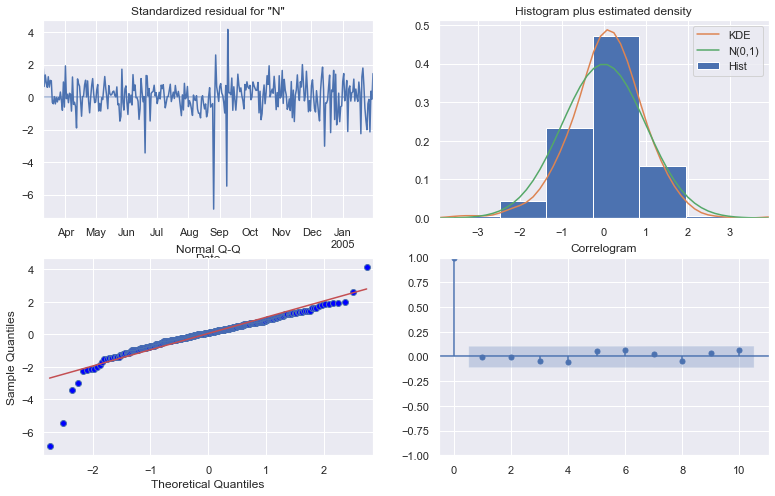

In [408]:
fig = nmhc_model.plot_diagnostics()

In [398]:
nmhc_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   NMHC   No. Observations:                  328
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -2078.749
Date:                Fri, 13 Aug 2021   AIC                           4175.497
Time:                        16:51:17   BIC                           4209.634
Sample:                    03-10-2004   HQIC                          4189.117
                         - 01-31-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        567.4548     46.547     12.191      0.000     476.225     658.685
T              6.8478      1.124      6.094      0.000       4.645       9.050
RH             4.8461      0.875      5.539      0.000       3.131       6.561
ar.L1         -0.5531      3.079     -0.180      0.857      -6.587       5.481
ar.L2          0.3410      1.420      0.240      0.810      -2.443       3.125
ar.L3          0.0097      1.181      0.008      0.993      -2.306       2.325
ma.L1          1.0228      3.074      0.333      0.739      -5.003       7.049
ma.L2          0.0783      2.838      0.028      0.978      -5.484       5.641
sigma2      1.863e+04    901.468     20.668      0.000    1.69e+04    2.04e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               498.55
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                            -1.12
Prob(H) (two-sided):                  0.08   Kurtosis:                         8.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- We observe that the p-value for the Ljung Box test is 0.96, suggesting our residuals are independent (fail to reject null hypothesis). This suggests a good fit to the data.
- We note that many of our terms do not appear to be significant, due to their high p-value.

##### NOx

In [434]:
tuned_results = {}
warnings.simplefilter("ignore")
gas = 'NOx'
order = (1,0,3)
seasonal_order = (1, 0, 1, 7)
nox_model, cv_metrics = eval_model(SARIMAX, train[gas], model_params = {'order' : order, 'seasonal_order' : seasonal_order })
tuned_results[gas] = cv_metrics
file_name = generate_file_name(f"SARIMA-{order}-{seasonal_order}-{gas}", date=False, location="models/SARIMA")
tuned_file_names.append(file_name)
nox_model.save(file_name)
history = record_history(f"SARIMA-Tuned-{order}-{seasonal_order}-{gas}", cv_metrics, gas, past_history=history)
parse_results(tuned_results).describe()

NOx                                                        
      Corrected AIC  Train RMSE   Test RMSE Difference in RMSE   Final AICc
count      4.000000    4.000000    4.000000           4.000000     4.000000
mean    2095.143641  161.551203  181.522166         -19.970963  4216.178221
std     1085.352502   12.584050   52.552678          54.793713     0.000000
min      851.474429  151.663984  139.670151         -92.717026  4216.178221
25%     1454.526591  151.785772  150.693459         -40.334887  4216.178221
50%     2078.988247  158.229709  164.534219         -12.789042  4216.178221
75%     2719.605297  167.995139  195.362926           7.574881  4216.178221
max     3371.123642  178.081408  257.350076          38.411257  4216.178221

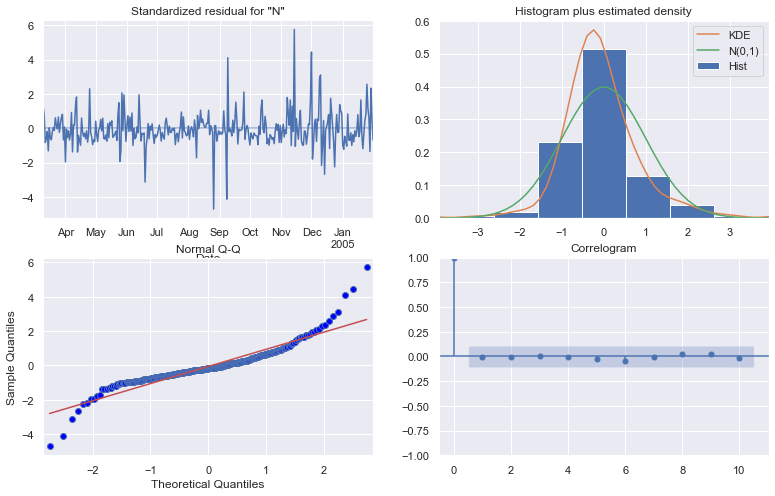

In [410]:
fig = nox_model.plot_diagnostics()

In [468]:
nox_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                 NOx   No. Observations:                  328
Model:             SARIMAX(1, 0, 3)x(1, 0, [1], 7)   Log Likelihood               -2100.914
Date:                             Fri, 13 Aug 2021   AIC                           4215.828
Time:                                     17:32:02   BIC                           4242.379
Sample:                                 03-10-2004   HQIC                          4226.421
                                      - 01-31-2005                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9987      0.002    423.645      0.000       0.994       1.003
ma.L1         -0.3949      0.041     -9.555      0.000      -0.476      -0.314
ma.L2         -0.3498      0.066     -5.297      0.000      -0.479      -0.220
ma.L3         -0.1922      0.068     -2.806      0.005      -0.326      -0.058
ar.S.L7        0.9992      0.003    359.939      0.000       0.994       1.005
ma.S.L7       -0.9863      0.024    -40.572      0.000      -1.034      -0.939
sigma2      2.055e+04    990.925     20.738      0.000    1.86e+04    2.25e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               764.02
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.13   Skew:                             0.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- We observe that the p-value for the Ljung Box test is 0.96, suggesting our residuals are independent. This suggests a good fit to the data.

##### O3

In [435]:
tuned_results = {}
warnings.simplefilter("ignore")
gas = 'O3'
order = 	(1, 0, 2)	
seasonal_order = (1, 0, 3, 7)
o3_model, cv_metrics = eval_model(SARIMAX, train[gas], model_params = {'order' : order, 'seasonal_order' : seasonal_order, 'exog' : train[['T', 'RH']]} )
tuned_results[gas] = cv_metrics
file_name = generate_file_name(f"SARIMAX-{order}-{seasonal_order}-{gas}", date=False, location="models/SARIMAX")
tuned_file_names.append(file_name)
o3_model.save(file_name)
history = record_history(f"SARIMAX-Tuned-{order}-{seasonal_order}-{gas}", cv_metrics, gas, past_history=history)
parse_results(tuned_results).describe()

O3                                                        
      Corrected AIC  Train RMSE   Test RMSE Difference in RMSE   Final AICc
count      4.000000    4.000000    4.000000           4.000000     4.000000
mean    2194.496695  191.933097  270.194189         -78.261092  4439.556142
std     1102.519436   18.961281   62.603340          77.203928     0.000000
min      925.650290  180.171683  210.190361        -163.606299  4439.556142
25%     1547.993319  182.057495  222.798825        -128.742076  4439.556142
50%     2182.444538  183.658920  263.404206         -79.745286  4439.556142
75%     2828.947915  193.534523  310.799570         -29.264302  4439.556142
max     3487.447415  220.242864  343.777982          10.052503  4439.556142

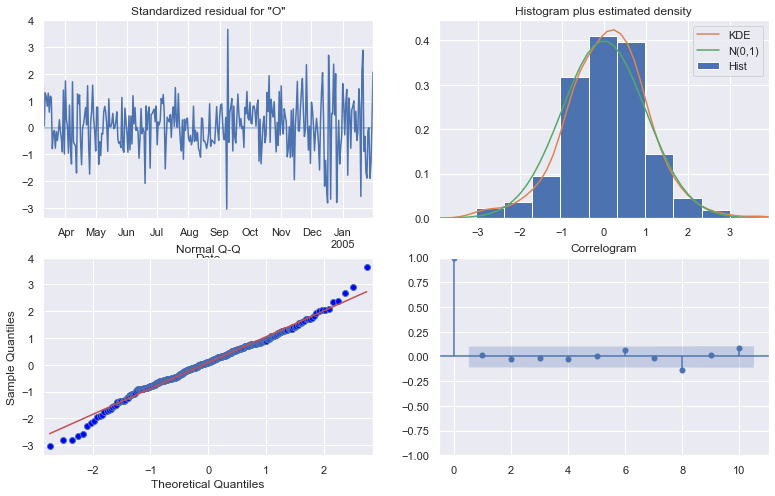

In [411]:
fig = o3_model.plot_diagnostics()

In [412]:
o3_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                        O3   No. Observations:                  328
Model:             SARIMAX(1, 0, 2)x(1, 0, [1, 2, 3], 7)   Log Likelihood               -2209.431
Date:                                   Fri, 13 Aug 2021   AIC                           4438.862
Time:                                           16:56:35   BIC                           4476.792
Sample:                                       03-10-2004   HQIC                          4453.995
                                            - 01-31-2005                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T              0.9672      2.487      0.389      0.697      -3.908       5.842
RH             4.8305      1.564      3.089      0.002       1.766       7.895
ar.L1          0.5613      0.107      5.236      0.000       0.351       0.771
ma.L1          0.1294      0.119      1.089      0.276      -0.103       0.362
ma.L2          0.0334      0.080      0.418      0.676      -0.123       0.190
ar.S.L7        0.9952      0.004    230.268      0.000       0.987       1.004
ma.S.L7       -0.9043      0.061    -14.911      0.000      -1.023      -0.785
ma.S.L14      -0.0358      0.094     -0.381      0.703      -0.220       0.148
ma.S.L21       0.0851      0.064      1.323      0.186      -0.041       0.211
sigma2       4.19e+04   3132.499     13.374      0.000    3.58e+04     4.8e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                13.34
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               2.16   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- We observe that the p-value for the Ljung Box test is 0.96, suggesting our residuals are independent. This suggests a good fit to the data.

#### ARIMA + Seasonal Decomposition

From our previous tuning, we know

| Gas | Order | Test RMSE |
|---|---|---|
|CO | 2,1,1| 197 |
|NMHC | 0,0,0 | 183 |
| NOx | 2,1,3 | 182 |
| O3 | 2,1,2 | 283 |
| Overall | - | 211.25 |

are the optimal arima orders. We will try and see if seasonal decomposition of the data can help an ARIMA model match up to a SARIMA model, by using the Seasonal part of the data from a decomposition.

In [297]:
from statsmodels.tsa.forecasting.stl import STLForecast
orders = {
    "CO" : (2, 1, 1),
    "NMHC" : (0, 0, 0),
    "NOx" : (2, 1, 3),
    "O3" : (2, 1, 2)
}

ARIMAX_Results = defaultdict(list)
arimax_file_names = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for gas in tqdm(gases):
        order = orders[gas]
        exog = train[['T', 'RH']]
        final_model, cv_metrics = eval_model(STLForecast, train[gas], model_params = {'model_kwargs' : {'order' : order}, 'model' : ARIMA, 'period' : 7})
        del cv_metrics['Corrected AIC']
        ARIMAX_Results[gas] = cv_metrics
        file_name = generate_file_name(f"ARIMA-STL-{order}-{gas}", date=False, location="models/ARIMA")
        arimax_file_names.append(file_name)
#         final_model.save(file_name)
        history = record_history(f"ARIMA-STL-{order}-{gas}", cv_metrics, gas)

  0%|                                                                                                                                                                                   | 0/4 [00:00<?, ?it/s]

'STLForecastResults' object has no attribute 'aicc'
'STLForecastResults' object has no attribute 'aicc'
'STLForecastResults' object has no attribute 'aicc'


 25%|██████████████████████████████████████████▊                                                                                                                                | 1/4 [00:00<00:01,  2.54it/s]

'STLForecastResults' object has no attribute 'aicc'
'STLForecastResults' object has no attribute 'aicc'
'STLForecastResults' object has no attribute 'aicc'
'STLForecastResults' object has no attribute 'aicc'

 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 2/4 [00:00<00:00,  3.59it/s]


'STLForecastResults' object has no attribute 'aicc'
'STLForecastResults' object has no attribute 'aicc'
'STLForecastResults' object has no attribute 'aicc'
'STLForecastResults' object has no attribute 'aicc'
'STLForecastResults' object has no attribute 'aicc'
'STLForecastResults' object has no attribute 'aicc'
'STLForecastResults' object has no attribute 'aicc'


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 3/4 [00:01<00:00,  1.52it/s]

'STLForecastResults' object has no attribute 'aicc'
'STLForecastResults' object has no attribute 'aicc'
'STLForecastResults' object has no attribute 'aicc'
'STLForecastResults' object has no attribute 'aicc'
'STLForecastResults' object has no attribute 'aicc'


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.72it/s]

'STLForecastResults' object has no attribute 'aicc'


In [423]:
history.round(2).sort_values(['Gas', 'Mean Test RMSE'])

Model Name  Mean Test RMSE  \
14                                VARMA-All-(1,0)          229.97   
29              SARIMAX-(3, 1, 3)-(1, 0, 3, 7)-CO          169.92   
35        SARIMAX-Tuned-(3, 1, 3)-(1, 0, 3, 7)-CO          169.92   
31    SARIMAX-Weekend-(3, 1, 3)-(1, 0, 3, 7)-CO-n          187.34   
15                            ARIMAX-(1, 0, 0)-CO          203.62   
4                              ARIMA-(1, 0, 0)-CO          214.24   
26                         ARIMA-STL-(2, 1, 1)-CO          223.45   
9                SARIMA-(1, 0, 0)-(2, 0, 0, 7)-CO          271.48   
13                  SARIMA-(1 ,0, 0)-(1,0,0,7)-CO          275.96   
19              SARIMAX-(1, 0, 0)-(2, 0, 0, 7)-CO          286.76   
22              SARIMAX-(1, 0, 0)-(2, 0, 0, 7)-CO          286.76   
0                            ExpSmoothingModel-CO          356.69   
30            SARIMAX-(1, 0, 1)-(1, 0, 1, 7)-NMHC          157.55   
36      SARIMAX-Tuned-(1, 0, 1)-(1, 0, 1, 7)-NMHC          157.55   
32  SARIMAX-Weekend-(1, 0, 1)-(1, 0, 1, 7)-NMHC-n          169.78   
27                       ARIMA-STL-(0, 0, 0)-NMHC          179.55   
16                          ARIMAX-(1, 0, 0)-NMHC          179.95   
5                            ARIMA-(1, 0, 1)-NMHC          183.66   
8                            ARIMA-(1 ,0, 0)-NMHC          183.70   
10             SARIMA-(1, 0, 0)-(3, 0, 0, 7)-NMHC          265.83   
1                          ExpSmoothingModel-NMHC          265.93   
20            SARIMAX-(1, 0, 0)-(3, 0, 0, 7)-NMHC          269.33   
23            SARIMAX-(1, 0, 0)-(3, 0, 0, 7)-NMHC          269.33   
33   SARIMAX-Weekend-(1, 0, 3)-(1, 0, 1, 7)-NOx-n          177.46   
37        SARIMA-Tuned-(1, 0, 3)-(1, 0, 1, 7)-NOx          181.52   
11              SARIMA-(1, 0, 0)-(1, 0, 4, 7)-NOx          187.79   
6                             ARIMA-(1, 0, 0)-NOx          208.19   
28                        ARIMA-STL-(2, 1, 3)-NOx          208.68   
17                           ARIMAX-(1, 0, 0)-NOx          209.50   
21             SARIMAX-(1, 0, 0)-(1, 0, 4, 7)-NOx          237.38   
24             SARIMAX-(1, 0, 0)-(1, 0, 4, 7)-NOx          237.38   
2                           ExpSmoothingModel-NOx          263.25   
38        SARIMAX-Tuned-(1, 0, 2)-(1, 0, 3, 7)-O3          270.19   
18                            ARIMAX-(1, 0, 2)-O3          291.12   
7                              ARIMA-(1, 0, 2)-O3          291.14   
34    SARIMAX-Weekend-(1, 0, 2)-(1, 0, 3, 7)-O3-n          293.18   
25              SARIMAX-(1, 0, 2)-(7, 0, 7, 7)-O3          330.79   
12               SARIMA-(1, 0, 2)-(7, 0, 7, 7)-O3          341.08   
3                            ExpSmoothingModel-O3          609.73   

    Difference in RMSE  Final AICc   Gas  
14              -91.87    16036.82   All  
29              -66.09     4164.42    CO  
35              -66.09     4164.42    CO  
31              -85.09     4167.25    CO  
15              -91.37     4173.58    CO  
4               -95.05     4213.80    CO  
26              -73.68         NaN    CO  
9               -97.58     4279.86    CO  
13             -101.38     4278.65    CO  
19             -130.61     4244.65    CO  
22             -130.61     4244.65    CO  
0              -230.72     3352.28    CO  
30              -20.26     4135.74  NMHC  
36              -20.26     4135.74  NMHC  
32              -39.40     4137.78  NMHC  
27              -70.71         NaN  NMHC  
16              -61.84     4165.73  NMHC  
5               -65.16     4188.78  NMHC  
8               -61.11     4188.59  NMHC  
10             -112.86     4232.65  NMHC  
1              -144.48     3288.21  NMHC  
20             -124.76     4190.92  NMHC  
23             -124.76     4190.92  NMHC  
33              -25.23     4219.56   NOx  
37              -19.97     4216.18   NOx  
11              -21.49     4246.90   NOx  
6               -79.50     4240.52   NOx  
28              -72.10         NaN   NOx  
17              -81.96     4237

We observe that in general, our tuned SARIMAX models still perform the best.

#### Using Weekend as Feature

We will try to do some feature engineering, and add a weekend indicator to our data and see if it results in better forecasts.

In [413]:
train_copy = train.copy(deep=True)
train_copy['is_weekend'] = ((train_copy.index.weekday).isin([5, 6])).astype(int)
train_copy

Gas                  CO         NMHC          NOx           O3          T  \
Date                                                                        
2004-03-10  1316.500000   912.250000  1167.250000  1096.041667  12.020833   
2004-03-11  1244.062500   851.802083  1277.187500   885.031250   9.833333   
2004-03-12  1281.562500  1008.229167  1101.718750  1084.218750  11.292708   
2004-03-13  1330.555556   992.822917   993.159722  1245.781250  12.866319   
2004-03-14  1360.927083   943.854167  1001.104167  1234.177083  16.016667   
...                 ...          ...          ...          ...        ...   
2005-01-27   911.777778   703.312500   997.059028   691.475694   5.267708   
2005-01-28   592.864583   434.350694   635.225694   429.375000  -4.502604   
2005-01-29   769.625000   518.093750  1024.666667   418.072917 -14.272917   
2005-01-30   864.642361   573.684028  1136.718750   474.392361   4.848611   
2005-01-31  1084.500000   939.791667   842.177083  1184.166667   7.273958   

Gas                RH  is_weekend  
Date                               
2004-03-10  54.883334           0  
2004-03-11  64.069791           0  
2004-03-12  51.107292           0  
2004-03-13  51.530903           1  
2004-03-14  48.843750           1  
...               ...         ...  
2005-01-27  39.614930           0  
2005-01-28  34.089236           0  
2005-01-29  28.563542           1  
2005-01-30  37.832986           1  
2005-01-31  31.809375           0  

[328 rows x 7 columns]

In [414]:
seasonal_orders = {
    "CO" : (1, 0, 3, 7),
    "NMHC" :  (1, 0, 1,7),
    "NOx" :  (1, 0, 1,7),
    "O3" :  (1, 0, 3,7)
}
orders = {
    "CO" : (3, 1, 3),
    "NMHC" : (1, 0, 1),
    "NOx" : (1, 0, 3),
    "O3" : (1, 0, 2)
}

SARIMAX_Results = defaultdict(list)
sarimax_file_names = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for gas in tqdm(gases):
        order = orders[gas]
        trend = trends[gas]
        seasonal_order = seasonal_orders[gas] if gas in seasonal_orders else None
        exog = train_copy[['T', 'RH', 'is_weekend']]
        final_model, cv_metrics = eval_model(SARIMAX, train_copy[gas], model_params = {'order' : order, 'seasonal_order' : seasonal_order, 'exog' : exog})
        SARIMAX_Results[gas] = cv_metrics
        file_name = generate_file_name(f"SARIMAX-Weekend-{order}-{seasonal_order}-{gas}-{trend}", date=False, location="models/SARIMAX")
        sarimax_file_names.append(file_name)
        final_model.save(file_name)
        history = record_history(f"SARIMAX-Weekend-{order}-{seasonal_order}-{gas}-{trend}", cv_metrics, gas)
results = parse_results(SARIMAX_Results).describe()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.13s/it]


In [415]:
results.T

count         mean          std          min  \
CO   Corrected AIC         4.0  2042.309613  1072.376270   811.287039   
     Train RMSE            4.0   102.248929    22.264879    78.420799   
     Test RMSE             4.0   187.339597    43.165743   143.019982   
     Difference in RMSE    4.0   -85.090668    31.090142  -127.559566   
     Final AICc            4.0  4167.246341     0.000000  4167.246341   
NMHC Corrected AIC         4.0  2061.271086  1075.389188   825.140702   
     Train RMSE            4.0   130.381162     9.081061   117.317471   
     Test RMSE             4.0   169.781229    52.136535   103.600934   
     Difference in RMSE    4.0   -39.400067    57.478038   -91.262578   
     Final AICc            4.0  4137.778120     0.000000  4137.778120   
NOx  Corrected AIC         4.0  2090.427953  1070.748931   858.996497   
     Train RMSE            4.0   152.225444     9.585919   143.747950   
     Test RMSE             4.0   177.460003    40.459622   144.116805   
     Difference in RMSE    4.0   -25.234560    42.833254   -77.079206   
     Final AICc            4.0  4219.556353     0.000000  4219.556353   
O3   Corrected AIC         4.0  2190.587631  1100.440694   925.857701   
     Train RMSE            4.0   189.660907    19.481381   177.888145   
     Test RMSE             4.0   293.175645    95.154999   203.767337   
     Difference in RMSE    4.0  -103.514738   109.527930  -228.620978   
     Final AICc            4.0  4444.428007     0.000000  4444.428007   

                                 25%          50%          75%          max  
CO   Corrected AIC       1395.207554  2039.220712  2686.322772  3279.509990  
     Train RMSE            85.812994   103.608363   120.044298   123.358189  
     Test RMSE            168.597364   179.919585   198.661819   246.499234  
     Difference in RMSE   -98.524465   -76.722641   -63.288843   -59.357825  
     Final AICc          4167.246341  4167.246341  4167.246341  4167.246341  
NMHC Corrected AIC       1416.229332  2057.525782  2702.567536  3304.892075  
     Train RMSE           127.798058   133.367599   135.950703   137.471981  
     Test RMSE            142.354349   176.484908   203.911788   222.554166  
     Difference in RMSE   -83.100787   -49.090182    -5.389461    31.842676  
     Final AICc          4137.778120  4137.778120  4137.778120  4137.778120  
NOx  Corrected AIC       1458.613810  2080.208858  2712.023001  3342.297599  
     Train RMSE           146.169974   149.830005   155.885475   165.493815  
     Test RMSE            146.247117   167.980653   199.193540   229.761902  
     Difference in RMSE   -50.789880   -21.197813     4.357507    18.536594  
     Final AICc          4219.556353  4219.556353  4219.556353  4219.556353  
O3   Corrected AIC       1543.095932  2177.759131  2825.250830  3480.974562  
     Train RMSE           178.803656   181.025796   191.883047   218.703890  
     Test RMSE            221.246929   280.602719   352.531435   407.729805  
     Difference in RMSE  -174.338120  -100.187264   -29.363882    14.936553  
     Final AICc          4444.428007  4444.428007  4444.428007  4444.428007

In [424]:
history.sort_values(['Gas', 'Mean Test RMSE']).round(2)

Model Name  Mean Test RMSE  \
14                                VARMA-All-(1,0)          229.97   
29              SARIMAX-(3, 1, 3)-(1, 0, 3, 7)-CO          169.92   
35        SARIMAX-Tuned-(3, 1, 3)-(1, 0, 3, 7)-CO          169.92   
31    SARIMAX-Weekend-(3, 1, 3)-(1, 0, 3, 7)-CO-n          187.34   
15                            ARIMAX-(1, 0, 0)-CO          203.62   
4                              ARIMA-(1, 0, 0)-CO          214.24   
26                         ARIMA-STL-(2, 1, 1)-CO          223.45   
9                SARIMA-(1, 0, 0)-(2, 0, 0, 7)-CO          271.48   
13                  SARIMA-(1 ,0, 0)-(1,0,0,7)-CO          275.96   
19              SARIMAX-(1, 0, 0)-(2, 0, 0, 7)-CO          286.76   
22              SARIMAX-(1, 0, 0)-(2, 0, 0, 7)-CO          286.76   
0                            ExpSmoothingModel-CO          356.69   
30            SARIMAX-(1, 0, 1)-(1, 0, 1, 7)-NMHC          157.55   
36      SARIMAX-Tuned-(1, 0, 1)-(1, 0, 1, 7)-NMHC          157.55   
32  SARIMAX-Weekend-(1, 0, 1)-(1, 0, 1, 7)-NMHC-n          169.78   
27                       ARIMA-STL-(0, 0, 0)-NMHC          179.55   
16                          ARIMAX-(1, 0, 0)-NMHC          179.95   
5                            ARIMA-(1, 0, 1)-NMHC          183.66   
8                            ARIMA-(1 ,0, 0)-NMHC          183.70   
10             SARIMA-(1, 0, 0)-(3, 0, 0, 7)-NMHC          265.83   
1                          ExpSmoothingModel-NMHC          265.93   
20            SARIMAX-(1, 0, 0)-(3, 0, 0, 7)-NMHC          269.33   
23            SARIMAX-(1, 0, 0)-(3, 0, 0, 7)-NMHC          269.33   
33   SARIMAX-Weekend-(1, 0, 3)-(1, 0, 1, 7)-NOx-n          177.46   
37        SARIMA-Tuned-(1, 0, 3)-(1, 0, 1, 7)-NOx          181.52   
11              SARIMA-(1, 0, 0)-(1, 0, 4, 7)-NOx          187.79   
6                             ARIMA-(1, 0, 0)-NOx          208.19   
28                        ARIMA-STL-(2, 1, 3)-NOx          208.68   
17                           ARIMAX-(1, 0, 0)-NOx          209.50   
21             SARIMAX-(1, 0, 0)-(1, 0, 4, 7)-NOx          237.38   
24             SARIMAX-(1, 0, 0)-(1, 0, 4, 7)-NOx          237.38   
2                           ExpSmoothingModel-NOx          263.25   
38        SARIMAX-Tuned-(1, 0, 2)-(1, 0, 3, 7)-O3          270.19   
18                            ARIMAX-(1, 0, 2)-O3          291.12   
7                              ARIMA-(1, 0, 2)-O3          291.14   
34    SARIMAX-Weekend-(1, 0, 2)-(1, 0, 3, 7)-O3-n          293.18   
25              SARIMAX-(1, 0, 2)-(7, 0, 7, 7)-O3          330.79   
12               SARIMA-(1, 0, 2)-(7, 0, 7, 7)-O3          341.08   
3                            ExpSmoothingModel-O3          609.73   

    Difference in RMSE  Final AICc   Gas  
14              -91.87    16036.82   All  
29              -66.09     4164.42    CO  
35              -66.09     4164.42    CO  
31              -85.09     4167.25    CO  
15              -91.37     4173.58    CO  
4               -95.05     4213.80    CO  
26              -73.68         NaN    CO  
9               -97.58     4279.86    CO  
13             -101.38     4278.65    CO  
19             -130.61     4244.65    CO  
22             -130.61     4244.65    CO  
0              -230.72     3352.28    CO  
30              -20.26     4135.74  NMHC  
36              -20.26     4135.74  NMHC  
32              -39.40     4137.78  NMHC  
27              -70.71         NaN  NMHC  
16              -61.84     4165.73  NMHC  
5               -65.16     4188.78  NMHC  
8               -61.11     4188.59  NMHC  
10             -112.86     4232.65  NMHC  
1              -144.48     3288.21  NMHC  
20             -124.76     4190.92  NMHC  
23             -124.76     4190.92  NMHC  
33              -25.23     4219.56   NOx  
37              -19.97     4216.18   NOx  
11              -21.49     4246.90   NOx  
6               -79.50     4240.52   NOx  
28              -72.10         NaN   NOx  
17              -81.96     4237

## Final Model

Our final model will be the tuned SARIMAX models from our prior grid search.

In [458]:
print(tuned_file_names)
final_models = dict(zip(gases,tuned_file_names))

['models/SARIMAX/SARIMAX-(3, 1, 3)-(1, 0, 3, 7)-CO.pkl', 'models/SARIMAX/SARIMAX-(1, 0, 1)-(1, 0, 1, 7)-NMHC.pkl', 'models/SARIMA/SARIMA-(1, 0, 3)-(1, 0, 1, 7)-NOx.pkl', 'models/SARIMAX/SARIMAX-(1, 0, 2)-(1, 0, 3, 7)-O3.pkl']


## Generating Kaggle Predictions

In [438]:
test_df = pd.read_csv("test.csv", index_col=0, na_values=[-200])
test_df["Date"] = pd.to_datetime(test_df["Date"], format="%d/%m/%Y")
test_df.index = test_df["Date"]
test_df = test_df.drop("Date", axis=1)

In [439]:
test_df.head(12)

T          RH Gas
Date                                  
2005-02-01    6.616667   51.734375  CO
2005-02-02    7.613194   43.930903  CO
2005-02-03    7.252083   50.966667  CO
2005-02-04    7.473611   50.166319  CO
2005-02-05    5.571875   46.604167  CO
2005-02-06    5.310417   39.594792  CO
2005-02-07    7.307986   35.396875  CO
2005-02-08  -52.136458  -32.741667  CO
2005-02-09         NaN         NaN  CO
2005-02-10         NaN         NaN  CO
2005-02-11 -174.005208 -168.239583  CO
2005-02-12    8.306944   59.144791  CO

In [440]:
test, missing_days = DataPreprocess(test_df, train=False, remove_outliers=True, impute=True)

In [441]:
missing_days.head(12)

Date
2005-02-01    False
2005-02-02    False
2005-02-03    False
2005-02-04    False
2005-02-05    False
2005-02-06    False
2005-02-07    False
2005-02-08    False
2005-02-09     True
2005-02-10     True
2005-02-11    False
2005-02-12    False
dtype: bool

### Utility Functions

In [442]:
def generate_csv(test_preds, missing_days):
    test_preds = np.array(test_preds).flatten()
    submit_df = pd.DataFrame({
    'id' : range(len(test_preds)),
    'Value' : test_preds
})
    submit_df.iloc[missing_days, 1] = -200 # replace days where sensor records were missing with -200 (NaN)
    submit_df.to_csv(generate_file_name("submission", "csv", "submissions", date=True), index=False)

In [444]:
def generate_submission(models, test, missing_days, refit=False):
    preds = []
    for gas in gases:
        model = load(models[gas])
        data = test[test['Gas'] == gas]
#         data.index = data['Date']
        data = data.asfreq("D")
        forecasts = []
        start, end = data.index[0], data.index[-1]
        for date in pd.date_range(start, end):
            exog = data[['T', 'RH']].loc[date:date]
            try:
                forecast = model.predict(start=date, exog=exog)
                forecast.name = gas
                model = model.append(forecast, exog=exog, refit=refit)
            except:
                forecast = model.predict(start=date)
                forecast.name = gas
                model = model.append(forecast, refit=refit)
            forecasts.append(forecast)
        preds.append(forecasts)

    generate_csv(preds, missing_days)
    return preds

### Submission

In [456]:
final_models

{'CO': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x259034026a0>,
 'NMHC': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x25902d75f70>,
 'NOx': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x259034197c0>,
 'O3': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x259034195b0>}

In [460]:
preds = generate_submission(final_models, test, missing_days)

In [466]:
def plot_predictions(data, preds):
    fig, ax = plt.subplots(4, 1, figsize=(10, 15))
    preds_df = pd.DataFrame({
   pd.concat(series).name :pd.concat(series) for series in preds
})
    data[['CO', 'NMHC', 'NOx', 'O3']].plot(subplots=True, ax=ax)
    preds_df.plot(subplots=True, ax =ax, style='--')

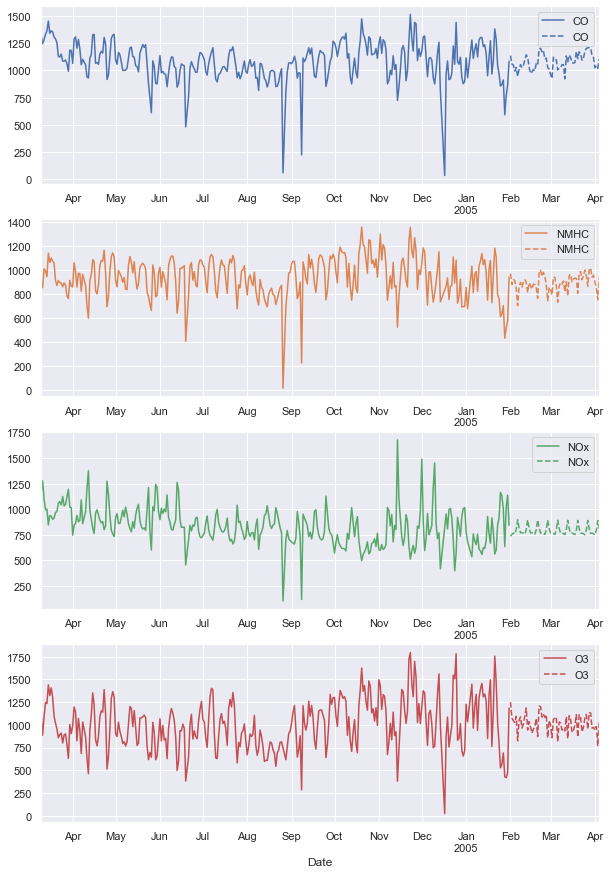

In [467]:
plot_predictions(train, preds)